In [115]:
import pandas as pd
import re
from lifelines import CoxPHFitter
import numpy as np
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from lifelines.plotting import add_at_risk_counts
import matplotlib as mpl
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import os
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import mannwhitneyu
import warnings
from scipy.stats.mstats import winsorize
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon
# 设置matplotlib配置参数以支持中文显示
mpl.rcParams['font.family'] = 'Arial Unicode MS'
# 忽略警告
warnings.filterwarnings('ignore')



# 1. 数据处理

In [144]:
df_person = pd.read_csv('/Users/charlesxiong/Desktop/Yanxu-research/final data/UKB0328.csv')
df_person.head(5)

,X,编号,性别,出生年份,中等活动时间,剧烈活动时间,目前吸烟,曾经吸烟,饮酒情况,母亲孕期吸烟,...,10发病生存时间,10是否死亡,10死亡日期,10死亡生存时间,11是否发病,11发病日期,11发病生存时间,11是否死亡,11死亡日期,11死亡生存时间
0,1,1000017,0,1951,1.0,1.0,0.0,2.0,3.0,1.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
1,2,1000025,1,1944,7.0,0.0,0.0,4.0,2.0,1.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
2,3,1000038,0,1942,3.0,0.0,0.0,4.0,5.0,0.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
3,4,1000042,0,1960,3.0,2.0,0.0,4.0,2.0,-1.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
4,5,1000056,0,1968,5.0,3.0,0.0,3.0,1.0,1.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN


In [145]:
df_parent = pd.read_csv('/Users/charlesxiong/Desktop/Yanxu-research/final data/parentdisease.csv')
df_parent.drop('Unnamed: 0', axis=1, inplace=True)
df_parent.rename(columns={'eid':'编号'}, inplace=True)
df_parent.head(5)

,编号,X20107.0.0,X20110.0.0
0,1000017,13.0,8.0
1,1000025,2.0,-17.0
2,1000038,11.0,-17.0
3,1000042,8.0,8.0
4,1000056,13.0,4.0


In [149]:
df = pd.merge(df_person, df_parent, on='编号', how='left')
df.head(5)

,X,编号,性别,出生年份,中等活动时间,剧烈活动时间,目前吸烟,曾经吸烟,饮酒情况,母亲孕期吸烟,...,10死亡日期,10死亡生存时间,11是否发病,11发病日期,11发病生存时间,11是否死亡,11死亡日期,11死亡生存时间,X20107.0.0,X20110.0.0
0,1,1000017,0,1951,1.0,1.0,0.0,2.0,3.0,1.0,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,13.0,8.0
1,2,1000025,1,1944,7.0,0.0,0.0,4.0,2.0,1.0,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,2.0,-17.0
2,3,1000038,0,1942,3.0,0.0,0.0,4.0,5.0,0.0,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,11.0,-17.0
3,4,1000042,0,1960,3.0,2.0,0.0,4.0,2.0,-1.0,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,8.0,8.0
4,5,1000056,0,1968,5.0,3.0,0.0,3.0,1.0,1.0,...,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,13.0,4.0


### 1.1 Summary

In [119]:
# summary
desc_stats = df.describe(include='all')
missing_values = pd.DataFrame(df.isnull().sum(), columns=['missing_values']).T
combined_info = pd.concat([desc_stats, missing_values])
combined_info

,X,编号,性别,出生年份,中等活动时间,剧烈活动时间,目前吸烟,曾经吸烟,饮酒情况,母亲孕期吸烟,...,10死亡日期,10死亡生存时间,11是否发病,11发病日期,11发病生存时间,11是否死亡,11死亡日期,11死亡生存时间,X20107.0.0,X20110.0.0
count,502309.000000,5.023090e+05,502309.000000,502309.000000,501429.000000,501429.000000,501416.000000,462193.000000,501410.000000,494052.000000,...,44500,183.000000,502308.000000,5405,5405.000000,502211.000000,44500,414.000000,487448.000000,492583.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5285,NaN,NaN,3305,NaN,NaN,5285,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2020/4/15,NaN,NaN,2009/7/1,NaN,NaN,2020/4/15,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36,NaN,NaN,18,NaN,NaN,36,NaN,NaN,NaN
mean,251155.000000,3.512079e+06,0.455996,1951.540888,3.373499,1.671178,0.130425,2.743869,2.942434,0.131004,...,NaN,1473.371585,0.010758,NaN,2513.386494,0.176392,NaN,388.205314,0.257334,-0.243076
std,145004.262521,1.450336e+06,0.498060,8.115755,2.515272,2.039901,0.422396,1.308492,1.544219,0.606004,...,NaN,2319.212775,0.103163,NaN,2079.934507,0.566433,NaN,1099.206599,10.552256,11.183947
min,1.000000,1.000017e+06,0.000000,1934.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,-3.000000,...,NaN,0.000000,0.000000,NaN,-39209.000000,0.000000,NaN,0.000000,-17.000000,-17.000000
25%,125578.000000,2.256055e+06,0.000000,1945.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,...,NaN,16.500000,0.000000,NaN,1436.000000,0.000000,NaN,0.000000,-11.000000,-17.000000
50%,251155.000000,3.512061e+06,0.000000,1950.000000,3.000000,1.000000,0.000000,3.000000,3.000000,0.000000,...,NaN,574.000000,0.000000,NaN,2910.000000,0.000000,NaN,0.000000,3.000000,5.000000
75%,376732.000000,4.768057e+06,1.000000,1958.000000,5.000000,3.000000,0.000000,4.000000,4.000000,1.000000,...,NaN,2067.500000,0.000000,NaN,4086.000000,0.000000,NaN,5.750000,8.000000,8.000000


In [150]:
# 协变量 missing value < 100000
combined_info.loc['missing_values',:'失访日期'][combined_info.loc['missing_values',:'失访日期']<100000]

X                 0.0
编号                0.0
性别                0.0
出生年份              0.0
中等活动时间          880.0
剧烈活动时间          880.0
目前吸烟            893.0
曾经吸烟          40116.0
饮酒情况            899.0
母亲孕期吸烟         8257.0
X4079.0.0           0
X4079.0.1     41205.0
X4080.0.0     34438.0
X4080.0.1     41209.0
种族              900.0
BMI            3107.0
体重             2777.0
白细胞           24327.0
血红蛋白          24322.0
血小板           24325.0
血蛋白           72397.0
总胆固醇          32899.0
肌酐            33131.0
C反应蛋白         33920.0
空腹血糖          72906.0
高密度胆固醇        72602.0
低密度胆固醇        33782.0
X30870.0.0    33274.0
X20143.0.0         98
X21022.0.0       98.0
出生年份.1            0.0
入组年龄             99.0
入组时间                0
是否失访             98.0
Name: missing_values, dtype: object

### 1.2 检查NA值

In [151]:
print('入组年龄 = NA: sample size of', combined_info['入组年龄'].iloc[-1,])
for i in range(1,6):
    print(f'{i}是否发病 = NA: sample size of', combined_info[f'{i}是否发病'].iloc[-1,])
    print(f'{i}是否死亡 = NA: sample size of', combined_info[f'{i}是否死亡'].iloc[-1,])

入组年龄 = NA: sample size of 99.0
1是否发病 = NA: sample size of 183.0
1是否死亡 = NA: sample size of 98.0
2是否发病 = NA: sample size of 151.0
2是否死亡 = NA: sample size of 98.0
3是否发病 = NA: sample size of 2.0
3是否死亡 = NA: sample size of 98.0
4是否发病 = NA: sample size of 0.0
4是否死亡 = NA: sample size of 98.0
5是否发病 = NA: sample size of 0.0
5是否死亡 = NA: sample size of 98.0


### 1.3 所有的columns

In [122]:
print(df.columns.tolist())

['X', '编号', '性别', '出生年份', '中等活动时间', '剧烈活动时间', '目前吸烟', '曾经吸烟', '饮酒情况', '母亲孕期吸烟', '戒烟者开始年龄', '戒烟年龄', '吸烟者开始年龄', 'X4079.0.0', 'X4079.0.1', 'X4079.1.0', 'X4079.1.1', 'X4079.2.0', 'X4079.2.1', 'X4079.3.0', 'X4079.3.1', 'X4080.0.0', 'X4080.0.1', 'X4080.1.0', 'X4080.1.1', 'X4105.0.0', 'X4105.1.0', 'X4105.2.0', 'X4105.3.0', '左跟骨T', 'X4106.1.0', 'X4106.2.0', 'X4106.3.0', 'X4124.0.0', 'X4124.1.0', 'X4124.2.0', 'X4124.3.0', '右跟骨T', 'X4125.1.0', 'X4125.2.0', 'X4125.3.0', '年累计吸烟量', 'X20161.1.0', 'X20161.2.0', 'X20161.3.0', '种族', 'BMI', 'X21001.1.0', 'X21001.2.0', 'X21001.3.0', '体重', 'L14T', 'X21002.2.0', 'X21002.3.0', 'X23204.2.0', 'X23204.3.0', 'X23205.2.0', 'X23205.3.0', 'X23208.2.0', 'X23208.3.0', 'X23209.2.0', 'X23209.3.0', 'X23212.2.0', 'X23212.3.0', 'X23213.2.0', 'X23213.3.0', 'X23214.2.0', 'X23214.3.0', 'X23215.2.0', 'X23215.3.0', 'X23218.2.0', 'X23218.3.0', 'X23219.2.0', 'X23219.3.0', 'X23236.2.0', 'X23236.3.0', 'X23239.2.0', 'X23239.3.0', 'X23291.2.0', 'X23291.3.0', 'X23293.2.0', 'X23293.3

### 1.4 仅选取有用的疾病变量，并重新命名

In [152]:
desease_info = [col for col in df.columns if re.match(r'.*(编号|是否死亡|是否发病|生存时间|发病日期(?!.*NA).*|死亡年龄.+).*', col)]
desease = df[desease_info]
desease_info

# 对于每一组病，按照 是否发病，发病日期，发病生存时间，是否死亡，死亡生存时间排序
desease_columns = desease.columns.tolist()
desease_columns
desease_columns[3], desease_columns[4] = desease_columns[4], desease_columns[3]
desease_columns[9], desease_columns[8] = desease_columns[8], desease_columns[9]
desease_columns[13], desease_columns[14] = desease_columns[14], desease_columns[13]
desease_columns[18], desease_columns[19] = desease_columns[19], desease_columns[18]
desease_columns[23], desease_columns[24] = desease_columns[24], desease_columns[23]
desease_new = desease[desease_columns]
# print(desease_columns)


# 重新命名
desease_columns_rename = ['编号']
# 对于每种疾病编号从1到11
for i in range(1, 12):
    # 为每种疾病生成四个列名
    desease_columns_rename.append(f"{i}是否发病")
    desease_columns_rename.append(f"{i}发病日期")
    desease_columns_rename.append(f"{i}发病生存时间")
    desease_columns_rename.append(f"{i}是否死亡")
    desease_columns_rename.append(f"{i}死亡生存时间")
desease_new.columns = desease_columns_rename
desease_new.columns

Index(['编号', '1是否发病', '1发病日期', '1发病生存时间', '1是否死亡', '1死亡生存时间', '2是否发病', '2发病日期',
       '2发病生存时间', '2是否死亡', '2死亡生存时间', '3是否发病', '3发病日期', '3发病生存时间', '3是否死亡',
       '3死亡生存时间', '4是否发病', '4发病日期', '4发病生存时间', '4是否死亡', '4死亡生存时间', '5是否发病',
       '5发病日期', '5发病生存时间', '5是否死亡', '5死亡生存时间', '6是否发病', '6发病日期', '6发病生存时间',
       '6是否死亡', '6死亡生存时间', '7是否发病', '7发病日期', '7发病生存时间', '7是否死亡', '7死亡生存时间',
       '8是否发病', '8发病日期', '8发病生存时间', '8是否死亡', '8死亡生存时间', '9是否发病', '9发病日期',
       '9发病生存时间', '9是否死亡', '9死亡生存时间', '10是否发病', '10发病日期', '10发病生存时间', '10是否死亡',
       '10死亡生存时间', '11是否发病', '11发病日期', '11发病生存时间', '11是否死亡', '11死亡生存时间'],
      dtype='object')

### 检查生存时间的单位: 单位不一致

In [153]:
# 检查生存时间的单位，单位不一致
checkunit = [col for col in desease_new.columns if re.match(r'.*(生存时间)', col)]
checkunit_df = desease_new[checkunit]
checkunit_df.max(0)

1发病生存时间      6026.0
1死亡生存时间        17.6
2发病生存时间      5846.0
2死亡生存时间        17.6
3发病生存时间      6297.0
3死亡生存时间        17.6
4发病生存时间      6015.0
4死亡生存时间        17.6
5发病生存时间      5925.0
5死亡生存时间        17.6
6发病生存时间      6026.0
6死亡生存时间     15118.0
7发病生存时间      5983.0
7死亡生存时间     17669.0
8发病生存时间      5959.0
8死亡生存时间      9241.0
9发病生存时间      6007.0
9死亡生存时间     16617.0
10发病生存时间     6023.0
10死亡生存时间    19403.0
11发病生存时间     5936.0
11死亡生存时间     8576.0
dtype: float64

In [154]:
# 将日度转化为年度
daily_df = checkunit_df.loc[:,checkunit_df.max(0)>50] # 筛选出以日为单位的columns
annual_df = daily_df/365
desease_new[annual_df.columns] = annual_df
# 再读检查
checkunit_df = desease_new[checkunit]
checkunit_df.max(0)

1发病生存时间     16.509589
1死亡生存时间     17.600000
2发病生存时间     16.016438
2死亡生存时间     17.600000
3发病生存时间     17.252055
3死亡生存时间     17.600000
4发病生存时间     16.479452
4死亡生存时间     17.600000
5发病生存时间     16.232877
5死亡生存时间     17.600000
6发病生存时间     16.509589
6死亡生存时间     41.419178
7发病生存时间     16.391781
7死亡生存时间     48.408219
8发病生存时间     16.326027
8死亡生存时间     25.317808
9发病生存时间     16.457534
9死亡生存时间     45.526027
10发病生存时间    16.501370
10死亡生存时间    53.158904
11发病生存时间    16.263014
11死亡生存时间    23.495890
dtype: float64

### 1.5 处理协变量&合并

In [126]:
cov_df = df.drop(desease_columns[1:], axis=1)
cov_df = cov_df.loc[:,:'失访日期']

### 1.6 重新计算“是否发病”: 仅根据发病日期判断是否发病

In [127]:
# merge
df_new = pd.merge(cov_df, desease_new, on = '编号')

### 1.7 split for different type of deseases

In [128]:
d_dict = {}
for i in range(1, 12):
    df_new_col = [col for col in df_new.columns if re.match(rf'(编号|^{i}(?!\d))', col)]
    df_new_i = pd.merge(cov_df, df_new.loc[:,df_new_col])
    var_name = f"desease{i}"  # 动态创建变量名
    d_dict[var_name] = df_new_i

### 1.8 Clean data

In [129]:
# clean data for survival curve for 发病
def clean_desease_sc(df, i, simple = True):
    # ## drop missing data in 是否发病
    df_clean = df[df[f'{i}是否发病'].notnull()]
    ## ignore negative 发病生存时间
    df_clean = df[(df[f'{i}发病生存时间']>=0) | (df[f'{i}发病生存时间'].isnull())]

    ## if '发病生存时间' is NA, then fill it with 20000 days
    df_clean.loc[:,f'{i}发病生存时间'] = df_clean[f'{i}发病生存时间'].fillna(100) #解决右删失

    # "母亲孕期吸烟": only 0 or 1
    df_clean = df_clean[(df_clean['母亲孕期吸烟']==0) | (df_clean['母亲孕期吸烟']==1)]

    # ## drop missing data in 是否失访
    df_clean = df_clean[df_clean['是否失访'].notnull()]

    # 失访日期-入组日期
    D = pd.to_datetime(df_clean.失访日期) - pd.to_datetime(df_clean.入组时间)
    df_clean[f'失访日期-入组日期'] = D.dt.days / 365 

    # 处理失访数据：失访前纳入他们在总人群中计算survival，失访后再排除
    # 对于没有发病并且失访的人群，用 "1失访日期-入组日期" 更新 "1发病日期-入组日期（天数）"
    df_clean.loc[(df[f'{i}是否发病'] == 0) & (df_clean[f'失访日期-入组日期'].notnull()), f'{i}发病生存时间'] = df_clean[f'失访日期-入组日期']
    
    # 可以选择返回更简约的data frame，还是返回全部数据
    if simple == True:
        return df_clean[['编号', '是否失访', f'{i}是否发病', f'{i}发病生存时间', '母亲孕期吸烟', '失访日期-入组日期']]
    else:
        return df_clean



# 2. Survival Curve

### 2.1 检查数据清洗

In [130]:
clean_sc_dict = {}
for i in range(1, 12):
    var_name_sc = f"survival{i}"  # 动态创建变量名
    clean_sc_dict[var_name_sc] = clean_desease_sc(d_dict[f'desease{i}'], i, simple = True)

In [131]:
clean_sc_dict['survival1']

,编号,是否失访,1是否发病,1发病生存时间,母亲孕期吸烟,失访日期-入组日期
0,1000017,0.0,0.0,100.000000,1.0,NaN
1,1000025,0.0,0.0,100.000000,1.0,NaN
2,1000038,0.0,0.0,100.000000,0.0,NaN
4,1000056,0.0,0.0,100.000000,1.0,NaN
5,1000061,0.0,1.0,4.328767,0.0,NaN
...,...,...,...,...,...,...
502302,6024098,0.0,0.0,100.000000,0.0,NaN
502303,6024103,0.0,0.0,100.000000,0.0,NaN
502304,6024110,0.0,0.0,100.000000,0.0,NaN
502305,6024122,0.0,0.0,100.000000,0.0,NaN


In [132]:
for i in range(1,12):
    print(f"数据处理后，疾病{i}有效人群的数目:", len(clean_sc_dict[f'survival{i}']))

数据处理后，疾病1有效人群的数目: 422567
数据处理后，疾病2有效人群的数目: 426088
数据处理后，疾病3有效人群的数目: 318077
数据处理后，疾病4有效人群的数目: 432488
数据处理后，疾病5有效人群的数目: 432052
数据处理后，疾病6有效人群的数目: 418885
数据处理后，疾病7有效人群的数目: 431321
数据处理后，疾病8有效人群的数目: 431813
数据处理后，疾病9有效人群的数目: 425535
数据处理后，疾病10有效人群的数目: 430335
数据处理后，疾病11有效人群的数目: 432135


In [133]:
# 失访信息 & deseases
desease_or_not = []
death_or_not = []
desease_but_missed = []

for i in range(1,12):
    df_j = clean_sc_dict[f'survival{i}']
    desease_or_not.append(sum(df_j[f'{i}是否发病']==1))
    # death_or_not.append(sum(df_j[f'{i}是否死亡']==1))
    desease_but_missed.append(
        len(df_j[(df_j[f'{i}是否发病'] == 1) & (df_j['是否失访'] == 1)])
    )

print('每种疾病的“是否发病"人数:', desease_or_not)
# print('每种疾病的“是否死亡"=1的人数:', death_or_not)
print('每种疾病发病者中的失访人数:', desease_but_missed)

每种疾病的“是否发病"人数: [15283, 10339, 58332, 439, 3220, 33576, 6847, 2539, 29115, 15669, 3998]
每种疾病发病者中的失访人数: [7, 2, 27, 0, 3, 22, 1, 0, 12, 5, 1]


In [134]:
# 检查NA值
missing_values_sc = pd.DataFrame(clean_sc_dict['survival1'].isnull().sum(), columns=['missing_values'])
# 设置 pandas 显示的最大行数，例如设置为 None 将不限制显示的行数
pd.set_option('display.max_rows', 200)

# 打印整个 Series
print(missing_values_sc)

# 在打印完毕后，如果你想要恢复默认的显示设置，可以这样做
pd.reset_option('display.max_rows')

           missing_values
编号                      0
是否失访                    0
1是否发病                   0
1发病生存时间                 0
母亲孕期吸烟                  0
失访日期-入组日期          421471


#### merge datasets, omit desease 3

In [135]:
# 从字典中提取第一个DataFrame作为合并的起点
merged_df = list(clean_sc_dict.values())[0]
# 遍历字典中剩余的DataFrame并逐一合并
for name, df in list(clean_sc_dict.items())[1:]:
    # 排除疾病3: 样本太少
    if name == 'survival3':
        continue
    df = df.drop(['母亲孕期吸烟','失访日期-入组日期','是否失访'], axis=1)
    merged_df = pd.merge(merged_df, df, on='编号', how = 'inner')

merged_df

,编号,是否失访,1是否发病,1发病生存时间,母亲孕期吸烟,失访日期-入组日期,2是否发病,2发病生存时间,4是否发病,4发病生存时间,...,7是否发病,7发病生存时间,8是否发病,8发病生存时间,9是否发病,9发病生存时间,10是否发病,10发病生存时间,11是否发病,11发病生存时间
0,1000017,0.0,0.0,100.000000,1.0,NaN,0.0,100.0,0,100.0,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
1,1000025,0.0,0.0,100.000000,1.0,NaN,0.0,100.0,0,100.0,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
2,1000038,0.0,0.0,100.000000,0.0,NaN,0.0,100.0,0,100.0,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
3,1000056,0.0,0.0,100.000000,1.0,NaN,0.0,100.0,0,100.0,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
4,1000061,0.0,1.0,4.328767,0.0,NaN,0.0,100.0,0,100.0,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403663,6024098,0.0,0.0,100.000000,0.0,NaN,0.0,100.0,0,100.0,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
403664,6024103,0.0,0.0,100.000000,0.0,NaN,0.0,100.0,0,100.0,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
403665,6024110,0.0,0.0,100.000000,0.0,NaN,0.0,100.0,0,100.0,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
403666,6024122,0.0,0.0,100.000000,0.0,NaN,0.0,100.0,0,100.0,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0


In [136]:
# split again: survival data for aggregated population
agg_survival = {}
for i in range(1, 12):
    agg_sc_col = [col for col in merged_df.columns if re.match(rf'(编号|^{i}(?!\d)|母亲孕期吸烟)', col)]
    agg_sc_i = merged_df.loc[:,agg_sc_col]
    agg_var_name = f"desease{i}"  # 动态创建变量名
    agg_survival[agg_var_name] = agg_sc_i



In [137]:
agg_survival['desease1']

,编号,1是否发病,1发病生存时间,母亲孕期吸烟
0,1000017,0.0,100.000000,1.0
1,1000025,0.0,100.000000,1.0
2,1000038,0.0,100.000000,0.0
3,1000056,0.0,100.000000,1.0
4,1000061,1.0,4.328767,0.0
...,...,...,...,...
403663,6024098,0.0,100.000000,0.0
403664,6024103,0.0,100.000000,0.0
403665,6024110,0.0,100.000000,0.0
403666,6024122,0.0,100.000000,0.0


### 2.2 Plot survival curve & log-rank test

In [138]:
def plot_survival_curve(df_sc, i):
    
    # 初始化KaplanMeierFitter对象
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 5))
    durations_list = []
    event_observed_list = []
    # “是否发病”的生存曲线
    for smoking_status in df_sc['母亲孕期吸烟'].dropna().unique():  # 忽略NaN值
        # 分组数据
        ix = df_sc['母亲孕期吸烟'] == smoking_status
        durations = df_sc.loc[ix, f'{i}发病生存时间']
        event_observed = df_sc.loc[ix, f'{i}是否发病']
        kmf.fit(durations=durations, event_observed=event_observed)
        kmf.plot_survival_function(label=f"Smoking during Pregnancy: {int(smoking_status)}")
        durations_list.append(durations)
        event_observed_list.append(event_observed)
    # log rank test
    results = logrank_test(durations_list[0], durations_list[1], event_observed_list[0], event_observed_list[1])
    plt.title(f'Desease {i}: Survival Curve based on Disease Occurrence by Mother\'s Smoking Status\np-value: {results.p_value: 4f}')
    plt.xlabel('Date at Disease - Date at Enrollment')
    plt.ylabel('Survival Probability')
    plt.xlim(0, 15.5)  # 控制横坐标范围

    # # “是否死亡”的生存曲线
    # plt.subplot(1, 2, 2)
    # durations_list = []
    # event_observed_list = []
    # for smoking_status in df_sc['母亲孕期吸烟'].dropna().unique():  # 忽略NaN值
    #     # 分组数据
    #     ix = df_sc['母亲孕期吸烟'] == smoking_status
    #     durations = df_sc.loc[ix, f'{i}死亡生存时间']
    #     event_observed = df_sc.loc[ix, f'{i}是否死亡']
    #     kmf.fit(durations=durations, event_observed=event_observed)
    #     kmf.plot_survival_function(label=f"Smoking during Pregnancy: {int(smoking_status)}")
    #     durations_list.append(durations)
    #     event_observed_list.append(event_observed)
    # # log rank test
    # results = logrank_test(durations_list[0], durations_list[1], event_observed_list[0], event_observed_list[1])
    # plt.title(f'Desease {i}: Survival Curve based on Death by Mother\'s Smoking Status\np-value: {results.p_value:.4f}')
    # plt.xlabel('Age at Death - Age at Enrollment')
    # plt.ylabel('Survival Probability')
    # plt.xlim(0, 17.5)  # 控制横坐标范围
    plt.savefig(f'/Users/charlesxiong/Desktop/Yanxu-research/survival curve/plt{i}')
    plt.tight_layout()
    plt.legend()
    plt.show()

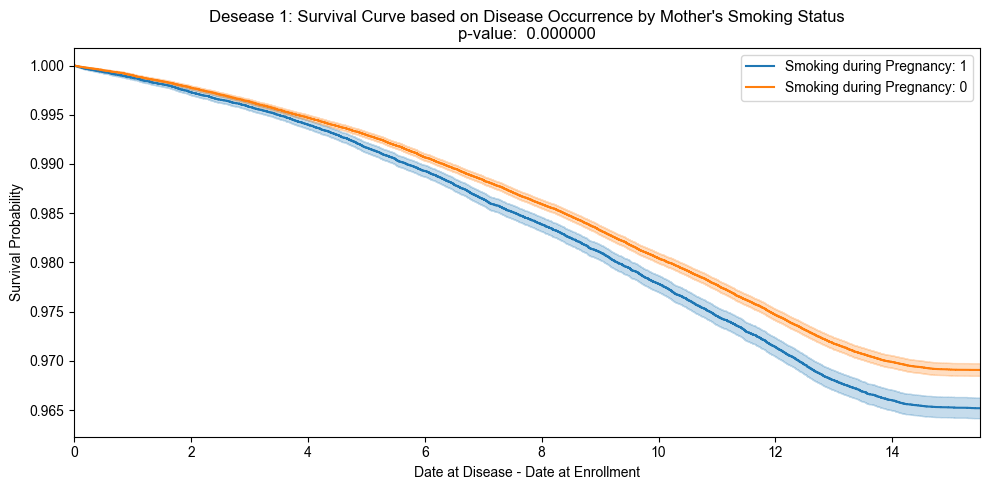

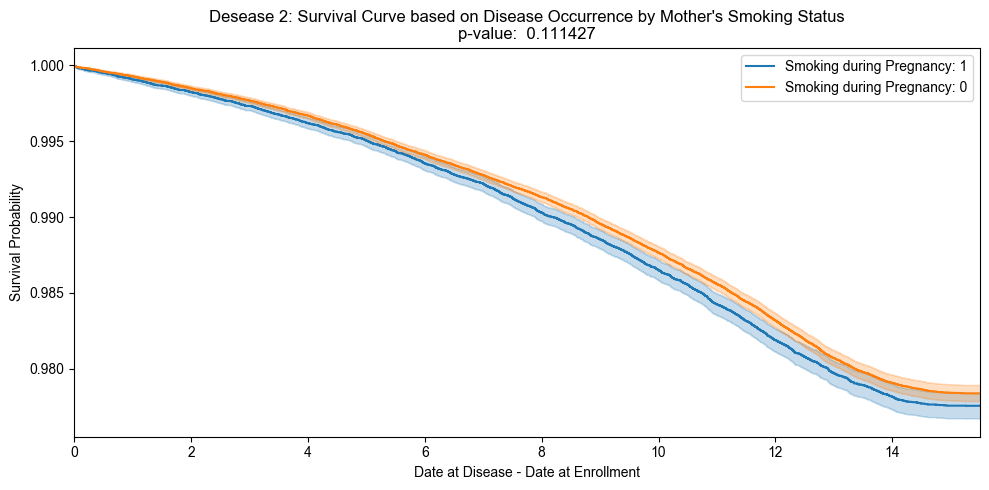

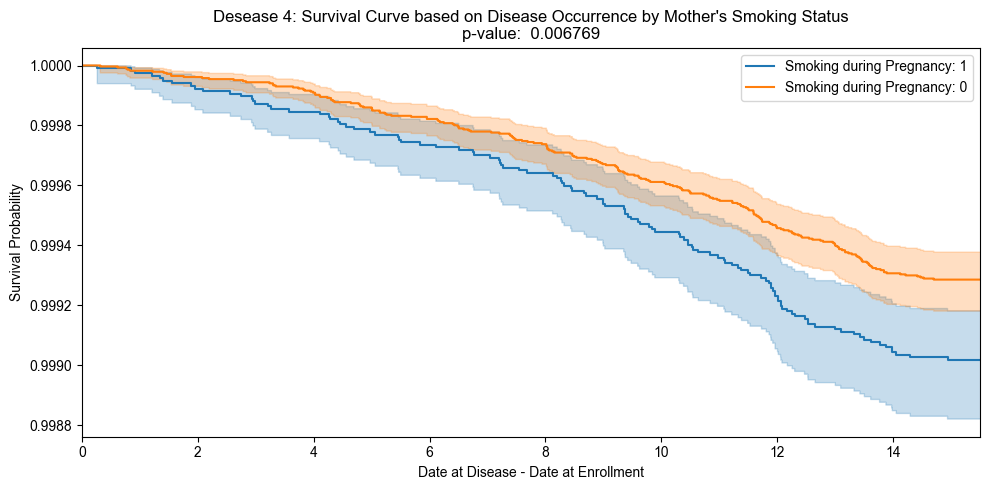

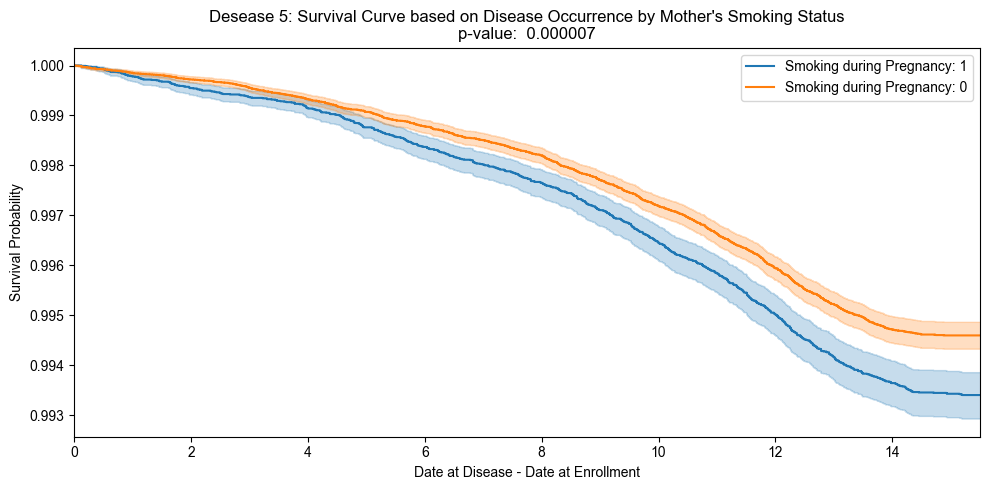

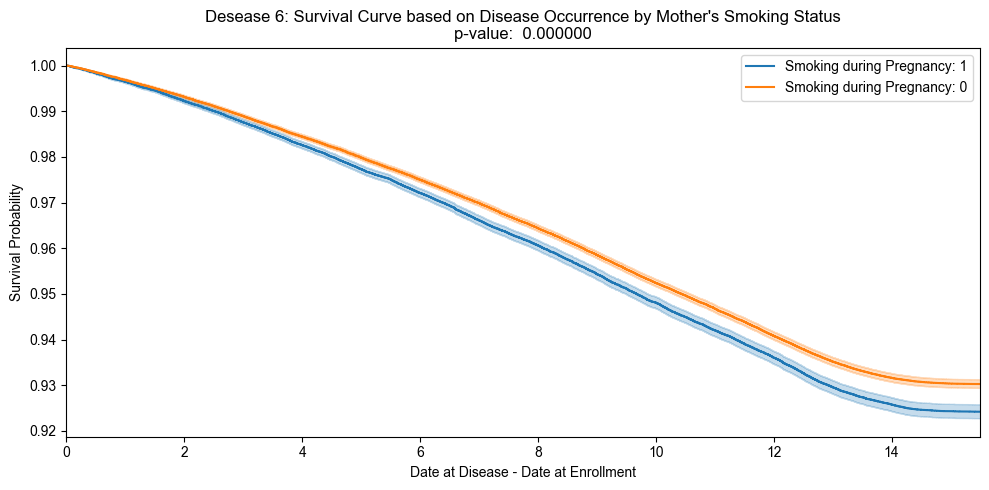

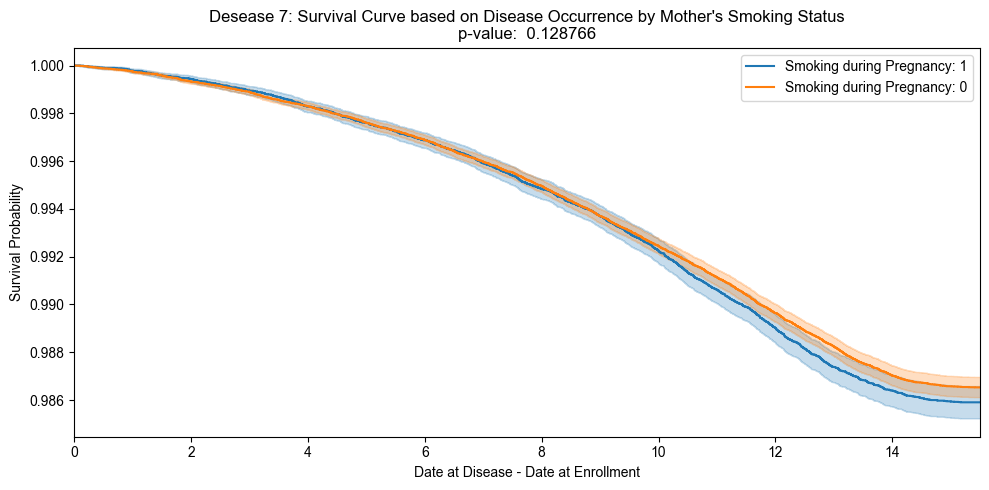

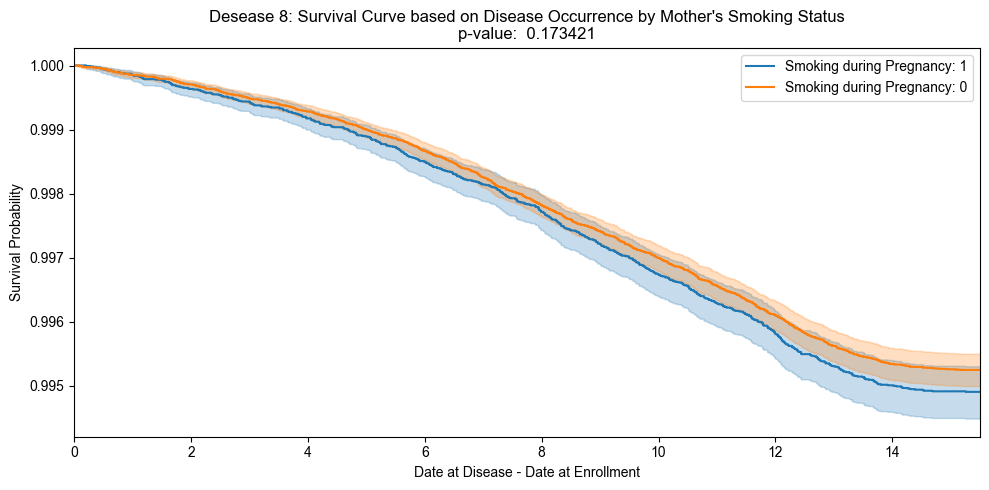

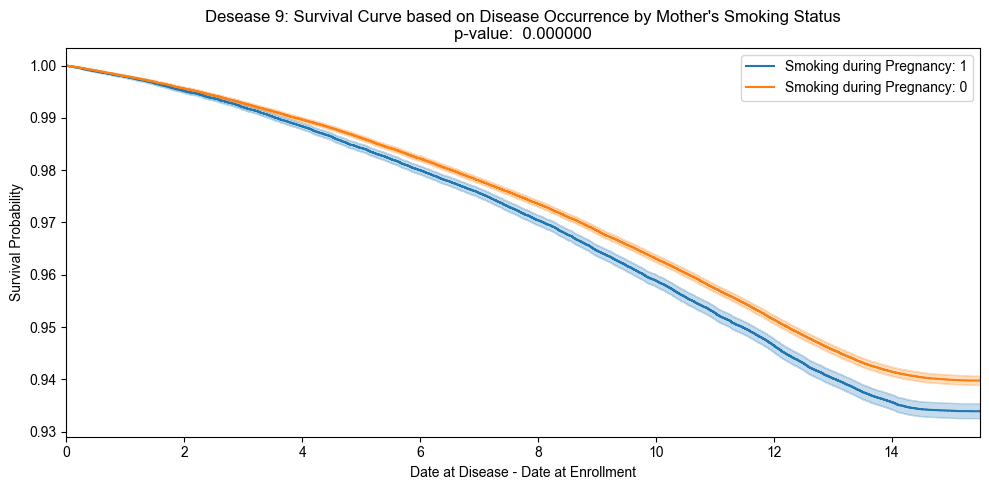

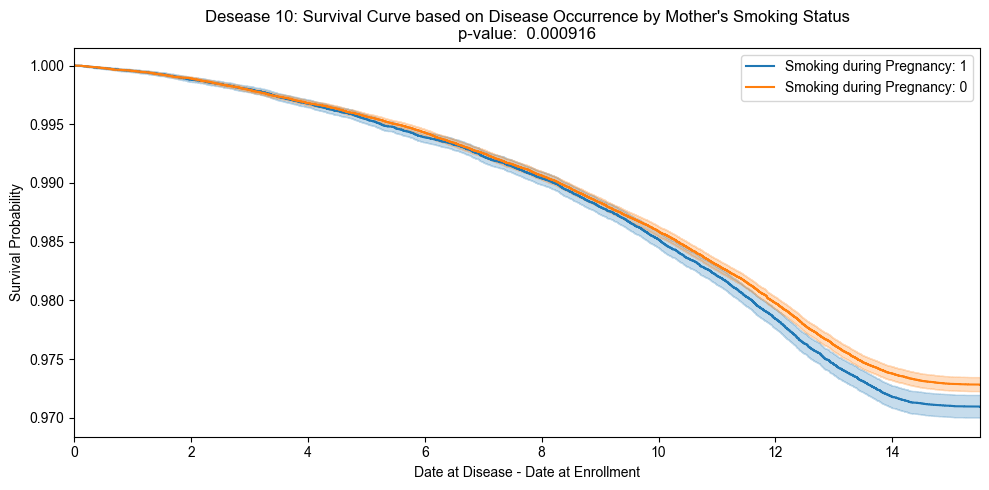

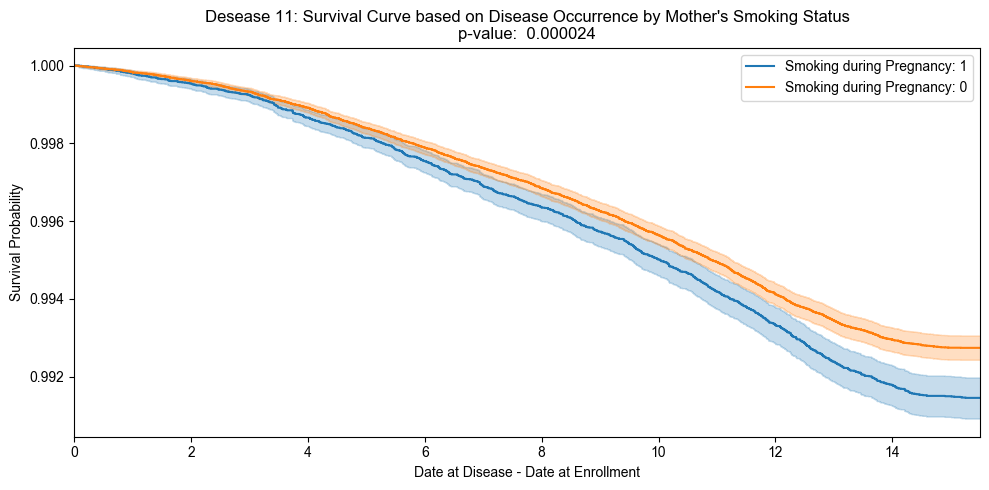

In [139]:
for i in range(1,12):
    if i == 3:
        continue
    plot_survival_curve(agg_survival[f'desease{i}'], i)

# 3. Cox regression



### 3.1 处理协变量

In [140]:
def check_condition(row):
    if pd.isnull(row['曾经吸烟']) and pd.isnull(row['目前吸烟']):
        return np.nan
    elif pd.isnull(row['曾经吸烟']) and row['目前吸烟'] == 0:
        return np.nan
    elif row['曾经吸烟'] == 0 and pd.isnull(row['目前吸烟']):
        return np.nan
    else:
        # 如果你有一个默认值或者一个基于其他列计算的值，可以在这里设置
        return row['吸烟_1'] # 或者是其他的逻辑

In [26]:
## 将协变量与之前处理过的疾病相关变量合并，inner join
cox_df = pd.merge(cov_df, merged_df.drop(['是否失访','母亲孕期吸烟', '失访日期-入组日期'],axis=1), on = '编号', how='inner')

## variables update
cox_df['中等活动时间'] = cox_df['中等活动时间'].apply(lambda x: np.nan if x in [-1, -3] else x)  # 剔除“不知道”，“不愿透露”
cox_df['种族'] = cox_df['种族'].apply(lambda x: np.nan if x in [-1, -3] else x)                 # 剔除“不知道”，“不愿透露”
cox_df['种族'] = cox_df['种族'].apply(lambda x: 'White' if x == 1 else x)                             # 白人=1，非白人=0
cox_df['种族'] = cox_df['种族'].apply(lambda x: 'Mixed' if x == 2 else x)
cox_df['种族'] = cox_df['种族'].apply(lambda x: 'Asian' if x == 3 else x)
cox_df['种族'] = cox_df['种族'].apply(lambda x: 'Black' if x == 4 else x)
cox_df['种族'] = cox_df['种族'].apply(lambda x: 'Other' if x not in ['White','Mixed','Asian','Black'] else x)
cox_df['饮酒情况'] = cox_df['饮酒情况'].apply(lambda x: 1 if x in [1,2,3] else x)                  # 每周饮酒 = 1
cox_df['饮酒情况'] = cox_df['饮酒情况'].apply(lambda x: 2 if x in [4,5] else x)                     # 偶尔饮酒 = 2
cox_df['饮酒情况'] = cox_df['饮酒情况'].apply(lambda x:0 if x == 6 else x)                          # 不饮酒 = 0
cox_df['饮酒情况'] = cox_df['饮酒情况'].apply(lambda x:np.nan if x == -3 else x)                    # 剔除“不知道”
cox_df['目前吸烟'] = cox_df['目前吸烟'].apply(lambda x:np.nan if x == -3 else x)                    # 剔除“不知道”
cox_df['曾经吸烟'] = cox_df['曾经吸烟'].apply(lambda x: np.nan if x == -3 else x)
cox_df['曾经吸烟'] = cox_df['曾经吸烟'].apply(lambda x: 0 if x in [3,4] else x)
cox_df['吸烟_1'] = ((cox_df['目前吸烟'].isin([1,2])) | (cox_df['曾经吸烟'].isin([1,2])))
cox_df['吸烟_1'] = cox_df.apply(check_condition, axis=1)
# cox_df['母亲孕期吸烟_吸烟_1'] = cox_df['母亲孕期吸烟'] * cox_df['吸烟_1']

# summary
desc_stats_cox = cox_df.describe(include='all')
missing_values_cox = pd.DataFrame(cox_df.isnull().sum(), columns=['missing_values'])
filter_covariants = missing_values_cox[missing_values_cox.values<200000]

# NA值在20w以内的变量
print(filter_covariants.loc[:'是否失访'])


            missing_values
X                        0
编号                       0
性别                       0
出生年份                     0
中等活动时间               19307
剧烈活动时间                   0
目前吸烟                   224
曾经吸烟                 30810
饮酒情况                   318
母亲孕期吸烟                   0
X4079.0.0                0
X4079.0.1            32753
X4080.0.0            27426
X4080.0.1            32757
种族                       0
BMI                   2008
体重                    1765
白细胞                  19195
血红蛋白                 19192
血小板                  19195
血蛋白                  57781
总胆固醇                 25877
肌酐                   26059
C反应蛋白                26686
空腹血糖                 58190
高密度胆固醇               57943
低密度胆固醇               26569
X30870.0.0           26161
X20143.0.0               0
X21022.0.0               0
出生年份.1                   0
入组年龄                     1
入组时间                     0
是否失访                     0


### 3.2 筛选协变量，drop NA

In [27]:
selected_cov_id = cox_df[['编号', '性别', '入组年龄', '中等活动时间', 'BMI', '饮酒情况', '母亲孕期吸烟', '吸烟_1', '高密度胆固醇', '低密度胆固醇', 'X30870.0.0']]
selected_cov = cox_df[['性别', '入组年龄', '中等活动时间', 'BMI', '饮酒情况', '母亲孕期吸烟', '吸烟_1', '高密度胆固醇', '低密度胆固醇', 'X30870.0.0']]
# 需要进行插补的变量
selected_cov.loc[selected_cov['高密度胆固醇'].isnull(), '高密度胆固醇'] = 'missing'
selected_cov.loc[selected_cov['低密度胆固醇'].isnull(), '低密度胆固醇'] = 'missing'
selected_cov.loc[selected_cov['X30870.0.0'].isnull(), 'X30870.0.0'] = 'missing'

selected_desease = cox_df.loc[:, '1是否发病':'11发病生存时间']
cov_filtered = pd.concat([selected_cov, selected_desease], axis=1)
cov_filtered = cov_filtered.dropna()
cov_filtered



,性别,入组年龄,中等活动时间,BMI,饮酒情况,母亲孕期吸烟,吸烟_1,高密度胆固醇,低密度胆固醇,X30870.0.0,...,7是否发病,7发病生存时间,8是否发病,8发病生存时间,9是否发病,9发病生存时间,10是否发病,10发病生存时间,11是否发病,11发病生存时间
0,0,58.0,1.0,28.3941,1.0,1.0,True,2.156,3.241,1.337,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
1,1,64.0,7.0,26.2188,1.0,1.0,False,missing,missing,missing,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
2,0,66.0,3.0,23.2869,2.0,0.0,False,missing,missing,missing,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
4,1,66.0,7.0,26.9402,0.0,0.0,False,1.044,2.301,1.505,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
5,0,42.0,7.0,27.3672,2.0,0.0,True,1.248,2.547,2.136,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403662,0,60.0,3.0,25.7632,1.0,0.0,False,1.476,5.046,1.217,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
403663,1,52.0,2.0,23.5286,1.0,0.0,False,1.378,3.312,1.909,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
403664,0,49.0,2.0,22.1563,1.0,0.0,True,missing,3.716,1.115,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0
403665,1,51.0,5.0,27.8438,1.0,0.0,True,1.374,4.13,1.455,...,0.0,100.0,0,100.0,0.0,100.0,0,100.0,0.0,100.0


### 3.3 处理协变量
##### 检查每个变量的值，其中 “中等活动时间” 为数量变量

In [28]:
for column in selected_cov:
    unique_values = cov_filtered[column].unique()
    print(f"{column} 的唯一值: {unique_values}")

性别 的唯一值: [0 1]
入组年龄 的唯一值: [58. 64. 66. 42. 57. 62. 61. 48. 63. 44. 65. 68. 67. 50. 54. 56. 69. 49.
 59. 60. 47. 46. 45. 43. 51. 55. 53. 41. 52. 40. 70. 72. 71. 39. 38. 73.]
中等活动时间 的唯一值: [1. 7. 3. 2. 5. 6. 4. 0.]
BMI 的唯一值: [28.3941 26.2188 23.2869 ... 38.7592 26.6175 30.8049]
饮酒情况 的唯一值: [1. 2. 0.]
母亲孕期吸烟 的唯一值: [1. 0.]
吸烟_1 的唯一值: [True False]
高密度胆固醇 的唯一值: [2.156 'missing' 1.044 ... 3.377 3.218 3.233]
低密度胆固醇 的唯一值: [3.241 'missing' 2.301 ... 6.342 7.311 1.192]
X30870.0.0 的唯一值: [1.337 'missing' 1.505 ... 6.86 6.767 8.63]


##### 将'性别', '种族', '饮酒情况', '目前吸烟'转换为categorical variables

In [29]:
# 进行独热编码
# '性别', '种族', '中等活动时间', '饮酒情况', '目前吸烟', '母亲孕期吸烟'
cox_df_encoded = pd.get_dummies(cov_filtered,
                                 columns=['性别', '饮酒情况'], drop_first=True)
cat_vars = pd.get_dummies(cov_filtered[selected_cov.columns],
                                 columns=['性别', '饮酒情况'], drop_first=True)
cat_vars

,入组年龄,中等活动时间,BMI,母亲孕期吸烟,吸烟_1,高密度胆固醇,低密度胆固醇,X30870.0.0,性别_1,饮酒情况_1.0,饮酒情况_2.0
0,58.0,1.0,28.3941,1.0,True,2.156,3.241,1.337,False,True,False
1,64.0,7.0,26.2188,1.0,False,missing,missing,missing,True,True,False
2,66.0,3.0,23.2869,0.0,False,missing,missing,missing,False,False,True
4,66.0,7.0,26.9402,0.0,False,1.044,2.301,1.505,True,False,False
5,42.0,7.0,27.3672,0.0,True,1.248,2.547,2.136,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
403662,60.0,3.0,25.7632,0.0,False,1.476,5.046,1.217,False,True,False
403663,52.0,2.0,23.5286,0.0,False,1.378,3.312,1.909,True,True,False
403664,49.0,2.0,22.1563,0.0,True,missing,3.716,1.115,False,True,False
403665,51.0,5.0,27.8438,0.0,True,1.374,4.13,1.455,True,True,False


### 3.5 Decision Tree插补 - 高密度胆固醇, 低密度胆固醇, 甘油三酯

#### 3.5.1 检验插补的准确度

In [30]:
## Step 1: 随机选择10%的非NA数据作为测试数据
cat_vars.replace('missing', np.nan, inplace=True)
# 转换布尔列为数值型
cat_vars['吸烟_1'] = cat_vars['吸烟_1'].astype(int)
cat_vars['性别_1'] = cat_vars['性别_1'].astype(int)
cat_vars['饮酒情况_1.0'] = cat_vars['饮酒情况_1.0'].astype(int)
cat_vars['饮酒情况_2.0'] = cat_vars['饮酒情况_2.0'].astype(int)
cat_vars_clean = cat_vars.dropna(subset=['高密度胆固醇', '低密度胆固醇', 'X30870.0.0'])
np.random.seed(42)
# 创建一个随机排列的布尔索引
msk = np.random.rand(len(cat_vars_clean)) < 0.9
# 10%作为测试集
test = cat_vars_clean[~msk]


## Step2：随机给test data中的以下列加入NA
columns_to_na = ['高密度胆固醇', '低密度胆固醇', 'X30870.0.0']
# 在test集中随机为指定列赋予NaN
np.random.seed(42)  # 设置随机种子以保持结果一致性
rs = 33
idx = {}
for col in columns_to_na:
    # 随机选择1索引赋予NaN
    indices = test.sample(frac=0.6, random_state=rs).index
    test.loc[indices, col] = np.nan
    rs = rs + 100
    idx[col] = indices
# 删除原始数据中现在的测试集部分
train_data = cat_vars_clean.drop(test.index)
# 将修改后的测试集合并回原数据集
updatedna_data = pd.concat([train_data, test])

## Step3: 插补数据
imputer = IterativeImputer(estimator=DecisionTreeRegressor(), max_iter=5, random_state=42)
imputed_data = imputer.fit_transform(updatedna_data)
imputed_data = pd.DataFrame(imputed_data, index=updatedna_data.index, columns=updatedna_data.columns)


插补数据对比真实数据histogram

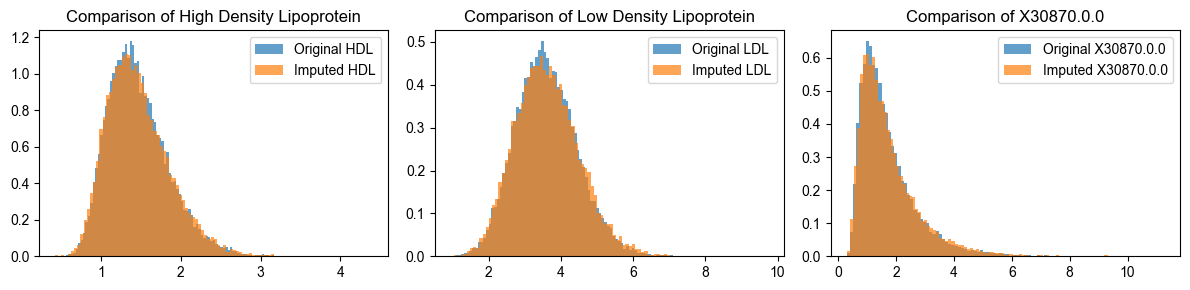

In [31]:
## Step4: 对比插补数据和真实数据
impute_HDL = imputed_data.loc[idx['高密度胆固醇'],'高密度胆固醇']
impute_LDL = imputed_data.loc[idx['低密度胆固醇'],'低密度胆固醇']
impute_x = imputed_data.loc[idx['X30870.0.0'],'X30870.0.0']
real_HDL = cat_vars_clean.loc[idx['高密度胆固醇'],'高密度胆固醇']
real_LDL = cat_vars_clean.loc[idx['低密度胆固醇'],'低密度胆固醇']
real_x = cat_vars_clean.loc[idx['X30870.0.0'],'X30870.0.0']

# 设置画布大小和分辨率
plt.figure(figsize=(12, 3))

# 高密度胆固醇对比图
plt.subplot(1, 3, 1)  # 1行3列，第1个
plt.hist(real_HDL, bins=100, alpha=0.7, label='Original HDL', density=True)
plt.hist(impute_HDL, bins=100, alpha=0.7, label='Imputed HDL', density=True)
plt.title('Comparison of High Density Lipoprotein')
plt.legend()

# 低密度胆固醇对比图
plt.subplot(1, 3, 2)  # 1行3列，第2个
plt.hist(real_LDL, bins=100, alpha=0.7, label='Original LDL', density=True)
plt.hist(impute_LDL, bins=100, alpha=0.7, label='Imputed LDL', density=True)
plt.title('Comparison of Low Density Lipoprotein')
plt.legend()

# X30870.0.0对比图
plt.subplot(1, 3, 3)  # 1行3列，第3个
plt.hist(real_x, bins=100, alpha=0.7, label='Original X30870.0.0', density=True)
plt.hist(impute_x, bins=100, alpha=0.7, label='Imputed X30870.0.0', density=True)
plt.title('Comparison of X30870.0.0')
plt.legend()

# 显示图表
plt.tight_layout()
plt.show()

插补数据对比真实数据 Mann-Whitney U test

In [32]:
# 对高密度胆固醇 (HDL) 进行 Mann-Whitney U 测试
u_stat_hdl, p_value_hdl = mannwhitneyu(real_HDL, impute_HDL, alternative='two-sided')
print(f"Mann-Whitney U test for High Density Lipoprotein (HDL): U-statistic = {u_stat_hdl}, P-value = {p_value_hdl}")

# 对低密度胆固醇 (LDL) 进行 Mann-Whitney U 测试
u_stat_ldl, p_value_ldl = mannwhitneyu(real_LDL, impute_LDL, alternative='two-sided')
print(f"Mann-Whitney U test for Low Density Lipoprotein (LDL): U-statistic = {u_stat_ldl}, P-value = {p_value_ldl}")

# 对 X30870.0.0 进行 Mann-Whitney U 测试
u_stat_x, p_value_x = mannwhitneyu(real_x, impute_x, alternative='two-sided')
print(f"Mann-Whitney U test for X30870.0.0: U-statistic = {u_stat_x}, P-value = {p_value_x}")

Mann-Whitney U test for High Density Lipoprotein (HDL): U-statistic = 190072411.5, P-value = 0.9258635726878783
Mann-Whitney U test for Low Density Lipoprotein (LDL): U-statistic = 188584455.0, P-value = 0.21267550420885406
Mann-Whitney U test for X30870.0.0: U-statistic = 187736728.5, P-value = 0.044508339535918956


#### 3.5.2 敏感性分析

In [33]:
# 准备IterativeImputer
imputer = IterativeImputer(estimator=DecisionTreeRegressor(), max_iter=5, random_state=42)

# 使用IterativeImputer插补缺失值
cat_vars_imputed = imputer.fit_transform(cat_vars)
cat_vars_imputed_df = pd.DataFrame(cat_vars_imputed, columns=cat_vars.columns)
cox_df_encoded['高密度胆固醇'] = np.array(cat_vars_imputed_df['高密度胆固醇'])
cox_df_encoded['低密度胆固醇'] = np.array(cat_vars_imputed_df['低密度胆固醇'])
cox_df_encoded['X30870.0.0'] = np.array(cat_vars_imputed_df['X30870.0.0'])

In [34]:
# 创建每种疾病做regression所需要的变量
## test cox reg
filter_dict = {}
for i in range(1,12):
    if i == 3:
        continue
    filter_dict[f'filter{i}'] = list(cat_vars.columns) + list(cov_filtered.loc[:,f'{i}是否发病':f'{i}发病生存时间'].columns)

regression

In [35]:
folder_path = '/Users/charlesxiong/Desktop/Yanxu-research/敏感性分析-LDL_HDL/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
NA_rows = cox_df_encoded[cat_vars[['高密度胆固醇', '低密度胆固醇', 'X30870.0.0']].isnull().any(axis=1)]
noNA_rows = cox_df_encoded[cat_vars[['高密度胆固醇', '低密度胆固醇', 'X30870.0.0']].notnull().all(axis=1)]

for i in range(1,12):
    if i == 3:
        continue
    NA_df = NA_rows[filter_dict[f'filter{i}']]
    noNA_df = noNA_rows[filter_dict[f'filter{i}']]
    NA_model = CoxPHFitter()
    noNA_model = CoxPHFitter()
    NA_result = NA_model.fit(NA_df, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    noNA_result = noNA_model.fit(noNA_df, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    file_path = os.path.join(folder_path, f'疾病{i}.txt')
    with open(file_path, 'w') as file:
        NA_string = NA_result.summary.to_string()
        noNA_string = noNA_result.summary.to_string()
        file.write(f'高/低密度胆固醇带有NA的回归 {i}:\n')
        file.write(NA_string)
        file.write('\n\n\n\n')
        file.write(f'高/低密度胆固醇不带有NA的回归 {i}:\n')
        file.write(noNA_string)

    pdf_path = os.path.join(folder_path, f'疾病{i}.pdf')
    with PdfPages(pdf_path) as pdf:
        plt.figure(figsize=(16, 5))
        plt.subplot(1, 2, 1)
        NA_model.plot()
        plt.title(f'含NA数据的疾病{i} Cox Regression\n样本数量: {len(NA_df)}')
        
        # 为不含NA的数据集绘制生存函数
        plt.subplot(1, 2, 2)
        noNA_model.plot()
        plt.title(f'不含NA数据的疾病{i} Cox Regression\n样本数量: {len(noNA_df)}')
        
        # 将图像添加到 PDF 文档中
        
        pdf.savefig()
        plt.close()

### Full model - desease 1

<lifelines.CoxPHFitter: fitted with 381315 total observations, 369381 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 11934
   partial log-likelihood = -149524.36
         time fit was run = 2024-04-18 14:03:17 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.06      1.06      0.00            0.06            0.06                1.06                1.07
中等活动时间     -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
BMI         0.03      1.03      0.00            0.03            0.03                1.03                1.03
母亲孕期吸烟      0.13      1.14      0.02            0.09            0.17                1.10                1.19
吸烟_1        0.29      1.34      0.02            0.26            0.33                1.29                1.39
高密度胆固醇     -0.50      0.60      0.04           -0.57           -0.44                0.56                0.65
低密度胆固醇      0.19      1.21      0.01            0.17            0.21                1.19                1.24
X30870.0.0  0.07      1.07      0.01            0.05            0.09                1.05                1.09
性别_1        0.85      2.33      0.02            0.80            0.89                2.23                2.44
饮酒情况_1.0   -0.41      0.66      0.03           -0.47           -0.35                0.62                0.71
饮酒情况_2.0   -0.15      0.86      0.04           -0.22           -0.08                0.80                0.92

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  47.74 <0.005       inf
中等活动时间        0.00  -0.20   0.84      0.25
BMI           0.00  14.33 <0.005    152.35
母亲孕期吸烟        0.00   6.66 <0.005     35.10
吸烟_1          0.00  15.64 <0.005    180.84
高密度胆固醇        0.00 -14.34 <0.005    152.54
低密度胆固醇        0.00  17.65 <0.005    229.09
X30870.0.0    0.00   7.92 <0.005     48.56
性别_1          0.00  37.93 <0.005       inf
饮酒情况_1.0      0.00 -12.64 <0.005    119.33
饮酒情况_2.0      0.00  -4.31 <0.005     15.93
---
Concordance = 0.72
Partial AIC = 299070.73
log-likelihood ratio test = 7259.72 on 11 df
-log2(p) of ll-ratio test = inf

C-index: 0.7178519065517296


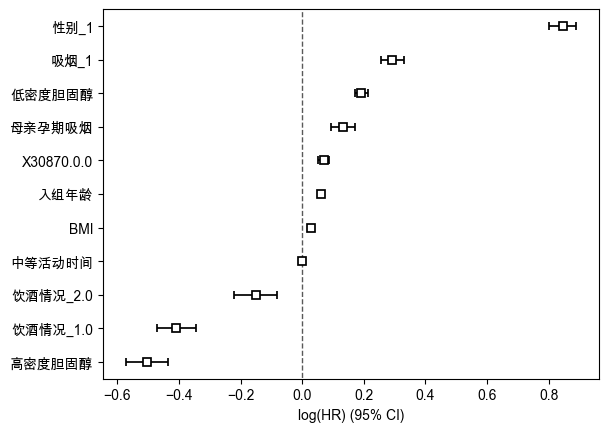

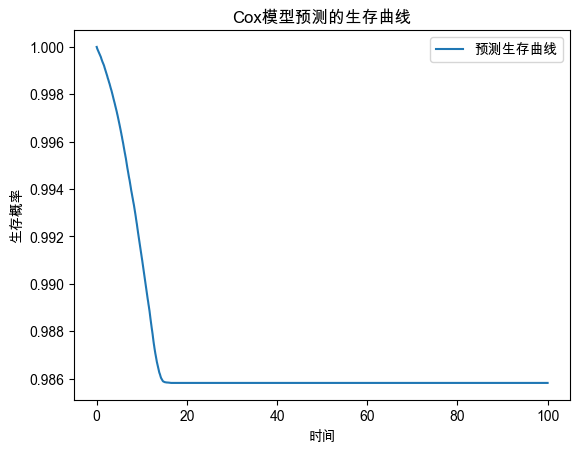

In [36]:
## test cox reg
filter_dict = {}
for i in range(1,12):
    if i == 3:
        continue
    filter_dict[f'filter{i}'] = list(cat_vars.columns) + list(cov_filtered.loc[:,f'{i}是否发病':f'{i}发病生存时间'].columns)

cox_filtered = cox_df_encoded[filter_dict['filter1']]
cox_model = CoxPHFitter()
cox_model.fit(cox_filtered, duration_col='1发病生存时间', event_col='1是否发病')
cox_model.print_summary()

c_index = cox_model.concordance_index_
print(f"C-index: {c_index}")

cox_model.plot()
plt.show()

# 假设我们想要为cov_filtered中的第一个观测绘制生存曲线
# 这仅是为了示例；实际上，你可能想要为特定的协变量值组合绘制生存曲线
observed_covariates = cox_filtered.iloc[:10000,:]

# 使用模型预测生存函数
predicted_survival = cox_model.predict_survival_function(observed_covariates)

# 绘制预测的生存曲线
plt.plot(predicted_survival.index, predicted_survival.iloc[:, 0], label='预测生存曲线')

plt.xlabel('时间')
plt.ylabel('生存概率')
plt.title('Cox模型预测的生存曲线')
plt.legend()
plt.show()


### Model 1 - 只包含母亲孕期吸烟

<lifelines.CoxPHFitter: fitted with 381315 total observations, 369381 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 11934
   partial log-likelihood = -153130.65
         time fit was run = 2024-04-18 14:03:22 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.14      1.15      0.02            0.10            0.17                1.10                1.19

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 6.93 <0.005     37.74
---
Concordance = 0.51
Partial AIC = 306263.29
log-likelihood ratio test = 47.16 on 1 df
-log2(p) of ll-ratio test = 37.15

C-index: 0.5144418432302874


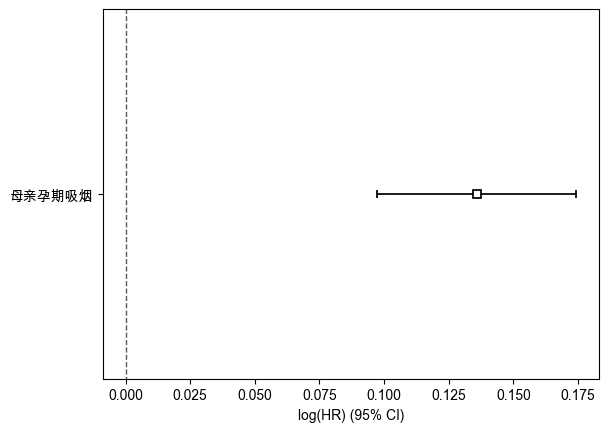

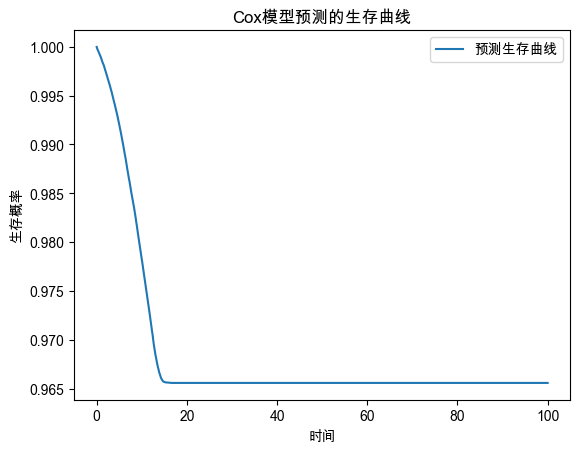

In [37]:
cox_1 = cox_df_encoded[filter_dict['filter1']][['1发病生存时间', '1是否发病', '母亲孕期吸烟']]
cox_model1 = CoxPHFitter()
cox_model1.fit(cox_1, duration_col='1发病生存时间', event_col='1是否发病')
cox_model1.print_summary()

c_index1 = cox_model1.concordance_index_
print(f"C-index: {c_index1}")

# 设置matplotlib配置参数以支持中文显示
mpl.rcParams['font.family'] = 'Arial Unicode MS'
cox_model1.plot()
plt.show()

# 假设我们想要为cov_filtered中的第一个观测绘制生存曲线
# 这仅是为了示例；实际上，你可能想要为特定的协变量值组合绘制生存曲线
observed_covariates1 = cox_1.iloc[:10000,:]

# 使用模型预测生存函数
predicted_survival1 = cox_model1.predict_survival_function(observed_covariates1)

# 绘制预测的生存曲线
plt.plot(predicted_survival1.index, predicted_survival1.iloc[:, 0], label='预测生存曲线')

plt.xlabel('时间')
plt.ylabel('生存概率')
plt.title('Cox模型预测的生存曲线')
plt.legend()
plt.show()

### Model 2 - 年龄， 性别， 种族，母亲孕期吸烟

<lifelines.CoxPHFitter: fitted with 381315 total observations, 369381 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 11934
   partial log-likelihood = -150477.46
         time fit was run = 2024-04-18 14:03:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.16      1.17      0.02            0.12            0.20                1.13                1.22
性别_1       0.97      2.64      0.02            0.93            1.01                2.54                2.74
入组年龄       0.06      1.06      0.00            0.06            0.06                1.06                1.07

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  8.18 <0.005     51.63
性别_1         0.00 49.67 <0.005       inf
入组年龄         0.00 48.20 <0.005       inf
---
Concordance = 0.69
Partial AIC = 300960.91
log-likelihood ratio test = 5353.53 on 3 df
-log2(p) of ll-ratio test = inf

C-index: 0.6899871399448566


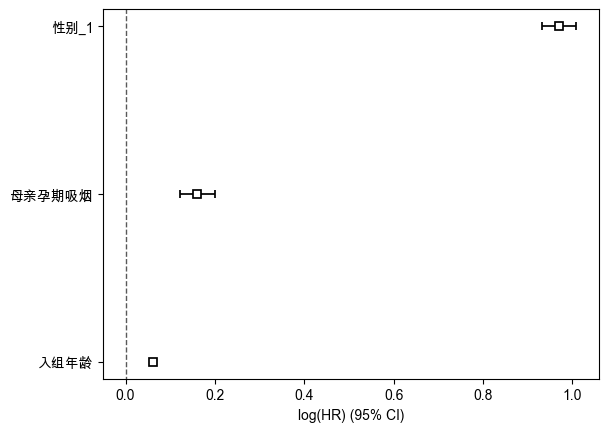

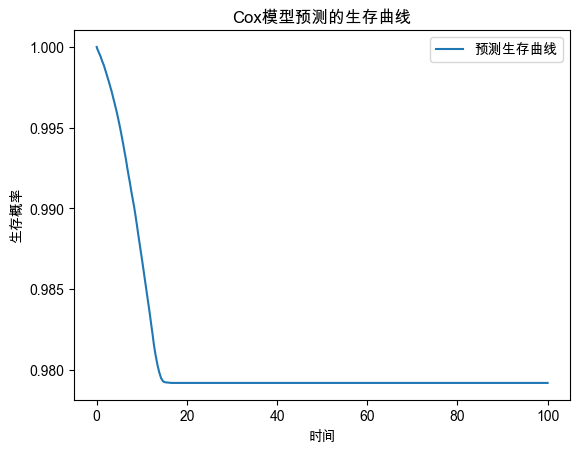

In [38]:
cox_2 = cox_df_encoded[filter_dict['filter1']][['1发病生存时间', '1是否发病', '母亲孕期吸烟', '性别_1', '入组年龄']]
cox_model2 = CoxPHFitter()
cox_model2.fit(cox_2, duration_col='1发病生存时间', event_col='1是否发病')
cox_model2.print_summary()

c_index2 = cox_model2.concordance_index_
print(f"C-index: {c_index2}")

# 设置matplotlib配置参数以支持中文显示
mpl.rcParams['font.family'] = 'Arial Unicode MS'
cox_model2.plot()
plt.show()

# 假设我们想要为cov_filtered中的第一个观测绘制生存曲线
# 这仅是为了示例；实际上，你可能想要为特定的协变量值组合绘制生存曲线
observed_covariates2 = cox_2.iloc[:10000,:]

# 使用模型预测生存函数
predicted_survival2 = cox_model2.predict_survival_function(observed_covariates2)

# 绘制预测的生存曲线
plt.plot(predicted_survival2.index, predicted_survival2.iloc[:, 0], label='预测生存曲线')

plt.xlabel('时间')
plt.ylabel('生存概率')
plt.title('Cox模型预测的生存曲线')
plt.legend()
plt.show()

## 3.4 HDL/LDL分组(废弃)

In [39]:
# list(selected_desease.columns)

In [40]:
# # add labels: HDL/LDL ratios
# # selected_cov_DL = cox_df_final[['性别', '入组年龄', '种族', '中等活动时间', 'BMI', '饮酒情况', '目前吸烟', '母亲孕期吸烟', '高密度胆固醇', '低密度胆固醇']]
# cov_filtered_DL = cox_df_final.loc[:,['性别', '入组年龄', '种族', '中等活动时间', 'BMI', '饮酒情况', '吸烟_1', '母亲孕期吸烟', '高密度胆固醇', '低密度胆固醇']+list(selected_desease.columns)]
# cov_filtered_DL.loc[:,'HDL/LDL'] = cov_filtered_DL['高密度胆固醇'] / cov_filtered_DL['低密度胆固醇']
# cov_filtered_DL['DL_ratio_group'] = cov_filtered_DL['HDL/LDL'].apply(lambda x: 'H' if x > 0.6 else ('L' if x < 0.4 else 'M'))
# cov_filtered_DL.loc[(cov_filtered_DL['高密度胆固醇'].isnull()) | (cov_filtered_DL['低密度胆固醇'].isnull()), 'DL_ratio_group'] = 'missing'

# # one-hot code
# cox_df_encoded_DL = pd.get_dummies(cov_filtered_DL,
#                                  columns=['性别', '种族', '饮酒情况', '目前吸烟'], drop_first=True)
# cat_vars_DL = pd.get_dummies(cov_filtered_DL[['性别', '入组年龄', '种族', '中等活动时间', 'BMI', '饮酒情况', '目前吸烟', '母亲孕期吸烟', '高密度胆固醇', '低密度胆固醇'] + ['DL_ratio_group']],
#                                  columns=['性别', '种族', '饮酒情况', '目前吸烟'], drop_first=True)
# cat_vars_DL


In [41]:
# ## test cox reg
# filter_dict_DL = {}
# for i in range(1,12):
#     if i == 3:
#         continue
#     filter_dict_DL[f'filter{i}'] = list(cat_vars_DL.columns) + list(cov_filtered_DL.loc[:,f'{i}是否发病':f'{i}发病生存时间'].columns)

# cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL['filter1']]
# cox_filtered_H = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'H'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
# cox_filtered_M = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'M'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
# cox_filtered_L = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'L'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
# cox_filtered_missing = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'missing'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)

### 3.4.1 
HDL/LDL > 0.6

In [42]:
# cox_model_H = CoxPHFitter()
# cox_model_H.fit(cox_filtered_H, duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_H.print_summary()

# c_index_H = cox_model_H.concordance_index_
# print(f"C-index: {c_index_H}")

# # # 设置matplotlib配置参数以支持中文显示
# # mpl.rcParams['font.family'] = 'Arial Unicode MS'
# # cox_model_H.plot()
# # plt.show()

In [43]:
# # Model 1
# cox_model_H = CoxPHFitter()
# cox_model_H.fit(cox_filtered_H[['1发病生存时间', '1是否发病', '母亲孕期吸烟']], duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_H.print_summary()

# c_index_H = cox_model_H.concordance_index_
# print(f"C-index: {c_index_H}")

# # # 设置matplotlib配置参数以支持中文显示
# # mpl.rcParams['font.family'] = 'Arial Unicode MS'
# # cox_model_H.plot()
# # plt.show()

In [44]:
# # Model 2
# cox_model_H = CoxPHFitter()
# cox_model_H.fit(cox_filtered_H[['1发病生存时间', '1是否发病', '母亲孕期吸烟', '性别_1', '种族_1', '入组年龄']], duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_H.print_summary()

# c_index_H = cox_model_H.concordance_index_
# print(f"C-index: {c_index_H}")

# # # 设置matplotlib配置参数以支持中文显示
# # mpl.rcParams['font.family'] = 'Arial Unicode MS'
# # cox_model_H.plot()
# # plt.show()

### 3.4.2    
0.4 <= HDL/LDL <= 0.6

In [45]:
# cox_model_M = CoxPHFitter()
# cox_model_M.fit(cox_filtered_M, duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_M.print_summary()

# c_index_M = cox_model_M.concordance_index_
# print(f"C-index: {c_index_M}")

# # # 设置matplotlib配置参数以支持中文显示
# # mpl.rcParams['font.family'] = 'Arial Unicode MS'
# # cox_model_M.plot()
# # plt.show()

In [46]:
# # Model 1
# cox_model_M = CoxPHFitter()
# cox_model_M.fit(cox_filtered_M[['1发病生存时间', '1是否发病', '母亲孕期吸烟']], duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_M.print_summary()

# c_index_M = cox_model_M.concordance_index_
# print(f"C-index: {c_index_M}")

# # # 设置matplotlib配置参数以支持中文显示
# # mpl.rcParams['font.family'] = 'Arial Unicode MS'
# # cox_model_M.plot()
# # plt.show()

In [47]:
# # Model 2
# cox_model_M = CoxPHFitter()
# cox_model_M.fit(cox_filtered_M[['1发病生存时间', '1是否发病', '母亲孕期吸烟', '性别_1', '种族_1', '入组年龄']], duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_M.print_summary()

# c_index_M = cox_model_M.concordance_index_
# print(f"C-index: {c_index_M}")

# # 设置matplotlib配置参数以支持中文显示
# mpl.rcParams['font.family'] = 'Arial Unicode MS'
# cox_model_M.plot()
# plt.show()

### 3.4.3    
HDL/LDL <= 0.4

In [48]:
# cox_model_L = CoxPHFitter()
# cox_model_L.fit(cox_filtered_L, duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_L.print_summary()

# c_index_L = cox_model_L.concordance_index_
# print(f"C-index: {c_index_L}")

# # 设置matplotlib配置参数以支持中文显示
# mpl.rcParams['font.family'] = 'Arial Unicode MS'
# cox_model_L.plot()
# plt.show()

In [49]:
# # Model 1
# cox_model_L = CoxPHFitter()
# cox_model_L.fit(cox_filtered_L[['1发病生存时间', '1是否发病', '母亲孕期吸烟']], duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_L.print_summary()

# c_index_L = cox_model_L.concordance_index_
# print(f"C-index: {c_index_L}")

# # 设置matplotlib配置参数以支持中文显示
# mpl.rcParams['font.family'] = 'Arial Unicode MS'
# cox_model_L.plot()
# plt.show()

In [50]:
# # Model 2
# cox_model_L = CoxPHFitter()
# cox_model_L.fit(cox_filtered_L[['1发病生存时间', '1是否发病', '母亲孕期吸烟', '性别_1', '种族_1', '入组年龄']], duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_L.print_summary()

# c_index_L = cox_model_L.concordance_index_
# print(f"C-index: {c_index_L}")

# # 设置matplotlib配置参数以支持中文显示
# mpl.rcParams['font.family'] = 'Arial Unicode MS'
# cox_model_L.plot()
# plt.show()

### 3.4.4    
HDL/LDL = missing

In [51]:
# cox_model_missing = CoxPHFitter()
# cox_model_missing.fit(cox_filtered_missing, duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_missing.print_summary()

# c_index_misisng = cox_model_missing.concordance_index_
# print(f"C-index: {c_index_misisng}")

# # 设置matplotlib配置参数以支持中文显示
# mpl.rcParams['font.family'] = 'Arial Unicode MS'
# cox_model_missing.plot()
# plt.show()

In [52]:
# # Model 1
# cox_model_missing = CoxPHFitter()
# cox_model_missing.fit(cox_filtered_missing[['1发病生存时间', '1是否发病', '母亲孕期吸烟']], duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_missing.print_summary()

# c_index_missing = cox_model_missing.concordance_index_
# print(f"C-index: {c_index_missing}")

# # 设置matplotlib配置参数以支持中文显示
# mpl.rcParams['font.family'] = 'Arial Unicode MS'
# cox_model_missing.plot()
# plt.show()

In [53]:
# # Model 2
# cox_model_missing = CoxPHFitter()
# cox_model_missing.fit(cox_filtered_missing[['1发病生存时间', '1是否发病', '母亲孕期吸烟', '性别_1', '种族_1', '入组年龄']], duration_col='1发病生存时间', event_col='1是否发病')
# cox_model_missing.print_summary()

# c_index_missing = cox_model_missing.concordance_index_
# print(f"C-index: {c_index_missing}")

# # 设置matplotlib配置参数以支持中文显示
# mpl.rcParams['font.family'] = 'Arial Unicode MS'
# cox_model_missing.plot()
# plt.show()

# A. 其他疾病结果 (1-11)


## Full model

In [54]:
folder_path = '/Users/charlesxiong/Desktop/Yanxu-research/cox regression/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for i in range(1,12):
    if i == 3:
        continue
    print(f"Full model results for desease {i}:")
    cox_filtered = cox_df_encoded[filter_dict[f'filter{i}']]
    cox_model = CoxPHFitter()
    cox_model.fit(cox_filtered, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model.print_summary()

    c_index = cox_model.concordance_index_
    print(f"C-index: {c_index}\n\n\n")

    pdf_path = os.path.join(folder_path, f'full model/疾病{i}.pdf')
    with PdfPages(pdf_path) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))  # Create a figure and axis to plot on.
        cox_model.plot(ax=ax)
        # plt.show()
        pdf.savefig(fig)  # Pass the figure explicitly here.
        plt.close(fig)  # Close the figure explicitly.

    # # 假设我们想要为cov_filtered中的第一个观测绘制生存曲线
    # # 这仅是为了示例；实际上，你可能想要为特定的协变量值组合绘制生存曲线
    # observed_covariates = cox_filtered.iloc[:10000,:]

    # # 使用模型预测生存函数
    # predicted_survival = cox_model.predict_survival_function(observed_covariates)

    # # 绘制预测的生存曲线
    # plt.plot(predicted_survival.index, predicted_survival.iloc[:, 0], label='预测生存曲线')

    # plt.xlabel('时间')
    # plt.ylabel('生存概率')
    # plt.title('Cox模型预测的生存曲线')
    # plt.legend()
    # plt.show()


Full model results for desease 1:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 369381 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 11934
   partial log-likelihood = -149524.36
         time fit was run = 2024-04-18 14:03:43 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.06      1.06      0.00            0.06            0.06                1.06                1.07
中等活动时间     -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
BMI         0.03      1.03      0.00            0.03            0.03                1.03                1.03
母亲孕期吸烟      0.13      1.14      0.02            0.09            0.17                1.10                1.19
吸烟_1        0.29      1.34      0.02            0.26            0.33                1.29                1.39
高密度胆固醇     -0.50      0.60      0.04           -0.57           -0.44                0.56                0.65
低密度胆固醇      0.19      1.21      0.01            0.17            0.21                1.19                1.24
X30870.0.0  0.07      1.07      0.01            0.05            0.09                1.05                1.09
性别_1        0.85      2.33      0.02            0.80            0.89                2.23                2.44
饮酒情况_1.0   -0.41      0.66      0.03           -0.47           -0.35                0.62                0.71
饮酒情况_2.0   -0.15      0.86      0.04           -0.22           -0.08                0.80                0.92

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  47.74 <0.005       inf
中等活动时间        0.00  -0.20   0.84      0.25
BMI           0.00  14.33 <0.005    152.35
母亲孕期吸烟        0.00   6.66 <0.005     35.10
吸烟_1          0.00  15.64 <0.005    180.84
高密度胆固醇        0.00 -14.34 <0.005    152.54
低密度胆固醇        0.00  17.65 <0.005    229.09
X30870.0.0    0.00   7.92 <0.005     48.56
性别_1          0.00  37.93 <0.005       inf
饮酒情况_1.0      0.00 -12.64 <0.005    119.33
饮酒情况_2.0      0.00  -4.31 <0.005     15.93
---
Concordance = 0.72
Partial AIC = 299070.73
log-likelihood ratio test = 7259.72 on 11 df
-log2(p) of ll-ratio test = inf

C-index: 0.7178519065517296



Full model results for desease 2:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 373164 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 8151
   partial log-likelihood = -102759.50
         time fit was run = 2024-04-18 14:03:47 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.08      1.09      0.00            0.08            0.09                1.08                1.09
中等活动时间      0.01      1.01      0.00            0.00            0.02                1.00                1.02
BMI         0.02      1.02      0.00            0.01            0.02                1.01                1.02
母亲孕期吸烟      0.09      1.09      0.02            0.04            0.14                1.04                1.15
吸烟_1        0.20      1.22      0.02            0.15            0.24                1.17                1.27
高密度胆固醇     -0.11      0.90      0.04           -0.18           -0.03                0.83                0.97
低密度胆固醇     -0.02      0.98      0.01           -0.05            0.01                0.96                1.01
X30870.0.0  0.02      1.02      0.01           -0.01            0.04                0.99                1.04
性别_1        0.37      1.44      0.03            0.32            0.42                1.37                1.52
饮酒情况_1.0   -0.31      0.73      0.04           -0.39           -0.23                0.68                0.79
饮酒情况_2.0   -0.18      0.84      0.04           -0.26           -0.09                0.77                0.91

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 50.09 <0.005       inf
中等活动时间        0.00  2.75   0.01      7.39
BMI           0.00  7.24 <0.005     40.98
母亲孕期吸烟        0.00  3.69 <0.005     12.11
吸烟_1          0.00  8.78 <0.005     59.09
高密度胆固醇        0.00 -2.82 <0.005      7.70
低密度胆固醇        0.00 -1.46   0.14      2.79
X30870.0.0    0.00  1.47   0.14      2.81
性别_1          0.00 14.25 <0.005    150.70
饮酒情况_1.0      0.00 -7.93 <0.005     48.72
饮酒情况_2.0      0.00 -4.10 <0.005     14.58
---
Concordance = 0.69
Partial AIC = 205541.00
log-likelihood ratio test = 3773.35 on 11 df
-log2(p) of ll-ratio test = inf

C-index: 0.6911527643488775



Full model results for desease 4:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 381010 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 305
   partial log-likelihood = -3802.21
         time fit was run = 2024-04-18 14:03:51 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.07      1.07      0.01            0.05            0.09                1.05                1.09
中等活动时间      0.02      1.02      0.02           -0.03            0.06                0.97                1.07
BMI         0.03      1.03      0.01            0.01            0.06                1.01                1.06
母亲孕期吸烟      0.37      1.44      0.12            0.13            0.60                1.14                1.82
吸烟_1        0.22      1.24      0.12           -0.01            0.45                0.99                1.56
高密度胆固醇     -0.32      0.73      0.21           -0.73            0.10                0.48                1.10
低密度胆固醇     -0.17      0.85      0.07           -0.31           -0.03                0.74                0.97
X30870.0.0 -0.05      0.96      0.06           -0.17            0.08                0.85                1.08
性别_1        1.14      3.12      0.15            0.85            1.43                2.34                4.16
饮酒情况_1.0   -0.10      0.90      0.22           -0.54            0.34                0.58                1.40
饮酒情况_2.0   -0.08      0.93      0.25           -0.56            0.41                0.57                1.50

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00  8.36 <0.005     53.83
中等活动时间        0.00  0.62   0.53      0.90
BMI           0.00  2.37   0.02      5.82
母亲孕期吸烟        0.00  3.07 <0.005      8.88
吸烟_1          0.00  1.84   0.07      3.94
高密度胆固醇        0.00 -1.50   0.13      2.91
低密度胆固醇        0.00 -2.33   0.02      5.66
X30870.0.0    0.00 -0.72   0.47      1.09
性别_1          0.00  7.72 <0.005     46.25
饮酒情况_1.0      0.00 -0.46   0.65      0.63
饮酒情况_2.0      0.00 -0.31   0.76      0.40
---
Concordance = 0.75
Partial AIC = 7626.42
log-likelihood ratio test = 233.35 on 11 df
-log2(p) of ll-ratio test = 143.08

C-index: 0.7450616891448608



Full model results for desease 5:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 379189 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 2126
   partial log-likelihood = -26322.34
         time fit was run = 2024-04-18 14:03:53 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.10      1.10      0.00            0.09            0.10                1.09                1.11
中等活动时间      0.00      1.00      0.01           -0.02            0.02                0.98                1.02
BMI         0.01      1.01      0.01           -0.00            0.02                1.00                1.02
母亲孕期吸烟      0.22      1.25      0.05            0.13            0.31                1.14                1.37
吸烟_1        0.94      2.55      0.05            0.84            1.03                2.33                2.81
高密度胆固醇     -0.28      0.76      0.08           -0.43           -0.13                0.65                0.88
低密度胆固醇     -0.08      0.93      0.03           -0.13           -0.03                0.88                0.97
X30870.0.0  0.13      1.14      0.02            0.09            0.17                1.10                1.19
性别_1        0.47      1.60      0.05            0.37            0.57                1.45                1.77
饮酒情况_1.0   -0.54      0.58      0.07           -0.69           -0.40                0.50                0.67
饮酒情况_2.0   -0.27      0.77      0.08           -0.42           -0.11                0.65                0.90

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 27.93 <0.005    567.88
中等活动时间        0.00  0.00   1.00      0.00
BMI           0.00  1.85   0.06      3.96
母亲孕期吸烟        0.00  4.81 <0.005     19.34
吸烟_1          0.00 19.56 <0.005    280.59
高密度胆固醇        0.00 -3.56 <0.005     11.39
低密度胆固醇        0.00 -2.98 <0.005      8.46
X30870.0.0    0.00  6.60 <0.005     34.49
性别_1          0.00  9.18 <0.005     64.38
饮酒情况_1.0      0.00 -7.33 <0.005     41.95
饮酒情况_2.0      0.00 -3.31 <0.005     10.06
---
Concordance = 0.76
Partial AIC = 52666.67
log-likelihood ratio test = 1978.05 on 11 df
-log2(p) of ll-ratio test = inf

C-index: 0.7630225736735504



Full model results for desease 6:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 354626 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 26689
   partial log-likelihood = -334009.52
         time fit was run = 2024-04-18 14:03:56 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.07      1.07      0.00            0.07            0.07                1.07                1.08
中等活动时间     -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
BMI         0.04      1.04      0.00            0.04            0.04                1.04                1.04
母亲孕期吸烟      0.09      1.10      0.01            0.07            0.12                1.07                1.13
吸烟_1        0.26      1.29      0.01            0.23            0.28                1.26                1.32
高密度胆固醇     -0.39      0.68      0.02           -0.44           -0.35                0.65                0.71
低密度胆固醇      0.05      1.05      0.01            0.03            0.06                1.03                1.06
X30870.0.0  0.06      1.06      0.01            0.05            0.07                1.05                1.08
性别_1        0.73      2.08      0.01            0.70            0.76                2.02                2.14
饮酒情况_1.0   -0.34      0.71      0.02           -0.38           -0.30                0.68                0.74
饮酒情况_2.0   -0.15      0.86      0.02           -0.19           -0.10                0.82                0.90

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  80.73 <0.005       inf
中等活动时间        0.00  -0.58   0.56      0.83
BMI           0.00  29.59 <0.005    636.61
母亲孕期吸烟        0.00   6.94 <0.005     37.88
吸烟_1          0.00  20.39 <0.005    304.72
高密度胆固醇        0.00 -17.12 <0.005    215.90
低密度胆固醇        0.00   6.16 <0.005     30.37
X30870.0.0    0.00  10.02 <0.005     76.16
性别_1          0.00  49.93 <0.005       inf
饮酒情况_1.0      0.00 -15.48 <0.005    177.21
饮酒情况_2.0      0.00  -6.19 <0.005     30.63
---
Concordance = 0.72
Partial AIC = 668041.04
log-likelihood ratio test = 15940.05 on 11 df
-log2(p) of ll-ratio test = inf

C-index: 0.7167842114596792



Full model results for desease 7:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 376200 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 5115
   partial log-likelihood = -63493.38
         time fit was run = 2024-04-18 14:04:01 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.11      1.12      0.00            0.11            0.12                1.12                1.13
中等活动时间      0.01      1.01      0.01           -0.00            0.02                1.00                1.02
BMI         0.07      1.07      0.00            0.06            0.08                1.07                1.08
母亲孕期吸烟      0.08      1.08      0.03            0.02            0.14                1.02                1.15
吸烟_1        0.17      1.18      0.03            0.11            0.23                1.12                1.25
高密度胆固醇      0.01      1.01      0.05           -0.08            0.11                0.92                1.12
低密度胆固醇     -0.02      0.98      0.02           -0.05            0.02                0.95                1.02
X30870.0.0  0.03      1.03      0.01           -0.00            0.06                1.00                1.06
性别_1        0.55      1.73      0.03            0.49            0.61                1.62                1.85
饮酒情况_1.0   -0.25      0.78      0.05           -0.35           -0.15                0.70                0.86
饮酒情况_2.0   -0.07      0.93      0.05           -0.18            0.03                0.84                1.03

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 48.73 <0.005       inf
中等活动时间        0.00  1.69   0.09      3.46
BMI           0.00 24.86 <0.005    450.69
母亲孕期吸烟        0.00  2.63   0.01      6.89
吸烟_1          0.00  5.91 <0.005     28.16
高密度胆固醇        0.00  0.26   0.79      0.34
低密度胆固醇        0.00 -0.98   0.33      1.61
X30870.0.0    0.00  1.95   0.05      4.29
性别_1          0.00 16.69 <0.005    205.25
饮酒情况_1.0      0.00 -5.02 <0.005     20.87
饮酒情况_2.0      0.00 -1.35   0.18      2.49
---
Concordance = 0.75
Partial AIC = 127008.77
log-likelihood ratio test = 4391.03 on 11 df
-log2(p) of ll-ratio test = inf

C-index: 0.7536157774762446



Full model results for desease 8:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 379507 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 1808
   partial log-likelihood = -23023.23
         time fit was run = 2024-04-18 14:04:05 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.05      1.05      0.00            0.04            0.05                1.04                1.05
中等活动时间      0.00      1.00      0.01           -0.02            0.02                0.98                1.02
BMI         0.04      1.04      0.01            0.03            0.05                1.03                1.05
母亲孕期吸烟      0.09      1.09      0.05           -0.01            0.19                0.99                1.21
吸烟_1        0.17      1.18      0.05            0.07            0.26                1.08                1.30
高密度胆固醇      0.07      1.08      0.08           -0.08            0.23                0.92                1.26
低密度胆固醇     -0.11      0.90      0.03           -0.16           -0.05                0.85                0.95
X30870.0.0  0.04      1.04      0.03           -0.01            0.09                0.99                1.09
性别_1        0.35      1.42      0.05            0.24            0.46                1.28                1.58
饮酒情况_1.0   -0.15      0.86      0.09           -0.32            0.03                0.73                1.03
饮酒情况_2.0   -0.08      0.92      0.10           -0.27            0.11                0.76                1.11

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 14.18 <0.005    149.13
中等活动时间        0.00  0.03   0.97      0.04
BMI           0.00  7.51 <0.005     43.93
母亲孕期吸烟        0.00  1.74   0.08      3.62
吸烟_1          0.00  3.52 <0.005     11.18
高密度胆固醇        0.00  0.94   0.35      1.52
低密度胆固醇        0.00 -3.77 <0.005     12.57
X30870.0.0    0.00  1.54   0.12      3.02
性别_1          0.00  6.48 <0.005     33.34
饮酒情况_1.0      0.00 -1.66   0.10      3.38
饮酒情况_2.0      0.00 -0.86   0.39      1.36
---
Concordance = 0.63
Partial AIC = 46068.47
log-likelihood ratio test = 407.77 on 11 df
-log2(p) of ll-ratio test = 265.30

C-index: 0.6339449323631997



Full model results for desease 9:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 358078 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 23237
   partial log-likelihood = -289077.58
         time fit was run = 2024-04-18 14:04:08 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.10      1.11      0.00            0.10            0.11                1.11                1.11
中等活动时间      0.01      1.01      0.00            0.00            0.01                1.00                1.01
BMI         0.06      1.06      0.00            0.06            0.07                1.06                1.07
母亲孕期吸烟      0.14      1.15      0.01            0.11            0.16                1.11                1.18
吸烟_1        0.14      1.15      0.01            0.11            0.16                1.12                1.18
高密度胆固醇      0.09      1.10      0.02            0.05            0.14                1.05                1.15
低密度胆固醇     -0.12      0.89      0.01           -0.14           -0.10                0.87                0.90
X30870.0.0 -0.05      0.95      0.01           -0.07           -0.04                0.94                0.96
性别_1        0.60      1.81      0.02            0.57            0.63                1.76                1.87
饮酒情况_1.0   -0.04      0.96      0.03           -0.09            0.01                0.92                1.01
饮酒情况_2.0   -0.04      0.96      0.03           -0.10            0.01                0.91                1.01

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  99.16 <0.005       inf
中等活动时间        0.00   3.25 <0.005      9.77
BMI           0.00  45.60 <0.005       inf
母亲孕期吸烟        0.00   9.57 <0.005     69.61
吸烟_1          0.00  10.14 <0.005     77.89
高密度胆固醇        0.00   4.17 <0.005     14.98
低密度胆固醇        0.00 -15.01 <0.005    166.77
X30870.0.0    0.00  -6.65 <0.005     35.01
性别_1          0.00  38.63 <0.005       inf
饮酒情况_1.0      0.00  -1.49   0.14      2.87
饮酒情况_2.0      0.00  -1.55   0.12      3.04
---
Concordance = 0.74
Partial AIC = 578177.15
log-likelihood ratio test = 17553.74 on 11 df
-log2(p) of ll-ratio test = inf

C-index: 0.7391768697110424



Full model results for desease 10:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 371150 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 10165
   partial log-likelihood = -126019.11
         time fit was run = 2024-04-18 14:04:12 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.10      1.11      0.00            0.10            0.11                1.11                1.11
中等活动时间     -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
BMI         0.08      1.08      0.00            0.08            0.08                1.08                1.09
母亲孕期吸烟      0.09      1.10      0.02            0.05            0.14                1.05                1.15
吸烟_1        0.30      1.35      0.02            0.26            0.34                1.29                1.40
高密度胆固醇      0.01      1.01      0.04           -0.06            0.08                0.94                1.08
低密度胆固醇     -0.13      0.88      0.01           -0.16           -0.11                0.86                0.90
X30870.0.0  0.01      1.01      0.01           -0.01            0.03                0.99                1.03
性别_1        0.54      1.72      0.02            0.50            0.59                1.65                1.80
饮酒情况_1.0   -0.42      0.66      0.03           -0.49           -0.35                0.62                0.70
饮酒情况_2.0   -0.19      0.83      0.04           -0.26           -0.12                0.77                0.89

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  64.82 <0.005       inf
中等活动时间        0.00  -1.08   0.28      1.83
BMI           0.00  41.29 <0.005       inf
母亲孕期吸烟        0.00   4.35 <0.005     16.17
吸烟_1          0.00  14.57 <0.005    157.23
高密度胆固醇        0.00   0.32   0.75      0.42
低密度胆固醇        0.00 -11.01 <0.005     91.18
X30870.0.0    0.00   1.20   0.23      2.13
性别_1          0.00  23.24 <0.005    394.38
饮酒情况_1.0      0.00 -12.29 <0.005    112.90
饮酒情况_2.0      0.00  -5.15 <0.005     21.85
---
Concordance = 0.75
Partial AIC = 252060.21
log-likelihood ratio test = 8910.28 on 11 df
-log2(p) of ll-ratio test = inf

C-index: 0.7533751899418404



Full model results for desease 11:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 378444 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 2871
   partial log-likelihood = -35254.30
         time fit was run = 2024-04-18 14:04:16 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.10      1.11      0.00            0.09            0.11                1.10                1.11
中等活动时间     -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
BMI         0.01      1.01      0.00            0.01            0.02                1.01                1.02
母亲孕期吸烟      0.21      1.23      0.04            0.13            0.28                1.14                1.33
吸烟_1        0.65      1.92      0.04            0.57            0.73                1.77                2.07
高密度胆固醇     -0.55      0.57      0.07           -0.69           -0.41                0.50                0.66
低密度胆固醇      0.08      1.08      0.02            0.04            0.12                1.04                1.13
X30870.0.0  0.01      1.01      0.02           -0.03            0.05                0.97                1.05
性别_1        1.19      3.29      0.05            1.09            1.29                2.99                3.63
饮酒情况_1.0   -0.04      0.96      0.08           -0.19            0.11                0.83                1.12
饮酒情况_2.0    0.01      1.01      0.08           -0.15            0.18                0.86                1.20

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 33.60 <0.005    819.60
中等活动时间        0.00 -0.01   0.99      0.01
BMI           0.00  3.25 <0.005      9.78
母亲孕期吸烟        0.00  5.16 <0.005     21.99
吸烟_1          0.00 16.31 <0.005    196.31
高密度胆固醇        0.00 -7.76 <0.005     46.76
低密度胆固醇        0.00  3.57 <0.005     11.43
X30870.0.0    0.00  0.50   0.62      0.69
性别_1          0.00 24.06 <0.005    422.33
饮酒情况_1.0      0.00 -0.49   0.62      0.68
饮酒情况_2.0      0.00  0.18   0.86      0.22
---
Concordance = 0.79
Partial AIC = 70530.60
log-likelihood ratio test = 3250.01 on 11 df
-log2(p) of ll-ratio test = inf

C-index: 0.7854943881253473





## Model 1

In [55]:
folder_path = '/Users/charlesxiong/Desktop/Yanxu-research/cox regression/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
for i in range(1,12):
    if i == 3:
        continue
    print(f"Model 1 results for desease {i}:")
    cox_1 = cox_df_encoded[filter_dict[f'filter{i}']][[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟']]
    cox_model1 = CoxPHFitter()
    cox_model1.fit(cox_1, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model1.print_summary()

    c_index1 = cox_model1.concordance_index_
    print(f"C-index: {c_index1}\n\n\n")

    pdf_path = os.path.join(folder_path, f'model1/疾病{i}.pdf')
    with PdfPages(pdf_path) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))  # Create a figure and axis to plot on.
        cox_model1.plot(ax=ax)
        # plt.show()
        pdf.savefig(fig)  # Pass the figure explicitly here.
        plt.close(fig)
    # # 设置matplotlib配置参数以支持中文显示
    # mpl.rcParams['font.family'] = 'Arial Unicode MS'
    # cox_model1.plot()
    # plt.show()

    # # 假设我们想要为cov_filtered中的第一个观测绘制生存曲线
    # # 这仅是为了示例；实际上，你可能想要为特定的协变量值组合绘制生存曲线
    # observed_covariates1 = cox_1.iloc[:10000,:]

    # # 使用模型预测生存函数
    # predicted_survival1 = cox_model1.predict_survival_function(observed_covariates1)

    # # 绘制预测的生存曲线
    # plt.plot(predicted_survival1.index, predicted_survival1.iloc[:, 0], label='预测生存曲线')

    # plt.xlabel('时间')
    # plt.ylabel('生存概率')
    # plt.title('Cox模型预测的生存曲线')
    # plt.legend()
    # plt.show()

Model 1 results for desease 1:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 369381 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 11934
   partial log-likelihood = -153130.65
         time fit was run = 2024-04-18 14:04:20 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.14      1.15      0.02            0.10            0.17                1.10                1.19

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 6.93 <0.005     37.74
---
Concordance = 0.51
Partial AIC = 306263.29
log-likelihood ratio test = 47.16 on 1 df
-log2(p) of ll-ratio test = 37.15

C-index: 0.5144418432302874



Model 1 results for desease 2:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 373164 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 8151
   partial log-likelihood = -104644.49
         time fit was run = 2024-04-18 14:04:27 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.04      1.05      0.02           -0.00            0.09                1.00                1.10

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 1.84 0.07      3.94
---
Concordance = 0.50
Partial AIC = 209290.98
log-likelihood ratio test = 3.38 on 1 df
-log2(p) of ll-ratio test = 3.92

C-index: 0.5046965871088982



Model 1 results for desease 4:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 381010 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 305
   partial log-likelihood = -3914.50
         time fit was run = 2024-04-18 14:04:35 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.36      1.43      0.12            0.13            0.59                1.13                1.80

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 3.02 <0.005      8.61
---
Concordance = 0.54
Partial AIC = 7830.99
log-likelihood ratio test = 8.78 on 1 df
-log2(p) of ll-ratio test = 8.36

C-index: 0.5394643408736196



Model 1 results for desease 5:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 379189 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 2126
   partial log-likelihood = -27303.29
         time fit was run = 2024-04-18 14:04:42 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.19      1.21      0.05            0.10            0.28                1.10                1.32

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 4.06 <0.005     14.34
---
Concordance = 0.52
Partial AIC = 54608.57
log-likelihood ratio test = 16.15 on 1 df
-log2(p) of ll-ratio test = 14.06

C-index: 0.5200644027507486



Model 1 results for desease 6:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 354626 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 26689
   partial log-likelihood = -341956.38
         time fit was run = 2024-04-18 14:04:49 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.09      1.09      0.01            0.06            0.12                1.07                1.12

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 6.85 <0.005     36.94
---
Concordance = 0.51
Partial AIC = 683914.77
log-likelihood ratio test = 46.32 on 1 df
-log2(p) of ll-ratio test = 36.53

C-index: 0.5095559102250736



Model 1 results for desease 7:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 376200 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 5115
   partial log-likelihood = -65687.87
         time fit was run = 2024-04-18 14:04:57 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.04      1.04      0.03           -0.02            0.10                0.98                1.11

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 1.44 0.15      2.72
---
Concordance = 0.50
Partial AIC = 131377.75
log-likelihood ratio test = 2.05 on 1 df
-log2(p) of ll-ratio test = 2.71

C-index: 0.5045563677016554



Model 1 results for desease 8:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 379507 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 1808
   partial log-likelihood = -23225.42
         time fit was run = 2024-04-18 14:05:04 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.09      1.10      0.05           -0.01            0.19                0.99                1.21

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 1.85 0.06      3.97
---
Concordance = 0.51
Partial AIC = 46452.85
log-likelihood ratio test = 3.39 on 1 df
-log2(p) of ll-ratio test = 3.93

C-index: 0.5099101053720686



Model 1 results for desease 9:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 358078 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 23237
   partial log-likelihood = -297829.87
         time fit was run = 2024-04-18 14:05:11 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.10      1.11      0.01            0.07            0.13                1.07                1.14

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 7.06 <0.005     39.08
---
Concordance = 0.51
Partial AIC = 595661.74
log-likelihood ratio test = 49.14 on 1 df
-log2(p) of ll-ratio test = 38.61

C-index: 0.5105556326654348



Model 1 results for desease 10:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 371150 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 10165
   partial log-likelihood = -130468.47
         time fit was run = 2024-04-18 14:05:19 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.07      1.08      0.02            0.03            0.12                1.03                1.12

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 3.42 <0.005     10.62
---
Concordance = 0.51
Partial AIC = 260938.93
log-likelihood ratio test = 11.56 on 1 df
-log2(p) of ll-ratio test = 10.53

C-index: 0.5076884991824251



Model 1 results for desease 11:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 378444 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 2871
   partial log-likelihood = -36870.03
         time fit was run = 2024-04-18 14:05:26 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.17      1.19      0.04            0.10            0.25                1.10                1.29

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 4.35 <0.005     16.17
---
Concordance = 0.52
Partial AIC = 73742.07
log-likelihood ratio test = 18.55 on 1 df
-log2(p) of ll-ratio test = 15.88

C-index: 0.5184650613823082





## Model 2

In [56]:
folder_path = '/Users/charlesxiong/Desktop/Yanxu-research/cox regression/'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for i in range(1,12):
    if i == 3:
        continue
    print(f"Model 2 results for desease {i}:")
    cox_1 = cox_df_encoded[filter_dict[f'filter{i}']][[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟', '性别_1', '入组年龄']]
    cox_model1 = CoxPHFitter()
    cox_model1.fit(cox_1, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model1.print_summary()

    c_index1 = cox_model1.concordance_index_
    print(f"C-index: {c_index1}\n\n\n")

    pdf_path = os.path.join(folder_path, f'model2/疾病{i}.pdf')
    with PdfPages(pdf_path) as pdf:
        fig, ax = plt.subplots(figsize=(16, 5))  # Create a figure and axis to plot on.
        cox_model1.plot(ax=ax)
        # plt.show()
        pdf.savefig(fig)  # Pass the figure explicitly here.
        plt.close(fig)

Model 2 results for desease 1:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 369381 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 11934
   partial log-likelihood = -150477.46
         time fit was run = 2024-04-18 14:05:33 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.16      1.17      0.02            0.12            0.20                1.13                1.22
性别_1       0.97      2.64      0.02            0.93            1.01                2.54                2.74
入组年龄       0.06      1.06      0.00            0.06            0.06                1.06                1.07

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  8.18 <0.005     51.63
性别_1         0.00 49.67 <0.005       inf
入组年龄         0.00 48.20 <0.005       inf
---
Concordance = 0.69
Partial AIC = 300960.91
log-likelihood ratio test = 5353.53 on 3 df
-log2(p) of ll-ratio test = inf

C-index: 0.6899871399448566



Model 2 results for desease 2:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 373164 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 8151
   partial log-likelihood = -102899.57
         time fit was run = 2024-04-18 14:05:43 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.10      1.11      0.02            0.05            0.15                1.06                1.16
性别_1       0.41      1.51      0.02            0.37            0.45                1.44                1.58
入组年龄       0.08      1.09      0.00            0.08            0.09                1.09                1.09

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  4.22 <0.005     15.29
性别_1         0.00 18.47 <0.005    250.74
入组年龄         0.00 51.41 <0.005       inf
---
Concordance = 0.68
Partial AIC = 205805.15
log-likelihood ratio test = 3493.21 on 3 df
-log2(p) of ll-ratio test = inf

C-index: 0.6847360912279397



Model 2 results for desease 4:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 381010 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 305
   partial log-likelihood = -3814.05
         time fit was run = 2024-04-18 14:05:53 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.39      1.47      0.12            0.15            0.62                1.17                1.86
性别_1       1.28      3.61      0.13            1.03            1.54                2.79                4.67
入组年龄       0.07      1.07      0.01            0.06            0.09                1.06                1.09

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 3.25 <0.005      9.76
性别_1         0.00 9.78 <0.005     72.66
入组年龄         0.00 8.69 <0.005     57.97
---
Concordance = 0.73
Partial AIC = 7634.09
log-likelihood ratio test = 209.68 on 3 df
-log2(p) of ll-ratio test = 147.71

C-index: 0.7337592940953025



Model 2 results for desease 5:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 379189 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 2126
   partial log-likelihood = -26632.16
         time fit was run = 2024-04-18 14:06:01 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.25      1.29      0.05            0.16            0.35                1.18                1.41
性别_1       0.68      1.98      0.04            0.60            0.77                1.81                2.16
入组年龄       0.10      1.11      0.00            0.09            0.11                1.10                1.11

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  5.52 <0.005     24.81
性别_1         0.00 15.32 <0.005    173.55
入组年龄         0.00 29.58 <0.005    636.37
---
Concordance = 0.72
Partial AIC = 53270.32
log-likelihood ratio test = 1358.40 on 3 df
-log2(p) of ll-ratio test = 975.00

C-index: 0.7224462663622826



Model 2 results for desease 6:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 354626 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 26689
   partial log-likelihood = -335687.07
         time fit was run = 2024-04-18 14:06:11 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.13      1.13      0.01            0.10            0.15                1.10                1.16
性别_1       0.86      2.37      0.01            0.84            0.89                2.32                2.43
入组年龄       0.07      1.07      0.00            0.07            0.07                1.07                1.08

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  9.48 <0.005     68.47
性别_1         0.00 67.52 <0.005       inf
入组年龄         0.00 81.96 <0.005       inf
---
Concordance = 0.69
Partial AIC = 671380.14
log-likelihood ratio test = 12584.94 on 3 df
-log2(p) of ll-ratio test = inf

C-index: 0.6942329516910012



Model 2 results for desease 7:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 376200 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 5115
   partial log-likelihood = -63882.80
         time fit was run = 2024-04-18 14:06:21 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.13      1.13      0.03            0.07            0.19                1.07                1.21
性别_1       0.56      1.75      0.03            0.50            0.61                1.65                1.85
入组年龄       0.11      1.12      0.00            0.11            0.12                1.12                1.13

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  4.14 <0.005     14.81
性别_1         0.00 19.69 <0.005    284.22
入组年龄         0.00 49.68 <0.005       inf
---
Concordance = 0.73
Partial AIC = 127771.60
log-likelihood ratio test = 3612.19 on 3 df
-log2(p) of ll-ratio test = inf

C-index: 0.7338394954747041



Model 2 results for desease 8:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 379507 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 1808
   partial log-likelihood = -23072.81
         time fit was run = 2024-04-18 14:06:31 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.12      1.12      0.05            0.02            0.22                1.02                1.24
性别_1       0.39      1.47      0.05            0.29            0.48                1.34                1.61
入组年龄       0.05      1.05      0.00            0.04            0.05                1.04                1.05

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  2.31   0.02      5.60
性别_1         0.00  8.18 <0.005     51.65
入组年龄         0.00 14.80 <0.005    162.27
---
Concordance = 0.62
Partial AIC = 46151.61
log-likelihood ratio test = 308.63 on 3 df
-log2(p) of ll-ratio test = 218.82

C-index: 0.6172798027174969



Model 2 results for desease 9:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 358078 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 23237
   partial log-likelihood = -290296.07
         time fit was run = 2024-04-18 14:06:39 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.17      1.19      0.01            0.15            0.20                1.16                1.22
性别_1       0.62      1.85      0.01            0.59            0.64                1.80                1.90
入组年龄       0.11      1.11      0.00            0.10            0.11                1.11                1.11

           cmp to      z      p  -log2(p)
covariate                                
母亲孕期吸烟       0.00  12.19 <0.005    111.13
性别_1         0.00  46.10 <0.005       inf
入组年龄         0.00 101.26 <0.005       inf
---
Concordance = 0.72
Partial AIC = 580598.15
log-likelihood ratio test = 15116.74 on 3 df
-log2(p) of ll-ratio test = inf

C-index: 0.7247015601731067



Model 2 results for desease 10:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 371150 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 10165
   partial log-likelihood = -127266.03
         time fit was run = 2024-04-18 14:06:49 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.15      1.16      0.02            0.10            0.19                1.11                1.21
性别_1       0.58      1.78      0.02            0.54            0.62                1.71                1.85
入组年龄       0.10      1.11      0.00            0.10            0.11                1.11                1.11

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  6.78 <0.005     36.24
性别_1         0.00 28.64 <0.005    596.86
入组年龄         0.00 66.39 <0.005       inf
---
Concordance = 0.72
Partial AIC = 254538.06
log-likelihood ratio test = 6416.43 on 3 df
-log2(p) of ll-ratio test = inf

C-index: 0.721715470422272



Model 2 results for desease 11:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 378444 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 2871
   partial log-likelihood = -35467.72
         time fit was run = 2024-04-18 14:06:59 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.23      1.26      0.04            0.15            0.31                1.16                1.36
性别_1       1.42      4.14      0.04            1.33            1.51                3.79                4.51
入组年龄       0.10      1.11      0.00            0.10            0.11                1.10                1.11

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  5.79 <0.005     27.08
性别_1         0.00 32.05 <0.005    746.24
入组年龄         0.00 34.84 <0.005    881.02
---
Concordance = 0.77
Partial AIC = 70941.44
log-likelihood ratio test = 2823.18 on 3 df
-log2(p) of ll-ratio test = inf

C-index: 0.7713156325033415





# B. 是否吸烟分层 - "Yes" vs "No"

## 1. Full model


### 1.1 Usual

In [57]:
smoke_yes = cox_df_encoded[cox_df_encoded['吸烟_1']==True]
smoke_no = cox_df_encoded[cox_df_encoded['吸烟_1']==False]

In [58]:
for i in range(1,12):
    if i == 3:
        continue
    print(f"Yes smoke: Full model results for desease {i}:")
    cox_filtered = smoke_yes[filter_dict[f'filter{i}']].drop(['吸烟_1'], axis=1)
    cox_model = CoxPHFitter()
    cox_model.fit(cox_filtered, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model.print_summary()
    # c_index = cox_model.concordance_index_
    # print(f"C-index: {c_index}\n\n\n")

Yes smoke: Full model results for desease 1:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 157437 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 6502
   partial log-likelihood = -76311.74
         time fit was run = 2024-04-18 14:07:09 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.06      1.06      0.00            0.05            0.06                1.05                1.06
中等活动时间     -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
BMI         0.03      1.03      0.00            0.02            0.03                1.02                1.03
母亲孕期吸烟      0.18      1.20      0.03            0.13            0.23                1.14                1.26
高密度胆固醇     -0.48      0.62      0.05           -0.57           -0.39                0.57                0.68
低密度胆固醇      0.18      1.20      0.01            0.15            0.21                1.17                1.23
X30870.0.0  0.07      1.07      0.01            0.05            0.09                1.05                1.10
性别_1        0.79      2.20      0.03            0.73            0.85                2.07                2.34
饮酒情况_1.0   -0.48      0.62      0.05           -0.57           -0.39                0.56                0.68
饮酒情况_2.0   -0.17      0.85      0.05           -0.27           -0.07                0.77                0.93

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  32.00 <0.005    743.87
中等活动时间        0.00  -0.59   0.55      0.85
BMI           0.00   8.96 <0.005     61.44
母亲孕期吸烟        0.00   6.90 <0.005     37.51
高密度胆固醇        0.00 -10.14 <0.005     77.81
低密度胆固醇        0.00  12.50 <0.005    116.67
X30870.0.0    0.00   6.16 <0.005     30.37
性别_1          0.00  25.71 <0.005    481.96
饮酒情况_1.0      0.00 -10.31 <0.005     80.36
饮酒情况_2.0      0.00  -3.28 <0.005      9.93
---
Concordance = 0.70
Partial AIC = 152643.47
log-likelihood ratio test = 3226.91 on 10 df
-log2(p) of ll-ratio test = inf

Yes smoke: Full model results for desease 2:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 159761 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 4178
   partial log-likelihood = -49290.40
         time fit was run = 2024-04-18 14:07:11 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.08      1.08      0.00            0.07            0.08                1.08                1.09
中等活动时间      0.01      1.01      0.01           -0.00            0.02                1.00                1.02
BMI         0.01      1.01      0.00            0.00            0.02                1.00                1.02
母亲孕期吸烟      0.14      1.15      0.03            0.07            0.20                1.08                1.23
高密度胆固醇     -0.15      0.86      0.05           -0.26           -0.05                0.77                0.95
低密度胆固醇     -0.03      0.97      0.02           -0.07            0.01                0.94                1.01
X30870.0.0  0.03      1.03      0.02           -0.00            0.06                1.00                1.06
性别_1        0.35      1.41      0.04            0.28            0.42                1.32                1.52
饮酒情况_1.0   -0.33      0.72      0.06           -0.45           -0.22                0.64                0.81
饮酒情况_2.0   -0.21      0.81      0.07           -0.34           -0.08                0.71                0.92

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 33.16 <0.005    798.58
中等活动时间        0.00  1.53   0.12      3.00
BMI           0.00  2.19   0.03      5.13
母亲孕期吸烟        0.00  4.20 <0.005     15.17
高密度胆固醇        0.00 -2.89 <0.005      8.04
低密度胆固醇        0.00 -1.60   0.11      3.19
X30870.0.0    0.00  1.88   0.06      4.05
性别_1          0.00  9.63 <0.005     70.44
饮酒情况_1.0      0.00 -5.54 <0.005     24.99
饮酒情况_2.0      0.00 -3.19 <0.005      9.47
---
Concordance = 0.68
Partial AIC = 98600.81
log-likelihood ratio test = 1624.17 on 10 df
-log2(p) of ll-ratio test = inf

Yes smoke: Full model results for desease 4:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 163773 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 166
   partial log-likelihood = -1940.77
         time fit was run = 2024-04-18 14:07:13 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.08      1.08      0.01            0.05            0.10                1.05                1.10
中等活动时间     -0.02      0.98      0.03           -0.08            0.05                0.92                1.05
BMI         0.03      1.03      0.02           -0.01            0.06                0.99                1.06
母亲孕期吸烟      0.39      1.47      0.16            0.07            0.70                1.08                2.02
高密度胆固醇     -0.43      0.65      0.28           -0.98            0.13                0.37                1.13
低密度胆固醇     -0.10      0.91      0.09           -0.28            0.09                0.76                1.09
X30870.0.0 -0.03      0.97      0.08           -0.19            0.13                0.83                1.13
性别_1        0.82      2.28      0.20            0.44            1.21                1.55                3.36
饮酒情况_1.0    0.49      1.64      0.42           -0.33            1.32                0.72                3.74
饮酒情况_2.0    0.44      1.55      0.45           -0.45            1.32                0.64                3.73

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00  6.39 <0.005     32.52
中等活动时间        0.00 -0.46   0.65      0.63
BMI           0.00  1.44   0.15      2.75
母亲孕期吸烟        0.00  2.41   0.02      5.99
高密度胆固醇        0.00 -1.51   0.13      2.94
低密度胆固醇        0.00 -1.01   0.31      1.67
X30870.0.0    0.00 -0.39   0.69      0.53
性别_1          0.00  4.17 <0.005     15.03
饮酒情况_1.0      0.00  1.17   0.24      2.05
饮酒情况_2.0      0.00  0.97   0.33      1.58
---
Concordance = 0.72
Partial AIC = 3901.54
log-likelihood ratio test = 103.88 on 10 df
-log2(p) of ll-ratio test = 56.61

Yes smoke: Full model results for desease 5:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 162462 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 1477
   partial log-likelihood = -17281.83
         time fit was run = 2024-04-18 14:07:14 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.09      1.09      0.00            0.08            0.10                1.09                1.10
中等活动时间     -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
BMI        -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
母亲孕期吸烟      0.31      1.37      0.05            0.21            0.42                1.23                1.52
高密度胆固醇     -0.38      0.68      0.09           -0.56           -0.19                0.57                0.82
低密度胆固醇     -0.09      0.92      0.03           -0.15           -0.03                0.86                0.97
X30870.0.0  0.14      1.15      0.02            0.10            0.19                1.10                1.21
性别_1        0.44      1.55      0.06            0.32            0.56                1.37                1.75
饮酒情况_1.0   -0.54      0.58      0.09           -0.72           -0.36                0.49                0.70
饮酒情况_2.0   -0.31      0.74      0.10           -0.51           -0.10                0.60                0.90

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 21.78 <0.005    346.97
中等活动时间        0.00 -0.72   0.47      1.08
BMI           0.00 -1.59   0.11      3.15
母亲孕期吸烟        0.00  5.73 <0.005     26.61
高密度胆固醇        0.00 -4.02 <0.005     14.07
低密度胆固醇        0.00 -2.81 <0.005      7.66
X30870.0.0    0.00  6.21 <0.005     30.82
性别_1          0.00  7.06 <0.005     39.15
饮酒情况_1.0      0.00 -5.79 <0.005     27.09
饮酒情况_2.0      0.00 -2.95 <0.005      8.30
---
Concordance = 0.72
Partial AIC = 34583.66
log-likelihood ratio test = 885.09 on 10 df
-log2(p) of ll-ratio test = 607.87

Yes smoke: Full model results for desease 6:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 149648 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 14291
   partial log-likelihood = -167439.81
         time fit was run = 2024-04-18 14:07:15 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.07      1.07      0.00            0.06            0.07                1.07                1.07
中等活动时间     -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
BMI         0.03      1.04      0.00            0.03            0.04                1.03                1.04
母亲孕期吸烟      0.11      1.12      0.02            0.07            0.14                1.08                1.16
高密度胆固醇     -0.39      0.68      0.03           -0.45           -0.33                0.64                0.72
低密度胆固醇      0.03      1.03      0.01            0.01            0.05                1.01                1.05
X30870.0.0  0.05      1.05      0.01            0.04            0.07                1.04                1.07
性别_1        0.69      1.99      0.02            0.65            0.73                1.92                2.08
饮酒情况_1.0   -0.38      0.69      0.03           -0.44           -0.31                0.64                0.73
饮酒情况_2.0   -0.14      0.87      0.04           -0.21           -0.07                0.81                0.93

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  53.46 <0.005       inf
中等活动时间        0.00  -1.49   0.14      2.88
BMI           0.00  18.88 <0.005    261.81
母亲孕期吸烟        0.00   6.08 <0.005     29.64
高密度胆固醇        0.00 -12.50 <0.005    116.60
低密度胆固醇        0.00   3.37 <0.005     10.39
X30870.0.0    0.00   6.57 <0.005     34.23
性别_1          0.00  33.84 <0.005    831.38
饮酒情况_1.0      0.00 -11.58 <0.005    100.59
饮酒情况_2.0      0.00  -4.04 <0.005     14.19
---
Concordance = 0.70
Partial AIC = 334899.63
log-likelihood ratio test = 6963.41 on 10 df
-log2(p) of ll-ratio test = inf

Yes smoke: Full model results for desease 7:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 161253 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 2686
   partial log-likelihood = -31170.66
         time fit was run = 2024-04-18 14:07:18 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.11      1.12      0.00            0.10            0.12                1.11                1.13
中等活动时间      0.00      1.00      0.01           -0.01            0.02                0.99                1.02
BMI         0.07      1.07      0.00            0.06            0.08                1.07                1.08
母亲孕期吸烟      0.08      1.08      0.04           -0.01            0.16                0.99                1.17
高密度胆固醇     -0.03      0.97      0.07           -0.16            0.10                0.85                1.11
低密度胆固醇     -0.00      1.00      0.02           -0.05            0.04                0.95                1.04
X30870.0.0  0.01      1.01      0.02           -0.03            0.05                0.97                1.05
性别_1        0.53      1.70      0.05            0.44            0.62                1.55                1.86
饮酒情况_1.0   -0.33      0.72      0.07           -0.47           -0.18                0.62                0.84
饮酒情况_2.0   -0.16      0.85      0.08           -0.32           -0.00                0.72                1.00

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 33.27 <0.005    803.94
中等活动时间        0.00  0.52   0.60      0.73
BMI           0.00 18.14 <0.005    241.77
母亲孕期吸烟        0.00  1.83   0.07      3.89
高密度胆固醇        0.00 -0.46   0.65      0.63
低密度胆固醇        0.00 -0.14   0.89      0.17
X30870.0.0    0.00  0.29   0.77      0.37
性别_1          0.00 11.53 <0.005     99.74
饮酒情况_1.0      0.00 -4.34 <0.005     16.11
饮酒情况_2.0      0.00 -1.99   0.05      4.43
---
Concordance = 0.74
Partial AIC = 62361.32
log-likelihood ratio test = 2104.06 on 10 df
-log2(p) of ll-ratio test = inf

Yes smoke: Full model results for desease 8:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 163034 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 905
   partial log-likelihood = -10787.75
         time fit was run = 2024-04-18 14:07:19 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.03      1.04      0.00            0.03            0.04                1.03                1.04
中等活动时间      0.01      1.01      0.01           -0.02            0.04                0.98                1.04
BMI         0.04      1.04      0.01            0.03            0.05                1.03                1.06
母亲孕期吸烟      0.15      1.17      0.07            0.02            0.29                1.02                1.34
高密度胆固醇      0.26      1.30      0.11            0.05            0.47                1.05                1.60
低密度胆固醇     -0.10      0.91      0.04           -0.17           -0.02                0.84                0.98
X30870.0.0  0.06      1.06      0.03           -0.01            0.12                0.99                1.13
性别_1        0.36      1.43      0.08            0.21            0.51                1.23                1.66
饮酒情况_1.0   -0.31      0.73      0.13           -0.57           -0.05                0.56                0.95
饮酒情况_2.0   -0.19      0.82      0.15           -0.48            0.09                0.62                1.10

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00  7.67 <0.005     45.69
中等活动时间        0.00  0.61   0.54      0.88
BMI           0.00  5.61 <0.005     25.52
母亲孕期吸烟        0.00  2.19   0.03      5.12
高密度胆固醇        0.00  2.37   0.02      5.83
低密度胆固醇        0.00 -2.39   0.02      5.91
X30870.0.0    0.00  1.77   0.08      3.69
性别_1          0.00  4.65 <0.005     18.21
饮酒情况_1.0      0.00 -2.36   0.02      5.78
饮酒情况_2.0      0.00 -1.32   0.19      2.43
---
Concordance = 0.61
Partial AIC = 21595.49
log-likelihood ratio test = 148.32 on 10 df
-log2(p) of ll-ratio test = 86.65

Yes smoke: Full model results for desease 9:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 151968 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 11971
   partial log-likelihood = -139163.40
         time fit was run = 2024-04-18 14:07:20 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.10      1.11      0.00            0.10            0.10                1.10                1.11
中等活动时间      0.00      1.00      0.00           -0.00            0.01                1.00                1.01
BMI         0.06      1.06      0.00            0.06            0.07                1.06                1.07
母亲孕期吸烟      0.14      1.15      0.02            0.11            0.18                1.11                1.20
高密度胆固醇      0.10      1.11      0.03            0.04            0.16                1.04                1.18
低密度胆固醇     -0.12      0.89      0.01           -0.14           -0.10                0.87                0.90
X30870.0.0 -0.05      0.95      0.01           -0.07           -0.03                0.94                0.97
性别_1        0.59      1.80      0.02            0.55            0.63                1.73                1.88
饮酒情况_1.0   -0.08      0.92      0.04           -0.16           -0.00                0.86                1.00
饮酒情况_2.0   -0.08      0.92      0.04           -0.17            0.00                0.85                1.00

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  66.02 <0.005       inf
中等活动时间        0.00   1.23   0.22      2.19
BMI           0.00  32.46 <0.005    765.51
母亲孕期吸烟        0.00   7.32 <0.005     41.84
高密度胆固醇        0.00   3.31 <0.005     10.06
低密度胆固醇        0.00 -11.02 <0.005     91.37
X30870.0.0    0.00  -4.57 <0.005     17.67
性别_1          0.00  27.01 <0.005    531.33
饮酒情况_1.0      0.00  -2.01   0.04      4.49
饮酒情况_2.0      0.00  -1.93   0.05      4.24
---
Concordance = 0.73
Partial AIC = 278346.80
log-likelihood ratio test = 8196.74 on 10 df
-log2(p) of ll-ratio test = inf

Yes smoke: Full model results for desease 10:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 158323 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 5616
   partial log-likelihood = -65289.40
         time fit was run = 2024-04-18 14:07:23 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.10      1.10      0.00            0.09            0.10                1.10                1.11
中等活动时间     -0.01      0.99      0.01           -0.02            0.00                0.98                1.00
BMI         0.07      1.08      0.00            0.07            0.08                1.07                1.08
母亲孕期吸烟      0.14      1.15      0.03            0.08            0.19                1.08                1.21
高密度胆固醇      0.03      1.03      0.05           -0.07            0.12                0.94                1.12
低密度胆固醇     -0.13      0.88      0.02           -0.16           -0.10                0.85                0.90
X30870.0.0  0.02      1.02      0.01           -0.01            0.05                0.99                1.05
性别_1        0.50      1.65      0.03            0.44            0.56                1.55                1.76
饮酒情况_1.0   -0.44      0.64      0.05           -0.54           -0.34                0.58                0.71
饮酒情况_2.0   -0.21      0.81      0.05           -0.32           -0.10                0.73                0.90

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 44.38 <0.005       inf
中等活动时间        0.00 -1.18   0.24      2.08
BMI           0.00 27.50 <0.005    550.54
母亲孕期吸烟        0.00  4.79 <0.005     19.19
高密度胆固醇        0.00  0.54   0.59      0.77
低密度胆固醇        0.00 -8.30 <0.005     53.14
X30870.0.0    0.00  1.33   0.18      2.44
性别_1          0.00 15.82 <0.005    184.79
饮酒情况_1.0      0.00 -8.79 <0.005     59.24
饮酒情况_2.0      0.00 -3.83 <0.005     12.93
---
Concordance = 0.73
Partial AIC = 130598.80
log-likelihood ratio test = 4063.24 on 10 df
-log2(p) of ll-ratio test = inf

Yes smoke: Full model results for desease 11:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 162060 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 1879
   partial log-likelihood = -21631.72
         time fit was run = 2024-04-18 14:07:25 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.11      1.11      0.00            0.10            0.12                1.11                1.12
中等活动时间     -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
BMI         0.01      1.01      0.01           -0.00            0.02                1.00                1.02
母亲孕期吸烟      0.19      1.21      0.05            0.10            0.29                1.10                1.34
高密度胆固醇     -0.71      0.49      0.09           -0.89           -0.53                0.41                0.59
低密度胆固醇      0.12      1.13      0.03            0.07            0.17                1.07                1.19
X30870.0.0  0.03      1.03      0.02           -0.02            0.07                0.98                1.07
性别_1        1.14      3.11      0.06            1.01            1.26                2.75                3.52
饮酒情况_1.0   -0.22      0.81      0.09           -0.40           -0.03                0.67                0.97
饮酒情况_2.0   -0.07      0.93      0.10           -0.28            0.13                0.76                1.14

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 27.61 <0.005    554.84
中等活动时间        0.00 -1.49   0.14      2.87
BMI           0.00  1.22   0.22      2.16
母亲孕期吸烟        0.00  3.93 <0.005     13.54
高密度胆固醇        0.00 -7.92 <0.005     48.54
低密度胆固醇        0.00  4.38 <0.005     16.38
X30870.0.0    0.00  1.19   0.24      2.09
性别_1          0.00 17.95 <0.005    237.04
饮酒情况_1.0      0.00 -2.28   0.02      5.48
饮酒情况_2.0      0.00 -0.69   0.49      1.03
---
Concordance = 0.77
Partial AIC = 43283.45
log-likelihood ratio test = 1829.29 on 10 df
-log2(p) of ll-ratio test = inf

### 1.2 No

In [59]:
for i in range(1,12):
    if i == 3:
        continue
    print(f"No smoke: Full model results for desease {i}:")
    cox_filtered = smoke_no[filter_dict[f'filter{i}']].drop(['吸烟_1'], axis=1)
    cox_model = CoxPHFitter()
    cox_model.fit(cox_filtered, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model.print_summary()

    # c_index = cox_model.concordance_index_
    # print(f"C-index: {c_index}\n\n\n")

No smoke: Full model results for desease 1:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 211944 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 5432
   partial log-likelihood = -64961.53
         time fit was run = 2024-04-18 14:07:26 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.07      1.07      0.00            0.06            0.07                1.07                1.07
中等活动时间      0.00      1.00      0.01           -0.01            0.01                0.99                1.01
BMI         0.04      1.04      0.00            0.03            0.04                1.03                1.04
母亲孕期吸烟      0.06      1.06      0.03           -0.00            0.12                1.00                1.12
高密度胆固醇     -0.52      0.59      0.05           -0.63           -0.42                0.53                0.66
低密度胆固醇      0.20      1.22      0.02            0.17            0.23                1.18                1.26
X30870.0.0  0.07      1.07      0.01            0.04            0.10                1.04                1.10
性别_1        0.92      2.50      0.03            0.85            0.98                2.35                2.66
饮酒情况_1.0   -0.33      0.72      0.05           -0.42           -0.24                0.66                0.78
饮酒情况_2.0   -0.14      0.87      0.05           -0.23           -0.04                0.79                0.96

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 35.84 <0.005    932.28
中等活动时间        0.00  0.33   0.74      0.43
BMI           0.00 11.79 <0.005    104.22
母亲孕期吸烟        0.00  1.91   0.06      4.14
高密度胆固醇        0.00 -9.89 <0.005     74.18
低密度胆固醇        0.00 12.16 <0.005    110.62
X30870.0.0    0.00  5.07 <0.005     21.30
性别_1          0.00 28.27 <0.005    581.62
饮酒情况_1.0      0.00 -7.40 <0.005     42.71
饮酒情况_2.0      0.00 -2.89 <0.005      8.00
---
Concordance = 0.72
Partial AIC = 129943.05
log-likelihood ratio test = 3430.46 on 10 df
-log2(p) of ll-ratio test = inf

No smoke: Full model results for desease 2:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 213403 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 3973
   partial log-likelihood = -47806.37
         time fit was run = 2024-04-18 14:07:29 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.09      1.09      0.00            0.08            0.09                1.09                1.10
中等活动时间      0.02      1.02      0.01            0.00            0.03                1.00                1.03
BMI         0.03      1.03      0.00            0.02            0.04                1.02                1.04
母亲孕期吸烟      0.03      1.03      0.04           -0.04            0.10                0.96                1.10
高密度胆固醇     -0.06      0.94      0.06           -0.17            0.05                0.84                1.05
低密度胆固醇     -0.01      0.99      0.02           -0.05            0.03                0.95                1.03
X30870.0.0  0.00      1.00      0.02           -0.04            0.04                0.96                1.04
性别_1        0.40      1.49      0.04            0.32            0.47                1.38                1.60
饮酒情况_1.0   -0.29      0.75      0.05           -0.39           -0.18                0.68                0.83
饮酒情况_2.0   -0.14      0.87      0.06           -0.25           -0.04                0.78                0.97

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 37.59 <0.005   1025.00
中等活动时间        0.00  2.29   0.02      5.51
BMI           0.00  8.28 <0.005     52.80
母亲孕期吸烟        0.00  0.78   0.44      1.20
高密度胆固醇        0.00 -1.11   0.27      1.90
低密度胆固醇        0.00 -0.55   0.58      0.78
X30870.0.0    0.00  0.03   0.97      0.04
性别_1          0.00 10.83 <0.005     88.36
饮酒情况_1.0      0.00 -5.51 <0.005     24.73
饮酒情况_2.0      0.00 -2.59   0.01      6.69
---
Concordance = 0.70
Partial AIC = 95632.73
log-likelihood ratio test = 1949.90 on 10 df
-log2(p) of ll-ratio test = inf

No smoke: Full model results for desease 4:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 217237 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 139
   partial log-likelihood = -1644.78
         time fit was run = 2024-04-18 14:07:31 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.06      1.06      0.01            0.04            0.09                1.04                1.09
中等活动时间      0.05      1.05      0.04           -0.02            0.13                0.98                1.13
BMI         0.04      1.04      0.02            0.00            0.07                1.00                1.08
母亲孕期吸烟      0.35      1.41      0.18           -0.00            0.70                1.00                2.01
高密度胆固醇     -0.18      0.83      0.32           -0.80            0.44                0.45                1.55
低密度胆固醇     -0.25      0.78      0.11           -0.47           -0.04                0.63                0.96
X30870.0.0 -0.07      0.94      0.10           -0.26            0.13                0.77                1.14
性别_1        1.49      4.42      0.22            1.06            1.92                2.88                6.80
饮酒情况_1.0   -0.48      0.62      0.27           -1.01            0.05                0.36                1.06
饮酒情况_2.0   -0.35      0.71      0.30           -0.94            0.24                0.39                1.28

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00  5.49 <0.005     24.55
中等活动时间        0.00  1.43   0.15      2.70
BMI           0.00  1.99   0.05      4.42
母亲孕期吸烟        0.00  1.94   0.05      4.25
高密度胆固醇        0.00 -0.57   0.57      0.82
低密度胆固醇        0.00 -2.35   0.02      5.72
X30870.0.0    0.00 -0.66   0.51      0.97
性别_1          0.00  6.78 <0.005     36.23
饮酒情况_1.0      0.00 -1.76   0.08      3.67
饮酒情况_2.0      0.00 -1.15   0.25      2.01
---
Concordance = 0.76
Partial AIC = 3309.56
log-likelihood ratio test = 126.26 on 10 df
-log2(p) of ll-ratio test = 71.65

No smoke: Full model results for desease 5:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 216727 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 649
   partial log-likelihood = -7707.68
         time fit was run = 2024-04-18 14:07:32 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.11      1.11      0.01            0.10            0.12                1.10                1.13
中等活动时间      0.02      1.02      0.02           -0.02            0.05                0.98                1.05
BMI         0.05      1.05      0.01            0.03            0.07                1.03                1.07
母亲孕期吸烟     -0.02      0.98      0.09           -0.19            0.16                0.82                1.17
高密度胆固醇     -0.07      0.94      0.14           -0.34            0.21                0.71                1.24
低密度胆固醇     -0.06      0.94      0.05           -0.15            0.03                0.86                1.03
X30870.0.0  0.10      1.11      0.04            0.02            0.18                1.02                1.20
性别_1        0.59      1.80      0.09            0.41            0.77                1.51                2.15
饮酒情况_1.0   -0.51      0.60      0.12           -0.74           -0.27                0.48                0.77
饮酒情况_2.0   -0.18      0.83      0.13           -0.43            0.07                0.65                1.07

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 17.62 <0.005    228.54
中等活动时间        0.00  1.00   0.32      1.65
BMI           0.00  5.99 <0.005     28.84
母亲孕期吸烟        0.00 -0.22   0.83      0.27
高密度胆固醇        0.00 -0.46   0.64      0.64
低密度胆固醇        0.00 -1.25   0.21      2.24
X30870.0.0    0.00  2.44   0.01      6.09
性别_1          0.00  6.44 <0.005     32.96
饮酒情况_1.0      0.00 -4.16 <0.005     14.93
饮酒情况_2.0      0.00 -1.42   0.16      2.68
---
Concordance = 0.75
Partial AIC = 15435.35
log-likelihood ratio test = 531.66 on 10 df
-log2(p) of ll-ratio test = 355.86

No smoke: Full model results for desease 6:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 204978 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 12398
   partial log-likelihood = -148092.73
         time fit was run = 2024-04-18 14:07:33 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.08      1.08      0.00            0.07            0.08                1.08                1.08
中等活动时间      0.00      1.00      0.00           -0.01            0.01                0.99                1.01
BMI         0.04      1.05      0.00            0.04            0.05                1.04                1.05
母亲孕期吸烟      0.06      1.07      0.02            0.03            0.10                1.03                1.11
高密度胆固醇     -0.39      0.68      0.03           -0.45           -0.32                0.63                0.73
低密度胆固醇      0.05      1.06      0.01            0.03            0.08                1.03                1.08
X30870.0.0  0.07      1.08      0.01            0.05            0.09                1.06                1.10
性别_1        0.79      2.20      0.02            0.75            0.83                2.11                2.29
饮酒情况_1.0   -0.30      0.74      0.03           -0.36           -0.24                0.70                0.79
饮酒情况_2.0   -0.15      0.86      0.03           -0.21           -0.09                0.81                0.91

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  60.90 <0.005       inf
中等活动时间        0.00   0.68   0.50      1.01
BMI           0.00  23.39 <0.005    399.57
母亲孕期吸烟        0.00   3.23 <0.005      9.68
高密度胆固醇        0.00 -11.39 <0.005     97.40
低密度胆固醇        0.00   4.99 <0.005     20.64
X30870.0.0    0.00   7.84 <0.005     47.67
性别_1          0.00  37.27 <0.005   1007.78
饮酒情况_1.0      0.00 -10.06 <0.005     76.69
饮酒情况_2.0      0.00  -4.75 <0.005     18.91
---
Concordance = 0.72
Partial AIC = 296205.46
log-likelihood ratio test = 7774.53 on 10 df
-log2(p) of ll-ratio test = inf

No smoke: Full model results for desease 7:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 214947 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 2429
   partial log-likelihood = -28779.59
         time fit was run = 2024-04-18 14:07:36 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.12      1.12      0.00            0.11            0.12                1.12                1.13
中等活动时间      0.02      1.02      0.01           -0.00            0.03                1.00                1.03
BMI         0.07      1.07      0.00            0.06            0.08                1.06                1.08
母亲孕期吸烟      0.08      1.09      0.05           -0.01            0.17                0.99                1.19
高密度胆固醇      0.07      1.07      0.07           -0.07            0.21                0.93                1.23
低密度胆固醇     -0.03      0.97      0.02           -0.08            0.01                0.92                1.01
X30870.0.0  0.06      1.06      0.02            0.02            0.10                1.02                1.11
性别_1        0.57      1.77      0.05            0.48            0.66                1.61                1.94
饮酒情况_1.0   -0.20      0.82      0.07           -0.33           -0.06                0.72                0.94
饮酒情况_2.0   -0.01      0.99      0.07           -0.15            0.14                0.86                1.14

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 35.50 <0.005    914.63
中等活动时间        0.00  1.92   0.05      4.20
BMI           0.00 16.99 <0.005    212.59
母亲孕期吸烟        0.00  1.84   0.07      3.93
高密度胆固醇        0.00  0.95   0.34      1.54
低密度胆固醇        0.00 -1.38   0.17      2.58
X30870.0.0    0.00  2.68   0.01      7.08
性别_1          0.00 12.10 <0.005    109.61
饮酒情况_1.0      0.00 -2.91 <0.005      8.09
饮酒情况_2.0      0.00 -0.09   0.93      0.10
---
Concordance = 0.75
Partial AIC = 57579.18
log-likelihood ratio test = 2105.38 on 10 df
-log2(p) of ll-ratio test = inf

No smoke: Full model results for desease 8:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 216473 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 903
   partial log-likelihood = -10970.84
         time fit was run = 2024-04-18 14:07:38 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.06      1.06      0.00            0.05            0.06                1.05                1.07
中等活动时间     -0.01      0.99      0.01           -0.04            0.02                0.96                1.02
BMI         0.04      1.04      0.01            0.02            0.05                1.02                1.05
母亲孕期吸烟      0.01      1.01      0.07           -0.13            0.16                0.87                1.17
高密度胆固醇     -0.12      0.89      0.12           -0.35            0.11                0.70                1.12
低密度胆固醇     -0.13      0.88      0.04           -0.21           -0.04                0.81                0.96
X30870.0.0  0.01      1.01      0.04           -0.06            0.09                0.94                1.09
性别_1        0.36      1.43      0.08            0.21            0.50                1.23                1.66
饮酒情况_1.0   -0.01      0.99      0.12           -0.24            0.22                0.79                1.25
饮酒情况_2.0   -0.00      1.00      0.13           -0.25            0.25                0.78                1.28

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 12.45 <0.005    115.83
中等活动时间        0.00 -0.60   0.55      0.87
BMI           0.00  5.19 <0.005     22.20
母亲孕期吸烟        0.00  0.14   0.89      0.17
高密度胆固醇        0.00 -1.01   0.31      1.68
低密度胆固醇        0.00 -3.04 <0.005      8.71
X30870.0.0    0.00  0.36   0.72      0.48
性别_1          0.00  4.64 <0.005     18.17
饮酒情况_1.0      0.00 -0.08   0.93      0.10
饮酒情况_2.0      0.00 -0.00   1.00      0.01
---
Concordance = 0.65
Partial AIC = 21961.68
log-likelihood ratio test = 245.62 on 10 df
-log2(p) of ll-ratio test = 153.95

No smoke: Full model results for desease 9:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 206110 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 11266
   partial log-likelihood = -133809.55
         time fit was run = 2024-04-18 14:07:39 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.11      1.11      0.00            0.10            0.11                1.11                1.12
中等活动时间      0.01      1.01      0.00            0.01            0.02                1.01                1.02
BMI         0.06      1.06      0.00            0.06            0.07                1.06                1.07
母亲孕期吸烟      0.13      1.14      0.02            0.09            0.17                1.09                1.18
高密度胆固醇      0.08      1.09      0.03            0.02            0.15                1.02                1.16
低密度胆固醇     -0.12      0.89      0.01           -0.14           -0.10                0.87                0.91
X30870.0.0 -0.06      0.94      0.01           -0.08           -0.03                0.92                0.97
性别_1        0.61      1.83      0.02            0.56            0.65                1.76                1.91
饮酒情况_1.0   -0.01      0.99      0.03           -0.07            0.06                0.93                1.06
饮酒情况_2.0   -0.01      0.99      0.04           -0.09            0.06                0.92                1.06

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  73.91 <0.005       inf
中等活动时间        0.00   3.40 <0.005     10.55
BMI           0.00  32.10 <0.005    748.83
母亲孕期吸烟        0.00   6.11 <0.005     29.92
高密度胆固醇        0.00   2.55   0.01      6.55
低密度胆固醇        0.00 -10.29 <0.005     80.01
X30870.0.0    0.00  -4.93 <0.005     20.19
性别_1          0.00  27.75 <0.005    560.45
饮酒情况_1.0      0.00  -0.18   0.86      0.22
饮酒情况_2.0      0.00  -0.40   0.69      0.54
---
Concordance = 0.74
Partial AIC = 267639.10
log-likelihood ratio test = 8646.59 on 10 df
-log2(p) of ll-ratio test = inf

No smoke: Full model results for desease 10:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 212827 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 4549
   partial log-likelihood = -53719.92
         time fit was run = 2024-04-18 14:07:42 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.11      1.12      0.00            0.11            0.11                1.11                1.12
中等活动时间     -0.00      1.00      0.01           -0.01            0.01                0.99                1.01
BMI         0.09      1.09      0.00            0.08            0.09                1.08                1.10
母亲孕期吸烟      0.03      1.03      0.03           -0.03            0.10                0.97                1.10
高密度胆固醇     -0.01      0.99      0.05           -0.11            0.10                0.89                1.10
低密度胆固醇     -0.13      0.87      0.02           -0.17           -0.10                0.84                0.91
X30870.0.0  0.00      1.00      0.02           -0.03            0.04                0.97                1.04
性别_1        0.60      1.83      0.03            0.54            0.67                1.71                1.96
饮酒情况_1.0   -0.39      0.68      0.05           -0.48           -0.30                0.62                0.74
饮酒情况_2.0   -0.17      0.85      0.05           -0.26           -0.07                0.77                0.93

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 47.44 <0.005       inf
中等活动时间        0.00 -0.36   0.72      0.47
BMI           0.00 31.37 <0.005    715.34
母亲孕期吸烟        0.00  0.94   0.35      1.52
高密度胆固醇        0.00 -0.13   0.90      0.15
低密度胆固醇        0.00 -7.39 <0.005     42.67
X30870.0.0    0.00  0.29   0.77      0.37
性别_1          0.00 17.44 <0.005    223.88
饮酒情况_1.0      0.00 -8.36 <0.005     53.81
饮酒情况_2.0      0.00 -3.35 <0.005     10.29
---
Concordance = 0.76
Partial AIC = 107459.84
log-likelihood ratio test = 4254.02 on 10 df
-log2(p) of ll-ratio test = inf

No smoke: Full model results for desease 11:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 216384 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 992
   partial log-likelihood = -11743.74
         time fit was run = 2024-04-18 14:07:44 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.09      1.09      0.00            0.08            0.10                1.08                1.10
中等活动时间      0.03      1.03      0.01            0.00            0.06                1.00                1.06
BMI         0.03      1.03      0.01            0.02            0.05                1.02                1.05
母亲孕期吸烟      0.21      1.23      0.07            0.07            0.34                1.08                1.41
高密度胆固醇     -0.26      0.77      0.12           -0.49           -0.03                0.61                0.97
低密度胆固醇      0.01      1.01      0.04           -0.07            0.08                0.93                1.09
X30870.0.0 -0.03      0.97      0.04           -0.11            0.04                0.90                1.04
性别_1        1.28      3.61      0.08            1.13            1.44                3.09                4.22
饮酒情况_1.0    0.24      1.28      0.13           -0.01            0.50                0.99                1.64
饮酒情况_2.0    0.14      1.15      0.14           -0.14            0.41                0.87                1.51

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 19.26 <0.005    272.19
中等活动时间        0.00  2.09   0.04      4.77
BMI           0.00  4.07 <0.005     14.38
母亲孕期吸烟        0.00  3.05 <0.005      8.79
高密度胆固醇        0.00 -2.20   0.03      5.16
低密度胆固醇        0.00  0.18   0.85      0.23
X30870.0.0    0.00 -0.92   0.36      1.49
性别_1          0.00 16.10 <0.005    191.33
饮酒情况_1.0      0.00  1.89   0.06      4.09
饮酒情况_2.0      0.00  0.99   0.32      1.64
---
Concordance = 0.76
Partial AIC = 23507.48
log-likelihood ratio test = 886.12 on 10 df
-log2(p) of ll-ratio test = 608.60

## 2. Model 1



### 2.1 Yes

In [60]:
for i in range(1,12):
    if i == 3:
        continue
    print(f"Yes smoke: Model 1 results for desease {i}:")
    cox_1 = smoke_yes[filter_dict[f'filter{i}']][[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟']]
    cox_model1 = CoxPHFitter()
    cox_model1.fit(cox_1, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model1.print_summary()

Yes smoke: Model 1 results for desease 1:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 157437 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 6502
   partial log-likelihood = -77907.16
         time fit was run = 2024-04-18 14:07:46 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.16      1.17      0.03            0.11            0.21                1.11                1.23

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 6.06 <0.005     29.44
---
Concordance = 0.52
Partial AIC = 155816.32
log-likelihood ratio test = 36.06 on 1 df
-log2(p) of ll-ratio test = 28.96

Yes smoke: Model 1 results for desease 2:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 159761 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 4178
   partial log-likelihood = -50099.60
         time fit was run = 2024-04-18 14:07:49 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.08      1.08      0.03            0.02            0.14                1.02                1.16

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 2.41 0.02      5.99
---
Concordance = 0.51
Partial AIC = 100201.20
log-likelihood ratio test = 5.77 on 1 df
-log2(p) of ll-ratio test = 5.94

Yes smoke: Model 1 results for desease 4:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 163773 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 166
   partial log-likelihood = -1990.64
         time fit was run = 2024-04-18 14:07:53 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.33      1.39      0.16            0.02            0.64                1.02                1.90

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 2.07 0.04      4.69
---
Concordance = 0.54
Partial AIC = 3983.27
log-likelihood ratio test = 4.15 on 1 df
-log2(p) of ll-ratio test = 4.58

Yes smoke: Model 1 results for desease 5:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 162462 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 1477
   partial log-likelihood = -17714.35
         time fit was run = 2024-04-18 14:07:56 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.25      1.28      0.05            0.14            0.35                1.15                1.42

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 4.54 <0.005     17.41
---
Concordance = 0.53
Partial AIC = 35430.70
log-likelihood ratio test = 20.06 on 1 df
-log2(p) of ll-ratio test = 17.02

Yes smoke: Model 1 results for desease 6:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 149648 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 14291
   partial log-likelihood = -170911.62
         time fit was run = 2024-04-18 14:07:59 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.08      1.08      0.02            0.04            0.12                1.05                1.12

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 4.47 <0.005     16.97
---
Concordance = 0.51
Partial AIC = 341825.24
log-likelihood ratio test = 19.80 on 1 df
-log2(p) of ll-ratio test = 16.83

Yes smoke: Model 1 results for desease 7:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 161253 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 2686
   partial log-likelihood = -32222.64
         time fit was run = 2024-04-18 14:08:03 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.01      1.01      0.04           -0.07            0.10                0.93                1.10

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 0.33 0.74      0.43
---
Concordance = 0.50
Partial AIC = 64447.27
log-likelihood ratio test = 0.11 on 1 df
-log2(p) of ll-ratio test = 0.43

Yes smoke: Model 1 results for desease 8:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 163034 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 905
   partial log-likelihood = -10859.79
         time fit was run = 2024-04-18 14:08:06 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.15      1.16      0.07            0.01            0.28                1.01                1.33

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 2.08 0.04      4.72
---
Concordance = 0.52
Partial AIC = 21721.58
log-likelihood ratio test = 4.24 on 1 df
-log2(p) of ll-ratio test = 4.66

Yes smoke: Model 1 results for desease 9:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 151968 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 11971
   partial log-likelihood = -143253.96
         time fit was run = 2024-04-18 14:08:09 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.08      1.08      0.02            0.04            0.12                1.04                1.12

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 3.97 <0.005     13.76
---
Concordance = 0.51
Partial AIC = 286509.93
log-likelihood ratio test = 15.61 on 1 df
-log2(p) of ll-ratio test = 13.65

Yes smoke: Model 1 results for desease 10:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 158323 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 5616
   partial log-likelihood = -67316.27
         time fit was run = 2024-04-18 14:08:13 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.09      1.09      0.03            0.03            0.14                1.03                1.16

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 3.10 <0.005      9.01
---
Concordance = 0.51
Partial AIC = 134634.54
log-likelihood ratio test = 9.50 on 1 df
-log2(p) of ll-ratio test = 8.93

Yes smoke: Model 1 results for desease 11:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 162060 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 1879
   partial log-likelihood = -22543.92
         time fit was run = 2024-04-18 14:08:16 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.11      1.12      0.05            0.01            0.21                1.01                1.23

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 2.23 0.03      5.28
---
Concordance = 0.51
Partial AIC = 45089.83
log-likelihood ratio test = 4.91 on 1 df
-log2(p) of ll-ratio test = 5.23

### 2.2 No

In [61]:
for i in range(1,12):
    if i == 3:
        continue
    print(f"No smoke: Model 1 results for desease {i}:")
    cox_1 = smoke_no[filter_dict[f'filter{i}']][[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟']]
    cox_model1 = CoxPHFitter()
    cox_model1.fit(cox_1, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model1.print_summary()

No smoke: Model 1 results for desease 1:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 211944 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 5432
   partial log-likelihood = -66673.42
         time fit was run = 2024-04-18 14:08:19 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.08      1.08      0.03            0.02            0.14                1.02                1.14

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 2.60 0.01      6.74
---
Concordance = 0.51
Partial AIC = 133348.83
log-likelihood ratio test = 6.68 on 1 df
-log2(p) of ll-ratio test = 6.68

No smoke: Model 1 results for desease 2:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 213403 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 3973
   partial log-likelihood = -48781.22
         time fit was run = 2024-04-18 14:08:24 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟    -0.02      0.98      0.04           -0.08            0.05                0.92                1.06

           cmp to     z    p  -log2(p)
covariate                             
母亲孕期吸烟       0.00 -0.44 0.66      0.60
---
Concordance = 0.50
Partial AIC = 97564.45
log-likelihood ratio test = 0.19 on 1 df
-log2(p) of ll-ratio test = 0.60

No smoke: Model 1 results for desease 4:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 217237 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 139
   partial log-likelihood = -1705.90
         time fit was run = 2024-04-18 14:08:28 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.36      1.44      0.18            0.02            0.71                1.02                2.03

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 2.05 0.04      4.62
---
Concordance = 0.54
Partial AIC = 3413.79
log-likelihood ratio test = 4.03 on 1 df
-log2(p) of ll-ratio test = 4.48

No smoke: Model 1 results for desease 5:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 216727 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 649
   partial log-likelihood = -7973.22
         time fit was run = 2024-04-18 14:08:32 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟    -0.07      0.94      0.09           -0.24            0.11                0.79                1.11

           cmp to     z    p  -log2(p)
covariate                             
母亲孕期吸烟       0.00 -0.75 0.45      1.14
---
Concordance = 0.51
Partial AIC = 15948.45
log-likelihood ratio test = 0.57 on 1 df
-log2(p) of ll-ratio test = 1.15

No smoke: Model 1 results for desease 6:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 204978 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 12398
   partial log-likelihood = -151972.64
         time fit was run = 2024-04-18 14:08:36 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.08      1.08      0.02            0.04            0.11                1.04                1.12

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 3.86 <0.005     13.09
---
Concordance = 0.51
Partial AIC = 303947.27
log-likelihood ratio test = 14.72 on 1 df
-log2(p) of ll-ratio test = 12.97

No smoke: Model 1 results for desease 7:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 214947 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 2429
   partial log-likelihood = -29831.55
         time fit was run = 2024-04-18 14:08:40 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.05      1.06      0.04           -0.03            0.14                0.97                1.15

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 1.22 0.22      2.16
---
Concordance = 0.51
Partial AIC = 59665.10
log-likelihood ratio test = 1.47 on 1 df
-log2(p) of ll-ratio test = 2.15

No smoke: Model 1 results for desease 8:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 216473 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 903
   partial log-likelihood = -11093.61
         time fit was run = 2024-04-18 14:08:45 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.02      1.02      0.07           -0.12            0.17                0.88                1.18

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 0.29 0.77      0.38
---
Concordance = 0.50
Partial AIC = 22189.22
log-likelihood ratio test = 0.09 on 1 df
-log2(p) of ll-ratio test = 0.38

No smoke: Model 1 results for desease 9:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 206110 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 11266
   partial log-likelihood = -138120.42
         time fit was run = 2024-04-18 14:08:49 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.10      1.11      0.02            0.06            0.14                1.06                1.15

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 5.02 <0.005     20.87
---
Concordance = 0.51
Partial AIC = 276242.85
log-likelihood ratio test = 24.84 on 1 df
-log2(p) of ll-ratio test = 20.61

No smoke: Model 1 results for desease 10:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 212827 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 4549
   partial log-likelihood = -55846.72
         time fit was run = 2024-04-18 14:08:54 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.02      1.02      0.03           -0.04            0.09                0.96                1.09

           cmp to    z    p  -log2(p)
covariate                            
母亲孕期吸烟       0.00 0.64 0.52      0.94
---
Concordance = 0.50
Partial AIC = 111695.45
log-likelihood ratio test = 0.41 on 1 df
-log2(p) of ll-ratio test = 0.94

No smoke: Model 1 results for desease 11:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 216384 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 992
   partial log-likelihood = -12181.68
         time fit was run = 2024-04-18 14:08:58 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.22      1.25      0.07            0.09            0.35                1.09                1.42

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 3.24 <0.005      9.73
---
Concordance = 0.52
Partial AIC = 24365.35
log-likelihood ratio test = 10.25 on 1 df
-log2(p) of ll-ratio test = 9.51

## 3. Model 2


### 3.1 Yes

In [62]:
for i in range(1,12):
    if i == 3:
        continue
    print(f"Yes smoke: Model 2 results for desease {i}:")
    cox_1 = smoke_yes[filter_dict[f'filter{i}']][[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟', '性别_1', '入组年龄']]
    cox_model1 = CoxPHFitter()
    cox_model1.fit(cox_1, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model1.print_summary()

Yes smoke: Model 2 results for desease 1:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 157437 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 6502
   partial log-likelihood = -76751.90
         time fit was run = 2024-04-18 14:09:02 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.21      1.23      0.03            0.16            0.26                1.17                1.30
性别_1       0.88      2.40      0.03            0.82            0.93                2.28                2.54
入组年龄       0.05      1.06      0.00            0.05            0.06                1.05                1.06

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  7.91 <0.005     48.51
性别_1         0.00 32.09 <0.005    748.31
入组年龄         0.00 30.65 <0.005    682.75
---
Concordance = 0.67
Partial AIC = 153509.81
log-likelihood ratio test = 2346.57 on 3 df
-log2(p) of ll-ratio test = inf

Yes smoke: Model 2 results for desease 2:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 159761 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 4178
   partial log-likelihood = -49332.96
         time fit was run = 2024-04-18 14:09:07 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.15      1.16      0.03            0.08            0.21                1.09                1.24
性别_1       0.40      1.49      0.03            0.33            0.46                1.40                1.58
入组年龄       0.08      1.08      0.00            0.07            0.08                1.08                1.09

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  4.46 <0.005     16.90
性别_1         0.00 12.44 <0.005    115.69
入组年龄         0.00 33.31 <0.005    805.96
---
Concordance = 0.67
Partial AIC = 98671.92
log-likelihood ratio test = 1539.06 on 3 df
-log2(p) of ll-ratio test = inf

Yes smoke: Model 2 results for desease 4:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 163773 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 166
   partial log-likelihood = -1945.61
         time fit was run = 2024-04-18 14:09:11 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.40      1.49      0.16            0.08            0.71                1.09                2.04
性别_1       1.00      2.72      0.18            0.65            1.35                1.92                3.85
入组年龄       0.08      1.08      0.01            0.05            0.10                1.05                1.10

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 2.49   0.01      6.29
性别_1         0.00 5.63 <0.005     25.77
入组年龄         0.00 6.41 <0.005     32.68
---
Concordance = 0.71
Partial AIC = 3897.21
log-likelihood ratio test = 94.21 on 3 df
-log2(p) of ll-ratio test = 64.99

Yes smoke: Model 2 results for desease 5:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 162462 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 1477
   partial log-likelihood = -17354.66
         time fit was run = 2024-04-18 14:09:12 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.32      1.38      0.05            0.22            0.43                1.24                1.54
性别_1       0.58      1.79      0.05            0.47            0.69                1.60                1.99
入组年龄       0.09      1.09      0.00            0.08            0.10                1.08                1.10

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  5.96 <0.005     28.60
性别_1         0.00 10.58 <0.005     84.51
入组年龄         0.00 21.56 <0.005    340.11
---
Concordance = 0.70
Partial AIC = 34715.32
log-likelihood ratio test = 739.44 on 3 df
-log2(p) of ll-ratio test = 528.95

Yes smoke: Model 2 results for desease 6:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 149648 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 14291
   partial log-likelihood = -168145.09
         time fit was run = 2024-04-18 14:09:16 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.14      1.15      0.02            0.10            0.17                1.11                1.19
性别_1       0.80      2.22      0.02            0.76            0.83                2.14                2.30
入组年龄       0.06      1.07      0.00            0.06            0.07                1.06                1.07

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  7.57 <0.005     44.66
性别_1         0.00 44.08 <0.005       inf
入组年龄         0.00 52.54 <0.005       inf
---
Concordance = 0.68
Partial AIC = 336296.19
log-likelihood ratio test = 5552.85 on 3 df
-log2(p) of ll-ratio test = inf

Yes smoke: Model 2 results for desease 7:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 161253 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 2686
   partial log-likelihood = -31364.48
         time fit was run = 2024-04-18 14:09:21 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.11      1.12      0.04            0.03            0.19                1.03                1.21
性别_1       0.54      1.72      0.04            0.46            0.62                1.58                1.86
入组年龄       0.11      1.12      0.00            0.10            0.12                1.11                1.12

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  2.63   0.01      6.88
性别_1         0.00 13.32 <0.005    131.96
入组年龄         0.00 33.50 <0.005    814.86
---
Concordance = 0.72
Partial AIC = 62734.96
log-likelihood ratio test = 1716.42 on 3 df
-log2(p) of ll-ratio test = inf

Yes smoke: Model 2 results for desease 8:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 163034 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 905
   partial log-likelihood = -10810.98
         time fit was run = 2024-04-18 14:09:25 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.18      1.19      0.07            0.04            0.31                1.04                1.37
性别_1       0.32      1.38      0.07            0.19            0.45                1.21                1.58
入组年龄       0.04      1.04      0.00            0.03            0.05                1.03                1.05

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 2.50   0.01      6.32
性别_1         0.00 4.77 <0.005     19.04
入组年龄         0.00 8.08 <0.005     50.51
---
Concordance = 0.59
Partial AIC = 21627.96
log-likelihood ratio test = 101.86 on 3 df
-log2(p) of ll-ratio test = 70.45

Yes smoke: Model 2 results for desease 9:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 151968 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 11971
   partial log-likelihood = -139751.84
         time fit was run = 2024-04-18 14:09:29 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.17      1.18      0.02            0.13            0.20                1.14                1.23
性别_1       0.60      1.83      0.02            0.56            0.64                1.76                1.90
入组年龄       0.10      1.11      0.00            0.10            0.10                1.10                1.11

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  8.46 <0.005     55.00
性别_1         0.00 31.24 <0.005    709.29
入组年龄         0.00 67.21 <0.005       inf
---
Concordance = 0.71
Partial AIC = 279509.69
log-likelihood ratio test = 7019.85 on 3 df
-log2(p) of ll-ratio test = inf

Yes smoke: Model 2 results for desease 10:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 158323 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 5616
   partial log-likelihood = -65815.53
         time fit was run = 2024-04-18 14:09:34 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.17      1.19      0.03            0.12            0.23                1.12                1.26
性别_1       0.52      1.68      0.03            0.46            0.57                1.59                1.77
入组年龄       0.10      1.10      0.00            0.09            0.10                1.10                1.11

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  6.07 <0.005     29.56
性别_1         0.00 18.61 <0.005    254.32
入组年龄         0.00 44.87 <0.005       inf
---
Concordance = 0.71
Partial AIC = 131637.06
log-likelihood ratio test = 3010.98 on 3 df
-log2(p) of ll-ratio test = inf

Yes smoke: Model 2 results for desease 11:


<lifelines.CoxPHFitter: fitted with 163939 total observations, 162060 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 163939
number of events observed = 1879
   partial log-likelihood = -21709.02
         time fit was run = 2024-04-18 14:09:38 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.21      1.23      0.05            0.11            0.30                1.12                1.35
性别_1       1.30      3.68      0.06            1.19            1.41                3.28                4.11
入组年龄       0.11      1.11      0.00            0.10            0.11                1.10                1.12

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  4.19 <0.005     15.13
性别_1         0.00 22.66 <0.005    375.14
入组年龄         0.00 26.96 <0.005    529.23
---
Concordance = 0.76
Partial AIC = 43424.03
log-likelihood ratio test = 1674.71 on 3 df
-log2(p) of ll-ratio test = inf

### 3.2 No

In [63]:
for i in range(1,12):
    if i == 3:
        continue
    print(f"No smoke: Model 2 results for desease {i}:")
    cox_1 = smoke_no[filter_dict[f'filter{i}']][[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟', '性别_1', '入组年龄']]
    cox_model1 = CoxPHFitter()
    cox_model1.fit(cox_1, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model1.print_summary()

No smoke: Model 2 results for desease 1:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 211944 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 5432
   partial log-likelihood = -65358.06
         time fit was run = 2024-04-18 14:09:42 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.09      1.09      0.03            0.03            0.14                1.03                1.15
性别_1       1.01      2.75      0.03            0.95            1.07                2.60                2.90
入组年龄       0.07      1.07      0.00            0.06            0.07                1.06                1.07

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  2.88 <0.005      7.98
性别_1         0.00 35.83 <0.005    931.44
入组年龄         0.00 35.50 <0.005    914.57
---
Concordance = 0.70
Partial AIC = 130722.13
log-likelihood ratio test = 2637.38 on 3 df
-log2(p) of ll-ratio test = inf

No smoke: Model 2 results for desease 2:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 213403 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 3973
   partial log-likelihood = -47876.11
         time fit was run = 2024-04-18 14:09:47 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.04      1.04      0.04           -0.03            0.11                0.97                1.12
性别_1       0.39      1.47      0.03            0.32            0.45                1.38                1.57
入组年龄       0.09      1.09      0.00            0.08            0.09                1.09                1.10

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  1.13   0.26      1.95
性别_1         0.00 12.18 <0.005    110.96
入组年龄         0.00 38.15 <0.005       inf
---
Concordance = 0.69
Partial AIC = 95758.22
log-likelihood ratio test = 1810.42 on 3 df
-log2(p) of ll-ratio test = inf

No smoke: Model 2 results for desease 4:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 217237 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 139
   partial log-likelihood = -1654.06
         time fit was run = 2024-04-18 14:09:53 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.35      1.42      0.18            0.01            0.70                1.01                2.01
性别_1       1.53      4.60      0.20            1.14            1.91                3.13                6.75
入组年龄       0.06      1.07      0.01            0.04            0.09                1.04                1.09

           cmp to    z      p  -log2(p)
covariate                              
母亲孕期吸烟       0.00 1.99   0.05      4.44
性别_1         0.00 7.80 <0.005     47.22
入组年龄         0.00 5.63 <0.005     25.72
---
Concordance = 0.75
Partial AIC = 3314.12
log-likelihood ratio test = 107.70 on 3 df
-log2(p) of ll-ratio test = 74.63

No smoke: Model 2 results for desease 5:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 216727 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 649
   partial log-likelihood = -7753.38
         time fit was run = 2024-04-18 14:09:57 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.00      1.01      0.09           -0.17            0.18                0.84                1.20
性别_1       0.57      1.77      0.08            0.42            0.73                1.52                2.07
入组年龄       0.11      1.12      0.01            0.10            0.12                1.10                1.13

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  0.06   0.96      0.07
性别_1         0.00  7.29 <0.005     41.58
入组年龄         0.00 17.86 <0.005    234.64
---
Concordance = 0.73
Partial AIC = 15512.76
log-likelihood ratio test = 440.25 on 3 df
-log2(p) of ll-ratio test = 313.51

No smoke: Model 2 results for desease 6:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 204978 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 12398
   partial log-likelihood = -148858.08
         time fit was run = 2024-04-18 14:10:02 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.10      1.10      0.02            0.06            0.14                1.06                1.15
性别_1       0.88      2.41      0.02            0.84            0.92                2.32                2.50
入组年龄       0.08      1.08      0.00            0.07            0.08                1.08                1.08

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  5.05 <0.005     21.10
性别_1         0.00 47.95 <0.005       inf
入组年龄         0.00 60.55 <0.005       inf
---
Concordance = 0.70
Partial AIC = 297722.17
log-likelihood ratio test = 6243.82 on 3 df
-log2(p) of ll-ratio test = inf

No smoke: Model 2 results for desease 7:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 214947 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 2429
   partial log-likelihood = -28954.96
         time fit was run = 2024-04-18 14:10:09 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.13      1.14      0.04            0.05            0.22                1.05                1.25
性别_1       0.53      1.70      0.04            0.45            0.61                1.57                1.84
入组年龄       0.12      1.12      0.00            0.11            0.12                1.12                1.13

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  3.00 <0.005      8.55
性别_1         0.00 13.01 <0.005    126.09
入组年龄         0.00 35.81 <0.005    930.43
---
Concordance = 0.74
Partial AIC = 57915.91
log-likelihood ratio test = 1754.65 on 3 df
-log2(p) of ll-ratio test = inf

No smoke: Model 2 results for desease 8:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 216473 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 903
   partial log-likelihood = -10995.21
         time fit was run = 2024-04-18 14:10:14 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.04      1.04      0.07           -0.10            0.19                0.90                1.21
性别_1       0.42      1.53      0.07            0.29            0.55                1.34                1.74
入组年龄       0.05      1.06      0.00            0.05            0.06                1.05                1.07

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  0.58   0.56      0.83
性别_1         0.00  6.35 <0.005     32.10
入组年龄         0.00 12.31 <0.005    113.19
---
Concordance = 0.63
Partial AIC = 21996.42
log-likelihood ratio test = 196.88 on 3 df
-log2(p) of ll-ratio test = 138.53

No smoke: Model 2 results for desease 9:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 206110 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 11266
   partial log-likelihood = -134365.79
         time fit was run = 2024-04-18 14:10:18 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.17      1.19      0.02            0.13            0.21                1.14                1.24
性别_1       0.59      1.81      0.02            0.55            0.63                1.74                1.87
入组年龄       0.11      1.11      0.00            0.10            0.11                1.11                1.12

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  8.36 <0.005     53.88
性别_1         0.00 31.27 <0.005    710.56
入组年龄         0.00 74.06 <0.005       inf
---
Concordance = 0.73
Partial AIC = 268737.58
log-likelihood ratio test = 7534.10 on 3 df
-log2(p) of ll-ratio test = inf

No smoke: Model 2 results for desease 10:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 212827 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 4549
   partial log-likelihood = -54326.28
         time fit was run = 2024-04-18 14:10:25 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.09      1.10      0.03            0.03            0.16                1.03                1.17
性别_1       0.56      1.76      0.03            0.51            0.62                1.66                1.86
入组年龄       0.11      1.11      0.00            0.10            0.11                1.11                1.12

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  2.76   0.01      7.44
性别_1         0.00 18.99 <0.005    264.67
入组年龄         0.00 47.18 <0.005       inf
---
Concordance = 0.73
Partial AIC = 108658.57
log-likelihood ratio test = 3041.29 on 3 df
-log2(p) of ll-ratio test = inf

No smoke: Model 2 results for desease 11:


<lifelines.CoxPHFitter: fitted with 217376 total observations, 216384 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 217376
number of events observed = 992
   partial log-likelihood = -11759.78
         time fit was run = 2024-04-18 14:10:30 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
母亲孕期吸烟     0.24      1.27      0.07            0.11            0.37                1.11                1.45
性别_1       1.38      3.97      0.07            1.24            1.52                3.46                4.55
入组年龄       0.09      1.09      0.00            0.08            0.10                1.08                1.10

           cmp to     z      p  -log2(p)
covariate                               
母亲孕期吸烟       0.00  3.56 <0.005     11.37
性别_1         0.00 19.56 <0.005    280.71
入组年龄         0.00 19.37 <0.005    275.14
---
Concordance = 0.76
Partial AIC = 23525.56
log-likelihood ratio test = 854.04 on 3 df
-log2(p) of ll-ratio test = 611.51

# C. 是否饮酒分层（废弃）


## 1. Full Model - Usual vs No vs Seldom


### 1.1 Usual

In [64]:
# alc_usual = cox_df_encoded[cox_df_encoded['饮酒情况_1.0']==True]
# alc_seldom = cox_df_encoded[cox_df_encoded['饮酒情况_2.0']==True]
# alc_no = cox_df_encoded[(cox_df_encoded['饮酒情况_1.0']==False) & (cox_df_encoded['饮酒情况_2.0']==False)]


In [65]:
# for i in range(1,12):
#     if i == 3:
#         continue
#     print(f"Usually alchol: Full model results for desease {i}:")
#     cox_filtered = alc_usual[filter_dict[f'filter{i}']].drop(['饮酒情况_1.0', '饮酒情况_2.0'], axis=1)
#     cox_model = CoxPHFitter()
#     cox_model.fit(cox_filtered, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model.print_summary()

### 1.2 No

In [66]:
# for i in range(1,12):
#     if i == 3:
#         continue
#     print(f"No alchol: Full model results for desease {i}:")
#     cox_filtered = alc_no[filter_dict[f'filter{i}']].drop(['饮酒情况_1.0', '饮酒情况_2.0'], axis=1)
#     cox_model = CoxPHFitter()
#     cox_model.fit(cox_filtered, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model.print_summary()

### 1.3 Seldom

In [67]:
# for i in range(1,12):
#     if i == 3:
#         continue
#     print(f"Seldom alchol: Full model results for desease {i}:")
#     cox_filtered = alc_seldom[filter_dict[f'filter{i}']].drop(['饮酒情况_1.0', '饮酒情况_2.0'], axis=1)
#     cox_model = CoxPHFitter()
#     cox_model.fit(cox_filtered, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model.print_summary()

## 2. Model 1


### 2.1 Usual

In [68]:
# for i in range(1,12):
#     if i == 3:
#         continue
#     print(f"Usual alchol: Model 1 results for desease {i}:")
#     cox_1 = alc_usual[filter_dict[f'filter{i}']][[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟']]
#     cox_model1 = CoxPHFitter()
#     cox_model1.fit(cox_1, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model1.print_summary()

### 2.2 No

In [69]:
# for i in range(1,12):
#     if i == 3:
#         continue
#     print(f"No alchol: Model 1 results for desease {i}:")
#     cox_1 = alc_no[filter_dict[f'filter{i}']][[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟']]
#     cox_model1 = CoxPHFitter()
#     cox_model1.fit(cox_1, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model1.print_summary()

### 2.3 Seldom

In [70]:
# for i in range(1,12):
#     if i == 3:
#         continue
#     print(f"Seldom alchol: Full model results for desease {i}:")
#     cox_filtered = alc_seldom[filter_dict[f'filter{i}']].drop(['饮酒情况_1.0', '饮酒情况_2.0'], axis=1)
#     cox_model = CoxPHFitter()
#     cox_model.fit(cox_filtered, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model.print_summary()

## 3. Model 2

### 3.1 Usual

In [71]:
# for i in range(1,12):
#     if i == 3:
#         continue
#     print(f"Usual alchol: Model 2 results for desease {i}:")
#     cox_1 = alc_usual[filter_dict[f'filter{i}']][[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟', '性别_1', '种族_1', '入组年龄']]
#     cox_model1 = CoxPHFitter()
#     cox_model1.fit(cox_1, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model1.print_summary()

### 3.2 No

In [72]:
# for i in range(1,12):
#     if i == 3:
#         continue
#     print(f"No alchol: Model 2 results for desease {i}:")
#     cox_1 = alc_no[filter_dict[f'filter{i}']][[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟', '性别_1', '种族_1', '入组年龄']]
#     cox_model1 = CoxPHFitter()
#     cox_model1.fit(cox_1, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model1.print_summary()

### 3.3 Seldom

In [73]:
# for i in range(1,12):
#     if i == 3:
#         continue
#     print(f"Seldom alchol: Full model results for desease {i}:")
#     cox_filtered = alc_seldom[filter_dict[f'filter{i}']].drop(['饮酒情况_1.0', '饮酒情况_2.0'], axis=1)
#     cox_model = CoxPHFitter()
#     cox_model.fit(cox_filtered, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model.print_summary()

# Interactive Variables Cox Regression


## 母亲孕期吸烟&患者吸烟

In [74]:
cat_vars.columns

Index(['入组年龄', '中等活动时间', 'BMI', '母亲孕期吸烟', '吸烟_1', '高密度胆固醇', '低密度胆固醇',
       'X30870.0.0', '性别_1', '饮酒情况_1.0', '饮酒情况_2.0'],
      dtype='object')

In [75]:
cat_vars['母亲孕期吸烟_吸烟_1'] =  cat_vars['母亲孕期吸烟'] * cat_vars['吸烟_1']
cox_df_encoded['母亲孕期吸烟_吸烟_1'] =  cox_df_encoded['母亲孕期吸烟'] * cox_df_encoded['吸烟_1']

filter_dict_IV = {}
for i in range(1,12):
    if i == 3:
        continue
    filter_dict_IV[f'filter{i}'] = list(cat_vars.columns) + list(cov_filtered.loc[:,f'{i}是否发病':f'{i}发病生存时间'].columns)

In [76]:
for i in range(1,12):
    if i == 3:
        continue
    print(f"Full model results for desease {i}:")
    cox_filtered = cox_df_encoded[filter_dict_IV[f'filter{i}']]
    cox_model = CoxPHFitter()
    cox_model.fit(cox_filtered, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model.print_summary()

Full model results for desease 1:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 369381 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 11934
   partial log-likelihood = -149519.75
         time fit was run = 2024-04-18 14:10:36 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
入组年龄         0.06      1.06      0.00            0.06            0.06                1.06                1.07
中等活动时间      -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
BMI          0.03      1.03      0.00            0.03            0.03                1.03                1.03
母亲孕期吸烟       0.06      1.07      0.03            0.01            0.12                1.01                1.13
吸烟_1         0.25      1.29      0.02            0.21            0.30                1.23                1.35
高密度胆固醇      -0.50      0.60      0.04           -0.57           -0.44                0.56                0.65
低密度胆固醇       0.19      1.21      0.01            0.17            0.21                1.19                1.24
X30870.0.0   0.07      1.07      0.01            0.05            0.09                1.05                1.09
性别_1         0.85      2.33      0.02            0.80            0.89                2.23                2.44
饮酒情况_1.0    -0.41      0.67      0.03           -0.47           -0.34                0.63                0.71
饮酒情况_2.0    -0.15      0.86      0.04           -0.22           -0.08                0.80                0.92
母亲孕期吸烟_吸烟_1  0.12      1.13      0.04            0.04            0.20                1.04                1.22

             cmp to      z      p  -log2(p)
covariate                                  
入组年龄           0.00  47.75 <0.005       inf
中等活动时间         0.00  -0.20   0.84      0.25
BMI            0.00  14.42 <0.005    154.09
母亲孕期吸烟         0.00   2.15   0.03      5.00
吸烟_1           0.00  11.25 <0.005     95.18
高密度胆固醇         0.00 -14.33 <0.005    152.30
低密度胆固醇         0.00  17.65 <0.005    229.11
X30870.0.0     0.00   7.91 <0.005     48.42
性别_1           0.00  37.97 <0.005       inf
饮酒情况_1.0       0.00 -12.53 <0.005    117.14
饮酒情况_2.0       0.00  -4.25 <0.005     15.54
母亲孕期吸烟_吸烟_1    0.00   3.03 <0.005      8.69
---
Concordance = 0.72
Partial AIC = 299063.51
log-likelihood ratio test = 7268.94 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 2:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 373164 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 8151
   partial log-likelihood = -102757.00
         time fit was run = 2024-04-18 14:10:40 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
入组年龄         0.08      1.09      0.00            0.08            0.09                1.08                1.09
中等活动时间       0.01      1.01      0.00            0.00            0.02                1.00                1.02
BMI          0.02      1.02      0.00            0.01            0.02                1.01                1.02
母亲孕期吸烟       0.03      1.03      0.04           -0.04            0.10                0.96                1.11
吸烟_1         0.17      1.18      0.03            0.11            0.22                1.12                1.24
高密度胆固醇      -0.11      0.90      0.04           -0.18           -0.03                0.83                0.97
低密度胆固醇      -0.02      0.98      0.01           -0.05            0.01                0.96                1.01
X30870.0.0   0.02      1.02      0.01           -0.01            0.04                0.99                1.04
性别_1         0.37      1.44      0.03            0.32            0.42                1.37                1.52
饮酒情况_1.0    -0.31      0.73      0.04           -0.39           -0.23                0.68                0.79
饮酒情况_2.0    -0.17      0.84      0.04           -0.26           -0.09                0.77                0.91
母亲孕期吸烟_吸烟_1  0.11      1.11      0.05            0.01            0.20                1.01                1.23

             cmp to     z      p  -log2(p)
covariate                                 
入组年龄           0.00 50.09 <0.005       inf
中等活动时间         0.00  2.75   0.01      7.40
BMI            0.00  7.29 <0.005     41.55
母亲孕期吸烟         0.00  0.90   0.37      1.44
吸烟_1           0.00  6.14 <0.005     30.21
高密度胆固醇         0.00 -2.81 <0.005      7.67
低密度胆固醇         0.00 -1.46   0.15      2.78
X30870.0.0     0.00  1.46   0.14      2.79
性别_1           0.00 14.29 <0.005    151.38
饮酒情况_1.0       0.00 -7.85 <0.005     47.76
饮酒情况_2.0       0.00 -4.06 <0.005     14.32
母亲孕期吸烟_吸烟_1    0.00  2.24   0.03      5.30
---
Concordance = 0.69
Partial AIC = 205538.00
log-likelihood ratio test = 3778.36 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 4:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 381010 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 305
   partial log-likelihood = -3802.20
         time fit was run = 2024-04-18 14:10:44 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
入组年龄         0.07      1.07      0.01            0.05            0.09                1.05                1.09
中等活动时间       0.02      1.02      0.02           -0.03            0.06                0.97                1.07
BMI          0.03      1.03      0.01            0.01            0.06                1.01                1.06
母亲孕期吸烟       0.35      1.41      0.18           -0.00            0.69                1.00                2.00
吸烟_1         0.20      1.22      0.15           -0.09            0.49                0.92                1.63
高密度胆固醇      -0.32      0.73      0.21           -0.73            0.10                0.48                1.10
低密度胆固醇      -0.17      0.85      0.07           -0.31           -0.03                0.74                0.97
X30870.0.0  -0.05      0.96      0.06           -0.17            0.08                0.85                1.08
性别_1         1.14      3.12      0.15            0.85            1.43                2.34                4.17
饮酒情况_1.0    -0.10      0.90      0.22           -0.54            0.34                0.58                1.40
饮酒情况_2.0    -0.07      0.93      0.25           -0.56            0.41                0.57                1.50
母亲孕期吸烟_吸烟_1  0.04      1.04      0.24           -0.43            0.50                0.65                1.66

             cmp to     z      p  -log2(p)
covariate                                 
入组年龄           0.00  8.36 <0.005     53.83
中等活动时间         0.00  0.62   0.53      0.90
BMI            0.00  2.38   0.02      5.84
母亲孕期吸烟         0.00  1.95   0.05      4.29
吸烟_1           0.00  1.38   0.17      2.57
高密度胆固醇         0.00 -1.50   0.13      2.90
低密度胆固醇         0.00 -2.33   0.02      5.66
X30870.0.0     0.00 -0.73   0.47      1.09
性别_1           0.00  7.72 <0.005     46.27
饮酒情况_1.0       0.00 -0.45   0.65      0.62
饮酒情况_2.0       0.00 -0.30   0.76      0.39
母亲孕期吸烟_吸烟_1    0.00  0.15   0.88      0.18
---
Concordance = 0.75
Partial AIC = 7628.40
log-likelihood ratio test = 233.37 on 12 df
-log2(p) of ll-ratio test = 140.85

Full model results for desease 5:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 379189 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 2126
   partial log-likelihood = -26317.70
         time fit was run = 2024-04-18 14:10:47 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
入组年龄         0.10      1.10      0.00            0.09            0.10                1.09                1.11
中等活动时间       0.00      1.00      0.01           -0.02            0.02                0.98                1.02
BMI          0.01      1.01      0.01           -0.00            0.02                1.00                1.02
母亲孕期吸烟      -0.00      1.00      0.09           -0.18            0.17                0.84                1.19
吸烟_1         0.84      2.32      0.06            0.73            0.95                2.07                2.59
高密度胆固醇      -0.28      0.76      0.08           -0.43           -0.12                0.65                0.88
低密度胆固醇      -0.08      0.93      0.03           -0.13           -0.03                0.88                0.97
X30870.0.0   0.13      1.14      0.02            0.09            0.17                1.10                1.19
性别_1         0.47      1.61      0.05            0.37            0.57                1.45                1.78
饮酒情况_1.0    -0.53      0.59      0.07           -0.68           -0.39                0.51                0.68
饮酒情况_2.0    -0.26      0.77      0.08           -0.42           -0.10                0.66                0.90
母亲孕期吸烟_吸烟_1  0.31      1.37      0.10            0.11            0.52                1.12                1.68

             cmp to     z      p  -log2(p)
covariate                                 
入组年龄           0.00 27.93 <0.005    567.97
中等活动时间         0.00  0.01   1.00      0.01
BMI            0.00  1.92   0.05      4.19
母亲孕期吸烟         0.00 -0.02   0.98      0.02
吸烟_1           0.00 14.71 <0.005    160.20
高密度胆固醇         0.00 -3.55 <0.005     11.35
低密度胆固醇         0.00 -2.98 <0.005      8.46
X30870.0.0     0.00  6.59 <0.005     34.41
性别_1           0.00  9.22 <0.005     64.93
饮酒情况_1.0       0.00 -7.21 <0.005     40.72
饮酒情况_2.0       0.00 -3.25 <0.005      9.75
母亲孕期吸烟_吸烟_1    0.00  3.01 <0.005      8.59
---
Concordance = 0.76
Partial AIC = 52659.39
log-likelihood ratio test = 1987.33 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 6:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 354626 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 26689
   partial log-likelihood = -334008.16
         time fit was run = 2024-04-18 14:10:50 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
入组年龄         0.07      1.07      0.00            0.07            0.07                1.07                1.08
中等活动时间      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
BMI          0.04      1.04      0.00            0.04            0.04                1.04                1.04
母亲孕期吸烟       0.07      1.07      0.02            0.03            0.11                1.03                1.11
吸烟_1         0.24      1.27      0.02            0.21            0.27                1.24                1.31
高密度胆固醇      -0.39      0.68      0.02           -0.44           -0.35                0.65                0.71
低密度胆固醇       0.05      1.05      0.01            0.03            0.06                1.03                1.06
X30870.0.0   0.06      1.06      0.01            0.05            0.07                1.05                1.08
性别_1         0.73      2.08      0.01            0.71            0.76                2.02                2.14
饮酒情况_1.0    -0.34      0.71      0.02           -0.38           -0.29                0.68                0.74
饮酒情况_2.0    -0.15      0.86      0.02           -0.19           -0.10                0.82                0.91
母亲孕期吸烟_吸烟_1  0.04      1.04      0.03           -0.01            0.10                0.99                1.10

             cmp to      z      p  -log2(p)
covariate                                  
入组年龄           0.00  80.73 <0.005       inf
中等活动时间         0.00  -0.58   0.56      0.83
BMI            0.00  29.62 <0.005    638.10
母亲孕期吸烟         0.00   3.46 <0.005     10.86
吸烟_1           0.00  16.09 <0.005    191.07
高密度胆固醇         0.00 -17.12 <0.005    215.75
低密度胆固醇         0.00   6.16 <0.005     30.36
X30870.0.0     0.00  10.02 <0.005     76.09
性别_1           0.00  49.95 <0.005       inf
饮酒情况_1.0       0.00 -15.41 <0.005    175.68
饮酒情况_2.0       0.00  -6.16 <0.005     30.32
母亲孕期吸烟_吸烟_1    0.00   1.65   0.10      3.33
---
Concordance = 0.72
Partial AIC = 668040.32
log-likelihood ratio test = 15942.77 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 7:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 376200 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 5115
   partial log-likelihood = -63493.38
         time fit was run = 2024-04-18 14:10:55 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
入组年龄         0.11      1.12      0.00            0.11            0.12                1.12                1.13
中等活动时间       0.01      1.01      0.01           -0.00            0.02                1.00                1.02
BMI          0.07      1.07      0.00            0.06            0.08                1.07                1.08
母亲孕期吸烟       0.08      1.09      0.04           -0.01            0.17                0.99                1.19
吸烟_1         0.17      1.19      0.03            0.10            0.24                1.11                1.27
高密度胆固醇       0.01      1.01      0.05           -0.08            0.11                0.92                1.12
低密度胆固醇      -0.02      0.98      0.02           -0.05            0.02                0.95                1.02
X30870.0.0   0.03      1.03      0.01           -0.00            0.06                1.00                1.06
性别_1         0.55      1.73      0.03            0.49            0.61                1.62                1.85
饮酒情况_1.0    -0.25      0.78      0.05           -0.35           -0.15                0.70                0.86
饮酒情况_2.0    -0.07      0.93      0.05           -0.18            0.03                0.84                1.03
母亲孕期吸烟_吸烟_1 -0.00      1.00      0.06           -0.12            0.12                0.88                1.12

             cmp to     z      p  -log2(p)
covariate                                 
入组年龄           0.00 48.73 <0.005       inf
中等活动时间         0.00  1.69   0.09      3.46
BMI            0.00 24.85 <0.005    450.31
母亲孕期吸烟         0.00  1.84   0.07      3.93
吸烟_1           0.00  4.99 <0.005     20.68
高密度胆固醇         0.00  0.26   0.79      0.33
低密度胆固醇         0.00 -0.98   0.33      1.61
X30870.0.0     0.00  1.95   0.05      4.29
性别_1           0.00 16.68 <0.005    205.17
饮酒情况_1.0       0.00 -5.02 <0.005     20.87
饮酒情况_2.0       0.00 -1.35   0.18      2.50
母亲孕期吸烟_吸烟_1    0.00 -0.06   0.96      0.07
---
Concordance = 0.75
Partial AIC = 127010.76
log-likelihood ratio test = 4391.03 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 8:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 379507 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 1808
   partial log-likelihood = -23022.06
         time fit was run = 2024-04-18 14:10:58 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
入组年龄         0.05      1.05      0.00            0.04            0.05                1.04                1.05
中等活动时间       0.00      1.00      0.01           -0.02            0.02                0.98                1.02
BMI          0.04      1.04      0.01            0.03            0.05                1.03                1.05
母亲孕期吸烟       0.01      1.01      0.07           -0.14            0.15                0.87                1.17
吸烟_1         0.12      1.13      0.06            0.01            0.23                1.01                1.26
高密度胆固醇       0.08      1.08      0.08           -0.08            0.23                0.92                1.26
低密度胆固醇      -0.11      0.90      0.03           -0.16           -0.05                0.85                0.95
X30870.0.0   0.04      1.04      0.03           -0.01            0.09                0.99                1.09
性别_1         0.35      1.42      0.05            0.25            0.46                1.28                1.58
饮酒情况_1.0    -0.14      0.87      0.09           -0.31            0.03                0.73                1.03
饮酒情况_2.0    -0.08      0.92      0.10           -0.27            0.11                0.77                1.11
母亲孕期吸烟_吸烟_1  0.16      1.17      0.10           -0.04            0.36                0.96                1.43

             cmp to     z      p  -log2(p)
covariate                                 
入组年龄           0.00 14.18 <0.005    149.23
中等活动时间         0.00  0.04   0.97      0.04
BMI            0.00  7.55 <0.005     44.36
母亲孕期吸烟         0.00  0.11   0.91      0.13
吸烟_1           0.00  2.08   0.04      4.72
高密度胆固醇         0.00  0.94   0.35      1.53
低密度胆固醇         0.00 -3.77 <0.005     12.56
X30870.0.0     0.00  1.54   0.12      3.00
性别_1           0.00  6.50 <0.005     33.58
饮酒情况_1.0       0.00 -1.61   0.11      3.21
饮酒情况_2.0       0.00 -0.83   0.41      1.30
母亲孕期吸烟_吸烟_1    0.00  1.53   0.13      2.99
---
Concordance = 0.63
Partial AIC = 46068.12
log-likelihood ratio test = 410.12 on 12 df
-log2(p) of ll-ratio test = 264.31

Full model results for desease 9:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 358078 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 23237
   partial log-likelihood = -289077.18
         time fit was run = 2024-04-18 14:11:01 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
入组年龄         0.10      1.11      0.00            0.10            0.11                1.11                1.11
中等活动时间       0.01      1.01      0.00            0.00            0.01                1.00                1.01
BMI          0.06      1.06      0.00            0.06            0.07                1.06                1.07
母亲孕期吸烟       0.12      1.13      0.02            0.08            0.16                1.09                1.18
吸烟_1         0.13      1.14      0.02            0.10            0.16                1.10                1.17
高密度胆固醇       0.09      1.10      0.02            0.05            0.14                1.05                1.15
低密度胆固醇      -0.12      0.89      0.01           -0.14           -0.10                0.87                0.90
X30870.0.0  -0.05      0.95      0.01           -0.07           -0.04                0.94                0.96
性别_1         0.60      1.81      0.02            0.57            0.63                1.76                1.87
饮酒情况_1.0    -0.04      0.96      0.03           -0.09            0.01                0.92                1.01
饮酒情况_2.0    -0.04      0.96      0.03           -0.10            0.01                0.91                1.01
母亲孕期吸烟_吸烟_1  0.03      1.03      0.03           -0.03            0.08                0.97                1.08

             cmp to      z      p  -log2(p)
covariate                                  
入组年龄           0.00  99.16 <0.005       inf
中等活动时间         0.00   3.25 <0.005      9.77
BMI            0.00  45.61 <0.005       inf
母亲孕期吸烟         0.00   5.96 <0.005     28.58
吸烟_1           0.00   7.94 <0.005     48.87
高密度胆固醇         0.00   4.17 <0.005     14.99
低密度胆固醇         0.00 -15.01 <0.005    166.77
X30870.0.0     0.00  -6.65 <0.005     35.03
性别_1           0.00  38.64 <0.005       inf
饮酒情况_1.0       0.00  -1.46   0.15      2.78
饮酒情况_2.0       0.00  -1.53   0.13      3.00
母亲孕期吸烟_吸烟_1    0.00   0.89   0.37      1.42
---
Concordance = 0.74
Partial AIC = 578178.36
log-likelihood ratio test = 17554.53 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 10:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 371150 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 10165
   partial log-likelihood = -126016.16
         time fit was run = 2024-04-18 14:11:06 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
入组年龄         0.10      1.11      0.00            0.10            0.11                1.11                1.11
中等活动时间      -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
BMI          0.08      1.08      0.00            0.08            0.08                1.08                1.09
母亲孕期吸烟       0.03      1.03      0.03           -0.03            0.10                0.97                1.10
吸烟_1         0.26      1.30      0.02            0.22            0.31                1.24                1.37
高密度胆固醇       0.01      1.01      0.04           -0.06            0.08                0.94                1.08
低密度胆固醇      -0.13      0.88      0.01           -0.16           -0.11                0.86                0.90
X30870.0.0   0.01      1.01      0.01           -0.01            0.03                0.99                1.03
性别_1         0.55      1.72      0.02            0.50            0.59                1.65                1.81
饮酒情况_1.0    -0.42      0.66      0.03           -0.48           -0.35                0.62                0.71
饮酒情况_2.0    -0.19      0.83      0.04           -0.26           -0.12                0.77                0.89
母亲孕期吸烟_吸烟_1  0.11      1.11      0.04            0.02            0.19                1.02                1.21

             cmp to      z      p  -log2(p)
covariate                                  
入组年龄           0.00  64.82 <0.005       inf
中等活动时间         0.00  -1.08   0.28      1.83
BMI            0.00  41.34 <0.005       inf
母亲孕期吸烟         0.00   1.04   0.30      1.74
吸烟_1           0.00  10.86 <0.005     88.79
高密度胆固醇         0.00   0.33   0.74      0.44
低密度胆固醇         0.00 -11.01 <0.005     91.17
X30870.0.0     0.00   1.20   0.23      2.12
性别_1           0.00  23.28 <0.005    395.69
饮酒情况_1.0       0.00 -12.19 <0.005    111.17
饮酒情况_2.0       0.00  -5.10 <0.005     21.47
母亲孕期吸烟_吸烟_1    0.00   2.43   0.02      6.03
---
Concordance = 0.75
Partial AIC = 252056.31
log-likelihood ratio test = 8916.18 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 11:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 378444 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 2871
   partial log-likelihood = -35254.11
         time fit was run = 2024-04-18 14:11:10 UTC

---
             coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                    
入组年龄         0.10      1.11      0.00            0.09            0.11                1.10                1.11
中等活动时间      -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
BMI          0.01      1.01      0.00            0.01            0.02                1.01                1.02
母亲孕期吸烟       0.24      1.27      0.07            0.11            0.37                1.11                1.45
吸烟_1         0.67      1.95      0.05            0.57            0.76                1.77                2.15
高密度胆固醇      -0.55      0.57      0.07           -0.69           -0.41                0.50                0.66
低密度胆固醇       0.08      1.08      0.02            0.04            0.12                1.04                1.13
X30870.0.0   0.01      1.01      0.02           -0.03            0.05                0.97                1.05
性别_1         1.19      3.29      0.05            1.09            1.29                2.99                3.63
饮酒情况_1.0    -0.04      0.96      0.08           -0.19            0.11                0.83                1.12
饮酒情况_2.0     0.01      1.01      0.08           -0.15            0.18                0.86                1.19
母亲孕期吸烟_吸烟_1 -0.05      0.95      0.08           -0.22            0.11                0.81                1.12

             cmp to     z      p  -log2(p)
covariate                                 
入组年龄           0.00 33.60 <0.005    819.54
中等活动时间         0.00 -0.01   0.99      0.01
BMI            0.00  3.24 <0.005      9.69
母亲孕期吸烟         0.00  3.54 <0.005     11.29
吸烟_1           0.00 13.76 <0.005    140.61
高密度胆固醇         0.00 -7.76 <0.005     46.78
低密度胆固醇         0.00  3.57 <0.005     11.43
X30870.0.0     0.00  0.50   0.62      0.69
性别_1           0.00 24.04 <0.005    421.95
饮酒情况_1.0       0.00 -0.51   0.61      0.72
饮酒情况_2.0       0.00  0.17   0.87      0.20
母亲孕期吸烟_吸烟_1    0.00 -0.62   0.53      0.90
---
Concordance = 0.79
Partial AIC = 70532.22
log-likelihood ratio test = 3250.40 on 12 df
-log2(p) of ll-ratio test = inf

In [77]:
cat_vars = cat_vars.drop('母亲孕期吸烟_吸烟_1', axis=1)
cox_df_encoded = cox_df_encoded.drop('母亲孕期吸烟_吸烟_1', axis=1)

## 母亲孕期吸烟&BMI

In [78]:
cat_vars['母亲孕期吸烟_BMI'] = cat_vars['母亲孕期吸烟'] * cat_vars['BMI']
cox_df_encoded['母亲孕期吸烟_BMI'] =  cox_df_encoded['母亲孕期吸烟'] * cox_df_encoded['BMI']

filter_dict_IV = {}
for i in range(1,12):
    if i == 3:
        continue
    filter_dict_IV[f'filter{i}'] = list(cat_vars.columns) + list(cov_filtered.loc[:,f'{i}是否发病':f'{i}发病生存时间'].columns)

for i in range(1,12):
    if i == 3:
        continue
    print(f"Full model results for desease {i}:")
    cox_filtered = cox_df_encoded[filter_dict_IV[f'filter{i}']]
    cox_model = CoxPHFitter()
    cox_model.fit(cox_filtered, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
    cox_model.print_summary()

Full model results for desease 1:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 369381 right-censored observations>
             duration col = '1发病生存时间'
                event col = '1是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 11934
   partial log-likelihood = -149524.36
         time fit was run = 2024-04-18 14:11:13 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.06      1.06      0.00            0.06            0.06                1.06                1.07
中等活动时间     -0.00      1.00      0.00           -0.01            0.01                0.99                1.01
BMI         0.03      1.03      0.00            0.02            0.03                1.02                1.03
母亲孕期吸烟      0.15      1.16      0.12           -0.08            0.38                0.92                1.46
吸烟_1        0.29      1.34      0.02            0.26            0.33                1.29                1.39
高密度胆固醇     -0.50      0.60      0.04           -0.57           -0.44                0.56                0.65
低密度胆固醇      0.19      1.21      0.01            0.17            0.21                1.19                1.24
X30870.0.0  0.07      1.07      0.01            0.05            0.09                1.05                1.09
性别_1        0.85      2.33      0.02            0.80            0.89                2.23                2.44
饮酒情况_1.0   -0.41      0.66      0.03           -0.47           -0.35                0.62                0.71
饮酒情况_2.0   -0.15      0.86      0.04           -0.22           -0.08                0.80                0.92
母亲孕期吸烟_BMI -0.00      1.00      0.00           -0.01            0.01                0.99                1.01

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  47.72 <0.005       inf
中等活动时间        0.00  -0.20   0.84      0.25
BMI           0.00  11.92 <0.005    106.47
母亲孕期吸烟        0.00   1.25   0.21      2.23
吸烟_1          0.00  15.64 <0.005    180.67
高密度胆固醇        0.00 -14.34 <0.005    152.52
低密度胆固醇        0.00  17.65 <0.005    229.07
X30870.0.0    0.00   7.92 <0.005     48.56
性别_1          0.00  37.93 <0.005       inf
饮酒情况_1.0      0.00 -12.64 <0.005    119.33
饮酒情况_2.0      0.00  -4.31 <0.005     15.93
母亲孕期吸烟_BMI    0.00  -0.13   0.90      0.15
---
Concordance = 0.72
Partial AIC = 299072.71
log-likelihood ratio test = 7259.74 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 2:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 373164 right-censored observations>
             duration col = '2发病生存时间'
                event col = '2是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 8151
   partial log-likelihood = -102759.02
         time fit was run = 2024-04-18 14:11:17 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.08      1.09      0.00            0.08            0.09                1.08                1.09
中等活动时间      0.01      1.01      0.00            0.00            0.02                1.00                1.02
BMI         0.02      1.02      0.00            0.01            0.03                1.01                1.03
母亲孕期吸烟      0.23      1.26      0.14           -0.05            0.51                0.95                1.66
吸烟_1        0.20      1.22      0.02            0.15            0.24                1.17                1.27
高密度胆固醇     -0.11      0.90      0.04           -0.18           -0.03                0.83                0.97
低密度胆固醇     -0.02      0.98      0.01           -0.05            0.01                0.96                1.01
X30870.0.0  0.02      1.02      0.01           -0.01            0.04                0.99                1.04
性别_1        0.37      1.44      0.03            0.32            0.42                1.37                1.52
饮酒情况_1.0   -0.31      0.73      0.04           -0.39           -0.23                0.68                0.79
饮酒情况_2.0   -0.18      0.84      0.04           -0.26           -0.09                0.77                0.91
母亲孕期吸烟_BMI -0.00      1.00      0.01           -0.01            0.00                0.99                1.00

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 50.07 <0.005       inf
中等活动时间        0.00  2.75   0.01      7.38
BMI           0.00  6.63 <0.005     34.84
母亲孕期吸烟        0.00  1.59   0.11      3.17
吸烟_1          0.00  8.76 <0.005     58.80
高密度胆固醇        0.00 -2.82 <0.005      7.68
低密度胆固醇        0.00 -1.46   0.14      2.80
X30870.0.0    0.00  1.47   0.14      2.82
性别_1          0.00 14.26 <0.005    150.77
饮酒情况_1.0      0.00 -7.93 <0.005     48.71
饮酒情况_2.0      0.00 -4.10 <0.005     14.56
母亲孕期吸烟_BMI    0.00 -0.98   0.33      1.62
---
Concordance = 0.69
Partial AIC = 205542.04
log-likelihood ratio test = 3774.32 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 4:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 381010 right-censored observations>
             duration col = '4发病生存时间'
                event col = '4是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 305
   partial log-likelihood = -3802.19
         time fit was run = 2024-04-18 14:11:21 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.07      1.07      0.01            0.05            0.09                1.05                1.09
中等活动时间      0.02      1.02      0.02           -0.03            0.06                0.97                1.07
BMI         0.03      1.03      0.02           -0.00            0.06                1.00                1.06
母亲孕期吸烟      0.21      1.24      0.71           -1.17            1.60                0.31                4.96
吸烟_1        0.22      1.24      0.12           -0.01            0.45                0.99                1.56
高密度胆固醇     -0.32      0.73      0.21           -0.73            0.10                0.48                1.10
低密度胆固醇     -0.17      0.85      0.07           -0.31           -0.03                0.74                0.97
X30870.0.0 -0.05      0.96      0.06           -0.17            0.08                0.85                1.08
性别_1        1.14      3.12      0.15            0.85            1.43                2.34                4.16
饮酒情况_1.0   -0.10      0.90      0.22           -0.54            0.34                0.58                1.40
饮酒情况_2.0   -0.08      0.93      0.25           -0.56            0.41                0.57                1.50
母亲孕期吸烟_BMI  0.01      1.01      0.02           -0.04            0.05                0.96                1.05

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00  8.36 <0.005     53.86
中等活动时间        0.00  0.62   0.53      0.90
BMI           0.00  1.74   0.08      3.63
母亲孕期吸烟        0.00  0.30   0.76      0.39
吸烟_1          0.00  1.85   0.06      3.95
高密度胆固醇        0.00 -1.50   0.13      2.91
低密度胆固醇        0.00 -2.33   0.02      5.66
X30870.0.0    0.00 -0.72   0.47      1.09
性别_1          0.00  7.72 <0.005     46.25
饮酒情况_1.0      0.00 -0.46   0.65      0.63
饮酒情况_2.0      0.00 -0.31   0.76      0.40
母亲孕期吸烟_BMI    0.00  0.22   0.83      0.27
---
Concordance = 0.74
Partial AIC = 7628.37
log-likelihood ratio test = 233.40 on 12 df
-log2(p) of ll-ratio test = 140.87

Full model results for desease 5:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 379189 right-censored observations>
             duration col = '5发病生存时间'
                event col = '5是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 2126
   partial log-likelihood = -26322.12
         time fit was run = 2024-04-18 14:11:23 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.10      1.10      0.00            0.09            0.10                1.09                1.11
中等活动时间      0.00      1.00      0.01           -0.02            0.02                0.98                1.02
BMI         0.01      1.01      0.01           -0.00            0.02                1.00                1.02
母亲孕期吸烟      0.40      1.50      0.28           -0.15            0.95                0.86                2.59
吸烟_1        0.94      2.55      0.05            0.84            1.03                2.32                2.80
高密度胆固醇     -0.28      0.76      0.08           -0.43           -0.13                0.65                0.88
低密度胆固醇     -0.08      0.93      0.03           -0.13           -0.03                0.88                0.97
X30870.0.0  0.13      1.14      0.02            0.09            0.17                1.10                1.19
性别_1        0.47      1.60      0.05            0.37            0.57                1.45                1.77
饮酒情况_1.0   -0.54      0.58      0.07           -0.69           -0.40                0.50                0.67
饮酒情况_2.0   -0.27      0.77      0.08           -0.42           -0.11                0.65                0.90
母亲孕期吸烟_BMI -0.01      0.99      0.01           -0.03            0.01                0.97                1.01

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 27.92 <0.005    567.30
中等活动时间        0.00  0.00   1.00      0.00
BMI           0.00  1.90   0.06      4.13
母亲孕期吸烟        0.00  1.44   0.15      2.74
吸烟_1          0.00 19.54 <0.005    280.06
高密度胆固醇        0.00 -3.56 <0.005     11.38
低密度胆固醇        0.00 -2.99 <0.005      8.47
X30870.0.0    0.00  6.60 <0.005     34.48
性别_1          0.00  9.19 <0.005     64.40
饮酒情况_1.0      0.00 -7.33 <0.005     41.96
饮酒情况_2.0      0.00 -3.31 <0.005     10.06
母亲孕期吸烟_BMI    0.00 -0.65   0.51      0.96
---
Concordance = 0.76
Partial AIC = 52668.24
log-likelihood ratio test = 1978.48 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 6:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 354626 right-censored observations>
             duration col = '6发病生存时间'
                event col = '6是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 26689
   partial log-likelihood = -334009.16
         time fit was run = 2024-04-18 14:11:26 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.07      1.07      0.00            0.07            0.07                1.07                1.08
中等活动时间     -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
BMI         0.04      1.04      0.00            0.04            0.04                1.04                1.04
母亲孕期吸烟      0.16      1.17      0.08            0.01            0.31                1.01                1.36
吸烟_1        0.25      1.29      0.01            0.23            0.28                1.26                1.32
高密度胆固醇     -0.39      0.68      0.02           -0.44           -0.35                0.65                0.71
低密度胆固醇      0.05      1.05      0.01            0.03            0.06                1.03                1.06
X30870.0.0  0.06      1.06      0.01            0.05            0.07                1.05                1.08
性别_1        0.73      2.08      0.01            0.70            0.76                2.02                2.14
饮酒情况_1.0   -0.34      0.71      0.02           -0.38           -0.30                0.68                0.74
饮酒情况_2.0   -0.15      0.86      0.02           -0.19           -0.10                0.82                0.90
母亲孕期吸烟_BMI -0.00      1.00      0.00           -0.01            0.00                0.99                1.00

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  80.70 <0.005       inf
中等活动时间        0.00  -0.58   0.56      0.84
BMI           0.00  25.15 <0.005    461.25
母亲孕期吸烟        0.00   2.03   0.04      4.57
吸烟_1          0.00  20.37 <0.005    304.02
高密度胆固醇        0.00 -17.12 <0.005    215.82
低密度胆固醇        0.00   6.16 <0.005     30.34
X30870.0.0    0.00  10.02 <0.005     76.13
性别_1          0.00  49.93 <0.005       inf
饮酒情况_1.0      0.00 -15.48 <0.005    177.23
饮酒情况_2.0      0.00  -6.19 <0.005     30.60
母亲孕期吸烟_BMI    0.00  -0.84   0.40      1.32
---
Concordance = 0.72
Partial AIC = 668042.32
log-likelihood ratio test = 15940.76 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 7:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 376200 right-censored observations>
             duration col = '7发病生存时间'
                event col = '7是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 5115
   partial log-likelihood = -63490.62
         time fit was run = 2024-04-18 14:11:31 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.11      1.12      0.00            0.11            0.12                1.11                1.13
中等活动时间      0.01      1.01      0.01           -0.00            0.02                1.00                1.02
BMI         0.07      1.08      0.00            0.07            0.08                1.07                1.08
母亲孕期吸烟      0.47      1.60      0.17            0.14            0.80                1.15                2.22
吸烟_1        0.17      1.18      0.03            0.11            0.22                1.12                1.25
高密度胆固醇      0.01      1.01      0.05           -0.08            0.11                0.92                1.12
低密度胆固醇     -0.02      0.98      0.02           -0.05            0.02                0.95                1.02
X30870.0.0  0.03      1.03      0.01           -0.00            0.06                1.00                1.06
性别_1        0.55      1.73      0.03            0.49            0.61                1.63                1.85
饮酒情况_1.0   -0.25      0.78      0.05           -0.35           -0.15                0.70                0.86
饮酒情况_2.0   -0.07      0.93      0.05           -0.18            0.03                0.84                1.03
母亲孕期吸烟_BMI -0.01      0.99      0.01           -0.02           -0.00                0.98                1.00

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 48.69 <0.005       inf
中等活动时间        0.00  1.69   0.09      3.44
BMI           0.00 22.41 <0.005    366.99
母亲孕期吸烟        0.00  2.79   0.01      7.56
吸烟_1          0.00  5.86 <0.005     27.70
高密度胆固醇        0.00  0.26   0.79      0.34
低密度胆固醇        0.00 -0.98   0.33      1.62
X30870.0.0    0.00  1.95   0.05      4.29
性别_1          0.00 16.69 <0.005    205.43
饮酒情况_1.0      0.00 -5.01 <0.005     20.83
饮酒情况_2.0      0.00 -1.34   0.18      2.47
母亲孕期吸烟_BMI    0.00 -2.34   0.02      5.69
---
Concordance = 0.75
Partial AIC = 127005.24
log-likelihood ratio test = 4396.56 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 8:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 379507 right-censored observations>
             duration col = '8发病生存时间'
                event col = '8是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 1808
   partial log-likelihood = -23023.11
         time fit was run = 2024-04-18 14:11:35 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.05      1.05      0.00            0.04            0.05                1.04                1.05
中等活动时间      0.00      1.00      0.01           -0.02            0.02                0.98                1.02
BMI         0.04      1.04      0.01            0.02            0.05                1.02                1.05
母亲孕期吸烟     -0.05      0.95      0.28           -0.60            0.51                0.55                1.66
吸烟_1        0.17      1.18      0.05            0.08            0.26                1.08                1.30
高密度胆固醇      0.07      1.08      0.08           -0.08            0.23                0.92                1.26
低密度胆固醇     -0.11      0.90      0.03           -0.16           -0.05                0.85                0.95
X30870.0.0  0.04      1.04      0.03           -0.01            0.09                0.99                1.09
性别_1        0.35      1.42      0.05            0.24            0.46                1.28                1.58
饮酒情况_1.0   -0.15      0.86      0.09           -0.32            0.03                0.73                1.03
饮酒情况_2.0   -0.08      0.92      0.10           -0.27            0.10                0.76                1.11
母亲孕期吸烟_BMI  0.00      1.00      0.01           -0.01            0.02                0.99                1.02

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 14.18 <0.005    149.27
中等活动时间        0.00  0.04   0.97      0.04
BMI           0.00  5.95 <0.005     28.49
母亲孕期吸烟        0.00 -0.17   0.86      0.21
吸烟_1          0.00  3.53 <0.005     11.23
高密度胆固醇        0.00  0.93   0.35      1.51
低密度胆固醇        0.00 -3.77 <0.005     12.56
X30870.0.0    0.00  1.54   0.12      3.02
性别_1          0.00  6.48 <0.005     33.34
饮酒情况_1.0      0.00 -1.67   0.10      3.38
饮酒情况_2.0      0.00 -0.86   0.39      1.37
母亲孕期吸烟_BMI    0.00  0.49   0.62      0.69
---
Concordance = 0.63
Partial AIC = 46070.22
log-likelihood ratio test = 408.02 on 12 df
-log2(p) of ll-ratio test = 262.83

Full model results for desease 9:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 358078 right-censored observations>
             duration col = '9发病生存时间'
                event col = '9是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 23237
   partial log-likelihood = -289076.53
         time fit was run = 2024-04-18 14:11:37 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.10      1.11      0.00            0.10            0.11                1.11                1.11
中等活动时间      0.01      1.01      0.00            0.00            0.01                1.00                1.01
BMI         0.06      1.06      0.00            0.06            0.06                1.06                1.07
母亲孕期吸烟      0.02      1.02      0.08           -0.13            0.18                0.88                1.20
吸烟_1        0.14      1.15      0.01            0.11            0.16                1.12                1.18
高密度胆固醇      0.09      1.10      0.02            0.05            0.14                1.05                1.15
低密度胆固醇     -0.12      0.89      0.01           -0.14           -0.10                0.87                0.90
X30870.0.0 -0.05      0.95      0.01           -0.07           -0.04                0.94                0.96
性别_1        0.60      1.81      0.02            0.57            0.63                1.76                1.87
饮酒情况_1.0   -0.04      0.96      0.03           -0.09            0.01                0.92                1.01
饮酒情况_2.0   -0.04      0.96      0.03           -0.10            0.01                0.91                1.01
母亲孕期吸烟_BMI  0.00      1.00      0.00           -0.00            0.01                1.00                1.01

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  99.17 <0.005       inf
中等活动时间        0.00   3.26 <0.005      9.79
BMI           0.00  37.00 <0.005    992.91
母亲孕期吸烟        0.00   0.31   0.76      0.40
吸烟_1          0.00  10.17 <0.005     78.33
高密度胆固醇        0.00   4.16 <0.005     14.94
低密度胆固醇        0.00 -15.01 <0.005    166.69
X30870.0.0    0.00  -6.65 <0.005     34.99
性别_1          0.00  38.63 <0.005       inf
饮酒情况_1.0      0.00  -1.49   0.14      2.87
饮酒情况_2.0      0.00  -1.55   0.12      3.06
母亲孕期吸烟_BMI    0.00   1.45   0.15      2.76
---
Concordance = 0.74
Partial AIC = 578177.06
log-likelihood ratio test = 17555.83 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 10:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 371150 right-censored observations>
             duration col = '10发病生存时间'
                event col = '10是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 10165
   partial log-likelihood = -126019.10
         time fit was run = 2024-04-18 14:11:42 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.10      1.11      0.00            0.10            0.11                1.11                1.11
中等活动时间     -0.00      1.00      0.00           -0.01            0.00                0.99                1.00
BMI         0.08      1.08      0.00            0.07            0.08                1.08                1.09
母亲孕期吸烟      0.08      1.09      0.11           -0.14            0.30                0.87                1.36
吸烟_1        0.30      1.35      0.02            0.26            0.34                1.29                1.40
高密度胆固醇      0.01      1.01      0.04           -0.06            0.08                0.94                1.08
低密度胆固醇     -0.13      0.88      0.01           -0.16           -0.11                0.86                0.90
X30870.0.0  0.01      1.01      0.01           -0.01            0.03                0.99                1.03
性别_1        0.54      1.72      0.02            0.50            0.59                1.65                1.80
饮酒情况_1.0   -0.42      0.66      0.03           -0.49           -0.35                0.62                0.70
饮酒情况_2.0   -0.19      0.83      0.04           -0.26           -0.12                0.77                0.89
母亲孕期吸烟_BMI  0.00      1.00      0.00           -0.01            0.01                0.99                1.01

            cmp to      z      p  -log2(p)
covariate                                 
入组年龄          0.00  64.81 <0.005       inf
中等活动时间        0.00  -1.08   0.28      1.83
BMI           0.00  34.40 <0.005    858.89
母亲孕期吸烟        0.00   0.73   0.46      1.11
吸烟_1          0.00  14.56 <0.005    157.20
高密度胆固醇        0.00   0.32   0.75      0.42
低密度胆固醇        0.00 -11.01 <0.005     91.17
X30870.0.0    0.00   1.20   0.23      2.13
性别_1          0.00  23.24 <0.005    394.38
饮酒情况_1.0      0.00 -12.29 <0.005    112.90
饮酒情况_2.0      0.00  -5.15 <0.005     21.86
母亲孕期吸烟_BMI    0.00   0.10   0.92      0.13
---
Concordance = 0.75
Partial AIC = 252062.20
log-likelihood ratio test = 8910.29 on 12 df
-log2(p) of ll-ratio test = inf

Full model results for desease 11:


<lifelines.CoxPHFitter: fitted with 381315 total observations, 378444 right-censored observations>
             duration col = '11发病生存时间'
                event col = '11是否发病'
      baseline estimation = breslow
   number of observations = 381315
number of events observed = 2871
   partial log-likelihood = -35254.30
         time fit was run = 2024-04-18 14:11:46 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
入组年龄        0.10      1.11      0.00            0.09            0.11                1.10                1.11
中等活动时间     -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
BMI         0.01      1.01      0.01            0.00            0.03                1.00                1.03
母亲孕期吸烟      0.21      1.24      0.25           -0.28            0.71                0.75                2.03
吸烟_1        0.65      1.92      0.04            0.57            0.73                1.77                2.07
高密度胆固醇     -0.55      0.57      0.07           -0.69           -0.41                0.50                0.66
低密度胆固醇      0.08      1.08      0.02            0.04            0.12                1.04                1.13
X30870.0.0  0.01      1.01      0.02           -0.03            0.05                0.97                1.05
性别_1        1.19      3.29      0.05            1.09            1.29                2.99                3.63
饮酒情况_1.0   -0.04      0.96      0.08           -0.19            0.11                0.83                1.12
饮酒情况_2.0    0.01      1.01      0.08           -0.15            0.18                0.86                1.20
母亲孕期吸烟_BMI -0.00      1.00      0.01           -0.02            0.02                0.98                1.02

            cmp to     z      p  -log2(p)
covariate                                
入组年龄          0.00 33.59 <0.005    819.34
中等活动时间        0.00 -0.01   0.99      0.01
BMI           0.00  2.69   0.01      7.13
母亲孕期吸烟        0.00  0.84   0.40      1.33
吸烟_1          0.00 16.31 <0.005    196.18
高密度胆固醇        0.00 -7.76 <0.005     46.75
低密度胆固醇        0.00  3.57 <0.005     11.43
X30870.0.0    0.00  0.50   0.62      0.69
性别_1          0.00 24.06 <0.005    422.33
饮酒情况_1.0      0.00 -0.49   0.62      0.68
饮酒情况_2.0      0.00  0.18   0.86      0.22
母亲孕期吸烟_BMI    0.00 -0.03   0.98      0.03
---
Concordance = 0.79
Partial AIC = 70532.60
log-likelihood ratio test = 3250.01 on 12 df
-log2(p) of ll-ratio test = inf

# D. 其他疾病 & HDL/LDL > 0.6 (废弃)

## Full Model

In [79]:
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Full model results for desease {i} with HDL/LDL > 0.6:")
#     cox_model_H = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_H = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'H'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_H.fit(cox_filtered_H, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_H.print_summary()

#     c_index_H = cox_model_H.concordance_index_
#     print(f"C-index: {c_index_H}\n\n\n")


#### Model 1

In [80]:
# # Model 1
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Model 1 results for desease {i} with HDL/LDL > 0.6:")
#     cox_model_H = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_H = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'H'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_H.fit(cox_filtered_H[[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟']], duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_H.print_summary()

#     c_index_H = cox_model_H.concordance_index_
#     print(f"C-index: {c_index_H}\n\n\n")

#### Model 2

In [81]:
# # Model 2
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Model 2 results for desease {i} with HDL/LDL > 0.6:")
#     cox_model_H = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_H = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'H'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_H.fit(cox_filtered_H[[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟', '性别_1', '种族_1', '入组年龄']], duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_H.print_summary()

#     c_index_H = cox_model_H.concordance_index_
#     print(f"C-index: {c_index_H}\n\n\n")

### 其他疾病 & 0.4 <= HDL/LDL <= 0.6
#### Full Model

In [82]:
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Full model results for desease {i} with 0.4 <= HDL/LDL <= 0.6:")
#     cox_model_M = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_M = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'M'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_M.fit(cox_filtered_M, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_M.print_summary()

#     c_index_M = cox_model_M.concordance_index_
#     print(f"C-index: {c_index_M}\n\n\n")

#### Model 1

In [83]:
# # Model 1
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Model 1 results for desease {i} with 0.4 <= HDL/LDL <= 0.6:")
#     cox_model_M = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_M = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'M'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_M.fit(cox_filtered_M[[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟']], duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_M.print_summary()

#     c_index_M = cox_model_M.concordance_index_
#     print(f"C-index: {c_index_M}\n\n\n")

#### Model 2

In [84]:
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Model 2 results for desease {i} with 0.4 <= HDL/LDL <= 0.6:")
#     cox_model_M = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_M = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'M'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_M.fit(cox_filtered_M[[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟', '性别_1', '种族_1', '入组年龄']], duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_M.print_summary()

#     c_index_M = cox_model_M.concordance_index_
#     print(f"C-index: {c_index_M}\n\n\n")

### 其他疾病 & HDL/LDL < 0.4
#### Full Model

In [85]:
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Full model results for desease {i} with HDL/LDL < 0.4:")
#     cox_model_L = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_L = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'L'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_L.fit(cox_filtered_L, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_L.print_summary()

#     c_index_L = cox_model_L.concordance_index_
#     print(f"C-index: {c_index_L}\n\n\n")

#### Model 1

In [86]:
# # Model 1
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Model 1 results for desease {i} with HDL/LDL < 0.4:")
#     cox_model_L = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_L = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'L'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_L.fit(cox_filtered_L[[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟']], duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_L.print_summary()

#     c_index_L = cox_model_L.concordance_index_
#     print(f"C-index: {c_index_L}\n\n\n")

#### Model 2

In [87]:
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Model 2 results for desease {i} with HDL/LDL < 0.4:")
#     cox_model_L = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_L = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'L'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_L.fit(cox_filtered_L[[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟', '性别_1', '种族_1', '入组年龄']], duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_L.print_summary()

#     c_index_L = cox_model_L.concordance_index_
#     print(f"C-index: {c_index_L}\n\n\n")

### 其他疾病 & HDL/LDL = missing
#### Full Model

In [88]:
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Full model results for desease {i} with HDL/LDL missing:")
#     cox_model_missing = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_missing = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'missing'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_missing.fit(cox_filtered_missing, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_missing.print_summary()

#     c_index_missing = cox_model_missing.concordance_index_
#     print(f"C-index: {c_index_missing}\n\n\n")

#### Model 1

In [89]:
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Model 1 results for desease {i} with HDL/LDL missing:")
#     cox_model_missing = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_missing = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'missing'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_missing.fit(cox_filtered_missing[[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟']], duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_missing.print_summary()

#     c_index_missing = cox_model_missing.concordance_index_
#     print(f"C-index: {c_index_missing}\n\n\n")

#### Model 2

In [90]:
# for i in range(2,12):
#     if i == 3:
#         continue
#     print(f"Model 2 results for desease {i} with HDL/LDL missing:")
#     cox_model_missing = CoxPHFitter()
#     cox_filtered_DL = cox_df_encoded_DL[filter_dict_DL[f'filter{i}']]
#     cox_filtered_missing = cox_filtered_DL[cox_filtered_DL['DL_ratio_group'] == 'missing'].drop(['DL_ratio_group', '高密度胆固醇', '低密度胆固醇'], axis=1)
#     cox_model_missing.fit(cox_filtered_missing[[f'{i}发病生存时间', f'{i}是否发病', '母亲孕期吸烟', '性别_1', '种族_1', '入组年龄']], duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_missing.print_summary()

#     c_index_missing = cox_model_missing.concordance_index_
#     print(f"C-index: {c_index_missing}\n\n\n")

# 其目前孕期吸烟导致未来吸烟概率增加？
Logistic Regression

In [91]:
import statsmodels.api as sm

# 假设 cov_filtered 已经是你的数据集DataFrame
# '母亲孕期吸烟' 是解释变量，而 'smoke_or_no' 是你根据 '目前吸烟' 创建的因变量

# 添加常数项，逻辑回归需要
X = sm.add_constant(cov_filtered['母亲孕期吸烟'])  # 解释变量
y = cov_filtered['吸烟_1'].apply(lambda x: 1 if x else 0)  # 因变量

# 拟合逻辑回归模型
model = sm.Logit(y, X).fit()

# 打印模型结果
model.summary()

Optimization terminated successfully.
         Current function value: 0.682955
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   吸烟_1   No. Observations:               381315
Model:                          Logit   Df Residuals:                   381313
Method:                           MLE   Df Model:                            1
Date:                Thu, 18 Apr 2024   Pseudo R-squ.:               0.0004986
Time:                        10:11:50   Log-Likelihood:            -2.6042e+05
converged:                       True   LL-Null:                   -2.6055e+05
Covariance Type:            nonrobust   LLR p-value:                 1.876e-58
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3161      0.004    -81.126      0.000      -0.324      -0.308
母亲孕期吸烟         0.1158      0.007     16.132      0.000       0.102       0.130
==============================================================================
"""

# 草稿

In [92]:
# cox_df['曾经吸烟'] = cox_df['曾经吸烟'].apply(lambda x: np.nan if x == -3 else x)
# cox_df['曾经吸烟'] = cox_df['曾经吸烟'].apply(lambda x: 0 if x in [3,4] else x)
# cox_df['吸烟_1'] = ((cox_df['目前吸烟'].isin([1,2])) | (cox_df['曾经吸烟'].isin([1,2])))

# def check_condition(row):
#     if pd.isnull(row['曾经吸烟']) and pd.isnull(row['目前吸烟']):
#         return np.nan
#     elif pd.isnull(row['曾经吸烟']) and row['目前吸烟'] == 0:
#         return np.nan
#     elif row['曾经吸烟'] == 0 and pd.isnull(row['目前吸烟']):
#         return np.nan
#     else:
#         # 如果你有一个默认值或者一个基于其他列计算的值，可以在这里设置
#         return row['吸烟_1'] # 或者是其他的逻辑
    
# cox_df['吸烟_1'] = cox_df.apply(check_condition, axis=1)

# cox_df['母亲孕期吸烟_吸烟_1'] = cox_df['母亲孕期吸烟'] * cox_df['吸烟_1']
# # cox_df['目前吸烟_new_2'] = (cox_df['目前吸烟_new_0']==0) & (cox_df['目前吸烟_new_1']==0)


# # selected_cov_id = cox_df[['编号', '性别', '入组年龄', '种族', '目前吸烟','中等活动时间', 'BMI', '饮酒情况', '母亲孕期吸烟', '目前吸烟_new_0', '目前吸烟_new_1']]
# selected_cov = cox_df[['性别', '入组年龄', '种族', '中等活动时间', 'BMI', '饮酒情况', '母亲孕期吸烟', '吸烟_1', '母亲孕期吸烟_吸烟_1']]
# # selected_cov = cox_df[['性别', '入组年龄', '种族', '中等活动时间', 'BMI', '饮酒情况', '母亲孕期吸烟', '吸烟_1']]

# # selected_desease = cox_df.loc[:, '1是否发病':]
# cov_filtered_new = pd.concat([selected_cov, selected_desease], axis=1)
# cov_filtered_new = cov_filtered_new.dropna()

# cox_df_encoded_new = pd.get_dummies(cov_filtered_new,
#                                  columns=['性别', '种族', '饮酒情况'], drop_first=True)
# cat_vars_new = pd.get_dummies(cov_filtered_new[selected_cov.columns],
#                                  columns=['性别', '种族', '饮酒情况'], drop_first=True)

# filter_dict_new = {}
# for i in range(1,12):
#     if i == 3:
#         continue
#     filter_dict_new[f'filter{i}'] = list(cat_vars_new.columns) + list(cov_filtered_new.loc[:,f'{i}是否发病':f'{i}发病生存时间'].columns)



In [93]:
# for i in range(1,12):
#     if i ==3:
#         continue
#     cox_filtered_new = cox_df_encoded_new[filter_dict_new[f'filter{i}']]
#     cox_model_new = CoxPHFitter()
#     cox_model_new.fit(cox_filtered_new, duration_col=f'{i}发病生存时间', event_col=f'{i}是否发病')
#     cox_model_new.print_summary()

In [94]:
# selected_cov_id = cox_df[['编号', '性别', '入组年龄', '种族', '中等活动时间', 'BMI', '饮酒情况', '母亲孕期吸烟', '吸烟_1', '高密度胆固醇', '低密度胆固醇']]
# selected_cov = cox_df[['性别', '入组年龄', '种族', '中等活动时间', 'BMI', '饮酒情况', '母亲孕期吸烟', '吸烟_1', '高密度胆固醇', '低密度胆固醇']]
# selected_cov.loc[selected_cov['高密度胆固醇'].isnull(), '高密度胆固醇'] = 'missing'
# selected_cov.loc[selected_cov['低密度胆固醇'].isnull(), '低密度胆固醇'] = 'missing'
# cov_filtered = pd.concat([selected_cov, selected_desease], axis=1)
# cov_filtered = cov_filtered.dropna()

# for column in selected_cov:
#     unique_values = cov_filtered[column].unique()
#     print(f"{column} 的唯一值: {unique_values}")

# # 进行独热编码
# # '性别', '种族', '中等活动时间', '饮酒情况', '目前吸烟', '母亲孕期吸烟'
# cox_df_encoded = pd.get_dummies(cov_filtered,
#                                  columns=['性别', '种族', '饮酒情况'], drop_first=True)
# cat_vars = pd.get_dummies(cov_filtered[selected_cov.columns],
#                                  columns=['性别', '种族', '饮酒情况'], drop_first=True)



In [95]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.tree import DecisionTreeRegressor

# cat_vars.replace('missing', np.nan, inplace=True)

# # 转换布尔列为数值型
# cat_vars['吸烟_1'] = cat_vars['吸烟_1'].astype(int)
# cat_vars['性别_1'] = cat_vars['性别_1'].astype(int)
# cat_vars['种族_1'] = cat_vars['种族_1'].astype(int)
# cat_vars['饮酒情况_1.0'] = cat_vars['饮酒情况_1.0'].astype(int)
# cat_vars['饮酒情况_2.0'] = cat_vars['饮酒情况_2.0'].astype(int)

# # 准备IterativeImputer
# imputer = IterativeImputer(estimator=DecisionTreeRegressor(), max_iter=5, random_state=42)

# # 使用IterativeImputer插补缺失值
# cat_vars_imputed = imputer.fit_transform(cat_vars)
# cat_vars_imputed_df = pd.DataFrame(cat_vars_imputed, columns=cat_vars.columns)

# hdl_missing = np.array(cat_vars['高密度胆固醇'].isnull())
# ldl_missing = np.array(cat_vars['低密度胆固醇'].isnull())
# cat_vars_imputed_df['hdl_ldl_missing'] = (hdl_missing) | (ldl_missing)
# cat_vars_imputed_df['hdl_missing'] = hdl_missing
# cat_vars_imputed_df['ldl_missing'] = ldl_missing
